# 1

In [4]:
import pandas as pd

# Cargar archivo CSV
file_path = "data/istio_request_v3.csv"
df = pd.read_csv(file_path)

df['grpc_response_status'].fillna(0, inplace=True)

df['response_flags'] = df['response_flags'].astype(str).str.strip()  # Convertir a string y eliminar espacios

# Añade una columna 'resultado' con 'éxito' o 'error'.
df['result'] = df.apply(
    lambda row: 'success' if row['response_code'] == 200 and row['grpc_response_status'] == 0 and row['response_flags'] == '-' else 'error',
    axis=1
)

# Reorganiza los datos por "carga_origen", "carga_destino" y "fecha/hora".
df_sorted = df.sort_values(by=['source_workload', 'destination_workload', 'timestamp'])

# Guardar el archivo resultante
df_sorted.to_csv("results/aggregated_istio_data.csv", index=False)




FileNotFoundError: [Errno 2] No such file or directory: 'data/istio_request_v3.csv'

In [ ]:
import pandas as pd

# Cargar archivo CSV
file_path = "results/aggregated_istio_data.csv"
df = pd.read_csv(file_path)

# Convertir timestamp a datetime para ordenar
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Clasificación antes de la separación
df.sort_values(by=['source_workload', 'destination_workload', 'timestamp'], inplace=True)

# Éxitos separados
df_success = df[df['result'] == 'success'].copy()

# Calcular new_request, new_istio_request_bytes y new_istio_request_duration_milliseconds con 0 para la primera línea
df_success['new_request'] = df_success.groupby(['source_workload', 'destination_workload'])['total_request'].diff().fillna(0)
df_success['new_istio_request_bytes'] = df_success.groupby(['source_workload', 'destination_workload'])['istio_request_bytes_sum'].diff().fillna(0)
df_success['new_istio_request_duration_milliseconds'] = df_success.groupby(['source_workload', 'destination_workload'])['istio_request_duration_milliseconds_sum'].diff().fillna(0)

# Aplicar condición si nueva_petición == 0
df_success.loc[df_success['new_request'] == 0, ['new_istio_request_bytes', 'new_istio_request_duration_milliseconds']] = 0

# Calcular latencia
df_success['latency'] = df_success['new_istio_request_duration_milliseconds'] / df_success['new_request']
df_success['latency'].fillna(0, inplace=True)

# Guardar los éxitos en un archivo
df_success.to_csv("results/success_istio_data.csv", index=False)

# Separación de errores HTTP y gRPC
df_http_errors = df[(df['result'] == 'error') & (df['request_protocol'] == 'http')].copy()
df_grpc_errors = df[(df['result'] == 'error') & (df['request_protocol'] == 'grpc')].copy()

error_files = []  #  Lista de archivos de error generados
# Gestión de errores HTTP
http_groups = df_http_errors.groupby(['request_protocol', 'response_code', 'grpc_response_status', 'response_flags'])

for (request_protocol, response_code, grpc_status, response_flags), df_error in http_groups:
    df_error = df_error.copy()
    
    # Calculer new_request, new_istio_request_bytes et new_istio_request_duration_milliseconds avec 0 pour la première ligne
    df_error['new_request'] = df_error.groupby(['source_workload', 'destination_workload'])['total_request'].diff().fillna(0)
    df_error['new_istio_request_bytes'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_bytes_sum'].diff().fillna(0)
    df_error['new_istio_request_duration_milliseconds'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_duration_milliseconds_sum'].diff().fillna(0)
    
    # Aplicar la condición si new_request == 0
    df_error.loc[df_error['new_request'] == 0, ['new_istio_request_bytes', 'new_istio_request_duration_milliseconds']] = 0
    
    # Calcular latencia
    df_error['latency'] = df_error['new_istio_request_duration_milliseconds'] / df_error['new_request']
    df_error['latency'].fillna(0, inplace=True)
    
    # Nombre el archivo según el error
    file_name = f"error_{request_protocol}_{response_code}_{response_flags}.csv"
    df_error.to_csv(file_name, index=False)
    error_files.append(df_error)

# Tratamiento de errores gRPC
grpc_groups = df_grpc_errors.groupby(['request_protocol', 'response_code', 'grpc_response_status', 'response_flags'])

for (request_protocol, response_code, grpc_status, response_flags), df_error in grpc_groups:
    df_error = df_error.copy()
    
    # Calcular new_request, new_istio_request_bytes y new_istio_request_duration_milliseconds con 0 para la primera línea
    df_error['new_request'] = df_error.groupby(['source_workload', 'destination_workload'])['total_request'].diff().fillna(0)
    df_error['new_istio_request_bytes'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_bytes_sum'].diff().fillna(0)
    df_error['new_istio_request_duration_milliseconds'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_duration_milliseconds_sum'].diff().fillna(0)
    
    # Aplicar la condición si new_request == 0
    df_error.loc[df_error['new_request'] == 0, ['new_istio_request_bytes', 'new_istio_request_duration_milliseconds']] = 0
    
    # Calcular latencia
    df_error['latency'] = df_error['new_istio_request_duration_milliseconds'] / df_error['new_request']
    df_error['latency'].fillna(0, inplace=True)
    
    # Nombre el archivo según el error
    file_name = f"results2/error_{request_protocol}_{response_code}_{grpc_status}_{response_flags}.csv"
    df_error.to_csv(file_name, index=False)
    error_files.append(df_error)

# Fusionar los ficheros de exito y error
df_final = pd.concat([df_success] + error_files).sort_values(by=['source_workload', 'destination_workload', 'timestamp'])

# Guardar el archivo final
df_final.to_csv("results/new_request_istio_data.csv", index=False)

print("Tratamiento finalizado. Archivo guardado como 'new_request_istio_data.csv'.")

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\2509640391.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_success['latency'].fillna(0, inplace=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\2509640391.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

Tratamiento finalizado. Archivo guardado como 'new_request_istio_data.csv'.


In [ ]:
import pandas as pd 

# Cargar el archivo CSV
file_path = "results/new_request_istio_data.csv"
df = pd.read_csv(file_path)

# Convertir timestamp en datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Clasificación de datos
df.sort_values(by=['source_workload', 'destination_workload', 'timestamp'], inplace=True)

# Calcular porcentaje de aciertos, porcentaje de errores, recuento de aciertos, recuento de errores, duración de la solicitud correcta, duración de la solicitud errónea y latencia media par timestamp
grouped = df.groupby(['source_workload', 'destination_workload', 'timestamp'])
aggregated_rows = []

for (src, dst, ts), group in grouped:
    total_new_request = group['new_request'].sum()
    success_count = group[group['result'] == 'success']['new_request'].sum()
    error_count = total_new_request - success_count
    
    if total_new_request > 0:
        success_rate = success_count / total_new_request
        error_rate = 1 - success_rate
    else:
        success_rate = float('nan')
        error_rate = float('nan')
    
    # Calcular la duración de las solicitudes correctas y erróneas
    duration_success_request = group[group['result'] == 'success']['latency'].sum()
    duration_error_request = group[group['result'] == 'error']['latency'].sum()
    average_latency = duration_success_request + duration_error_request

    # Separar new_istio_request_bytes en éxito y error
    new_istio_request_bytes_success = group[group['result'] == 'success']['new_istio_request_bytes'].sum()
    new_istio_request_bytes_error = group[group['result'] == 'error']['new_istio_request_bytes'].sum()
    istio_request_bytes = new_istio_request_bytes_success+new_istio_request_bytes_error
    aggregated_rows.append([ts, src, dst, group['total_request'].max(), total_new_request, success_count, error_count, success_rate, error_rate, duration_success_request, duration_error_request, average_latency, new_istio_request_bytes_success, new_istio_request_bytes_error,istio_request_bytes])

# Creación de un DataFrame final
df_final = pd.DataFrame(aggregated_rows, columns=['timestamp', 'source_workload', 'destination_workload', 'total_request', 'new_request', 'success_count', 'error_count', 'success_rate', 'error_rate', 'duration_success_request', 'duration_error_request', 'average_latency', 'new_istio_request_bytes_success', 'new_istio_request_bytes_error','istio_request_bytes'])

# Guardar el archivo
output_file = "results/aggregated_istio_rates.csv"
df_final.to_csv(output_file, index=False)

print(f"Tratamiento finalizado. Archivo guardado como {output_file}.")


Tratamiento finalizado. Archivo guardado como results/aggregated_istio_rates.csv.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar archivo
file_path = "results/aggregated_istio_rates.csv"
df = pd.read_csv(file_path)

# Convertir fecha y hora en fecha y hora
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Definición de ventanas temporales
time_windows = ['15S', '30S', '1min', '5min', '10min']

# Inicializar un diccionario para almacenar los resultados
kpi_results = []

for window in time_windows:
    df_resampled = (df
        .groupby(['source_workload', 'destination_workload'])  
        .resample(window, on='timestamp', label='right', closed='right')  # Alinear con el final de la ventana
        .agg({
            'total_request': 'max',
            'new_request': 'sum',
            'success_count': 'sum',
            'error_count': 'sum',
            'success_rate': 'mean',
            'error_rate': 'mean',
            'average_latency': 'sum',
            'istio_request_bytes': 'sum'
        })
        .reset_index()
    )

    # Cálculo del rendimiento
    df_resampled['throughput'] = df_resampled['istio_request_bytes'] / pd.to_timedelta(window).total_seconds()
    
    # Cálculo del porcentaje de solicitudes
    df_resampled['request_rate'] = df_resampled['new_request'] / pd.to_timedelta(window).total_seconds()
    
    df_resampled['time_window'] = window
    kpi_results.append(df_resampled)

# Concatenar todos los resultados
df_final = pd.concat(kpi_results)

# Borra la línea donde timestamp == "2025-03-10 16:09:00".
starting_point = pd.Timestamp("2025-03-10 16:09:00")
df_final = df_final[df_final['timestamp'] != starting_point]

# Guardar como archivo CSV
df_final.to_csv("results/kiali_kpi_metrics.csv", index=False)


C:\Users\marti\AppData\Local\Temp\ipykernel_19172\4230481909.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample(window, on='timestamp', label='right', closed='right')  # Alinear con el final de la ventana
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\4230481909.py:36: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  df_resampled['throughput'] = df_resampled['istio_request_bytes'] / pd.to_timedelta(window).total_seconds()
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\4230481909.py:39: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  df_resampled['request_rate'] = df_resampled['new_request'] / pd.to_timedelta(window).total_seconds()
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\4230481909.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .re

In [ ]:
import pandas as pd
import numpy as np

# Cargar archivo
df = pd.read_csv("results/kiali_kpi_metrics.csv")

# Convertir fecha y hora en fecha y hora
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Convertir fecha y hora en fecha y hora

interval_mapping = {
    '15S': '1min',  # 15 secondes -> 1 minute
    '30S': '2min',  # 30 secondes -> 2 minutes
    '1min': '4min',  # 1 minute -> 4 minutes
    '5min': '10min',  # 5 minutes -> 10 minutes
    '10min': '10min'  # 10 minutes -> 10 minutes
}

latency_results = []

for window, interval in interval_mapping.items():
    df_filtered = df[df['time_window'] == window].copy()
    if df_filtered.empty:
        print(f"No data for time window: {window}")
        continue
    
    df_filtered.set_index('timestamp', inplace=True)
    
    try:
        df_grouped = (df_filtered.groupby(['source_workload', 'destination_workload'])
                      .resample(interval)
                      .agg({col: list for col in df.columns if col not in ['timestamp', 'source_workload', 'destination_workload', 'time_window']})
                      .reset_index())
    except Exception as e:
        print(f"Error during resampling for window {window}: {e}")
        continue
    
    for idx, row in df_grouped.iterrows():
        values = row.get('average_latency', [])
        frequencies = row.get('new_request', [])
        
        if not values or not frequencies or len(values) != len(frequencies):
            continue
        
        try:
            data = np.repeat(values, frequencies)
            if data.size == 0:
                continue
            
            percentiles = {
                'p50_latency': np.percentile(data, 50),
                'p90_latency': np.percentile(data, 90),
                'p95_latency': np.percentile(data, 95),
                'p99_latency': np.percentile(data, 99)
            }
        except Exception as e:
            print(f"Error calculating percentiles for row {idx} in window {window}: {e}")
            continue
        
        result = {**row.to_dict(), **percentiles, 'time_window': window}
        latency_results.append(result)

# Creación de un DataFrame final
df_latency = pd.DataFrame(latency_results)

# Guardar como archivo CSV
df_latency.to_csv("results/kiali_latency_percentiles.csv", index=False)

print("Traitement terminé. Fichier sauvegardé sous kiali_latency_percentiles.csv.")


Traitement terminé. Fichier sauvegardé sous kiali_latency_percentiles.csv.


In [ ]:
import pandas as pd

# 📂 Cargar el archivo CSV
file_path = "results/kiali_kpi_metrics.csv"
df = pd.read_csv(file_path)

# 🔄 Convertir la columna 'timestamp' a formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 🏷️ Agregar una columna para el color del enlace basado en el success_rate
df['link_color'] = df['success_rate'].apply(lambda x: 'red' if x < 0.95 else 'green')

# 🏷️ Agregar una columna para la clase de anormalidad
df['Abnormality class'] = df['success_rate'].apply(lambda x: 'Anomalous' if x < 0.95 else 'Normal')

# 🔎 Verificar los primeros registros del DataFrame procesado
print(df.head())

# 📂 Guardar el DataFrame procesado
output_file = "results/kiali_kpi_metrics_processed.csv"
df.to_csv(output_file, index=False)
print(f"✅ Archivo procesado guardado como '{output_file}'")

   source_workload destination_workload           timestamp  total_request  \
0  checkoutservice          cartservice 2025-04-16 17:30:00         9385.0   
1  checkoutservice          cartservice 2025-04-16 17:30:15         9447.0   
2  checkoutservice          cartservice 2025-04-16 17:30:30         9491.0   
3  checkoutservice          cartservice 2025-04-16 17:30:45         9555.0   
4  checkoutservice          cartservice 2025-04-16 17:31:00         9625.0   

   new_request  success_count  error_count  success_rate  error_rate  \
0          0.0            0.0          0.0           NaN         NaN   
1         62.0           62.0          0.0           1.0         0.0   
2         44.0           44.0          0.0           1.0         0.0   
3         64.0           64.0          0.0           1.0         0.0   
4         70.0           70.0          0.0           1.0         0.0   

   average_latency  istio_request_bytes  throughput  request_rate time_window  \
0         0.00000

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3225033473.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["window"] = df["timestamp"].dt.floor("T")  # Agrupar por minuto
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3225033473.py:54: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  ani.save("evolucion_grafo_v3.gif", writer="pillow", fps=1)
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


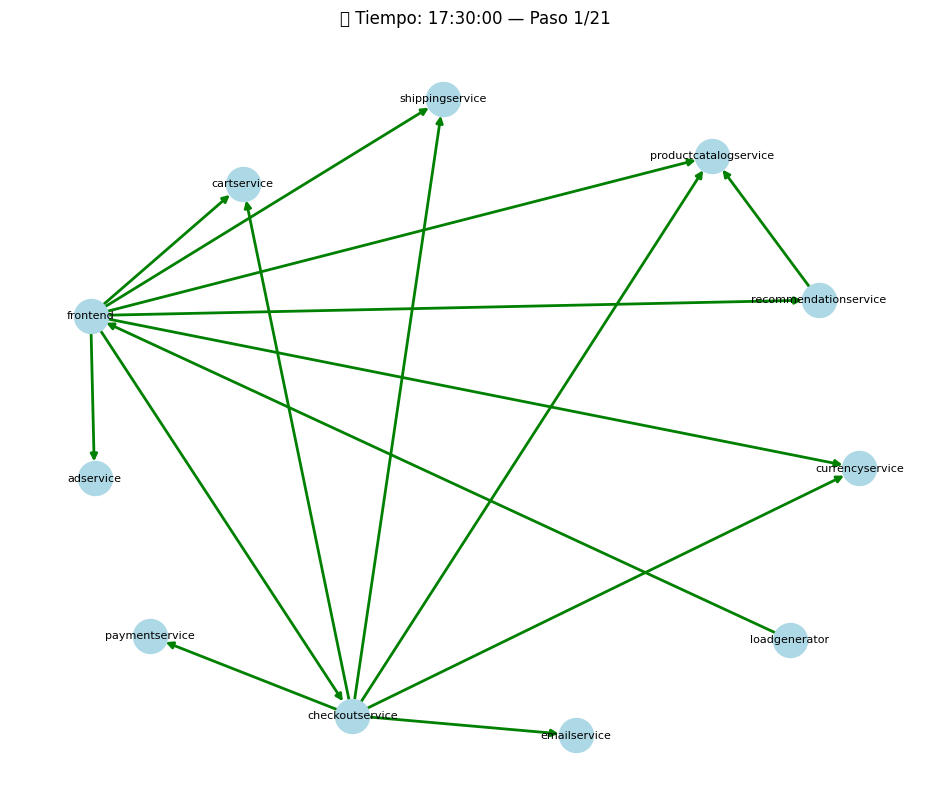

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import timedelta

# Cargar datos
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])
df["window"] = df["timestamp"].dt.floor("T")  # Agrupar por minuto

# Preparar lista de tiempos
time_windows = sorted(df["window"].unique())

# Crear lista de pasos temporales: acumulativos
snapshots = []
G = nx.DiGraph()

for t in time_windows:
    current_df = df[df["window"] == t]
    for _, row in current_df.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        color = row["link_color"]
        anomaly = row["Abnormality class"]
        G.add_node(src, type='service')
        G.add_node(dst, type='service')
        G.add_edge(src, dst, color=color, anomaly=anomaly)
    # Guardar copia del grafo para el frame
    snapshots.append(G.copy())

# Crear animación
fig, ax = plt.subplots(figsize=(12, 10))
pos = nx.spring_layout(snapshots[-1], seed=60, k=10)  # layout fijo para estabilidad

def update(i):
    ax.clear()
    G_i = snapshots[i]
    edge_colors = [d["color"] for _, _, d in G_i.edges(data=True)]
    nx.draw(
        G_i, pos,
        with_labels=True,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=600,
        width=2,
        font_size=8,
        ax=ax
    )
    ax.set_title(f"⏱ Tiempo: {time_windows[i].strftime('%H:%M:%S')} — Paso {i+1}/{len(snapshots)}")

ani = FuncAnimation(fig, update, frames=len(snapshots), interval=800, repeat=False)


ani.save("evolucion_grafo_v3.gif", writer="pillow", fps=1)


# NetworkX

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:61: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  start = df['timestamp'].min().floor('T')
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:62: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  end   = df['timestamp'].max().ceil('T')
C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


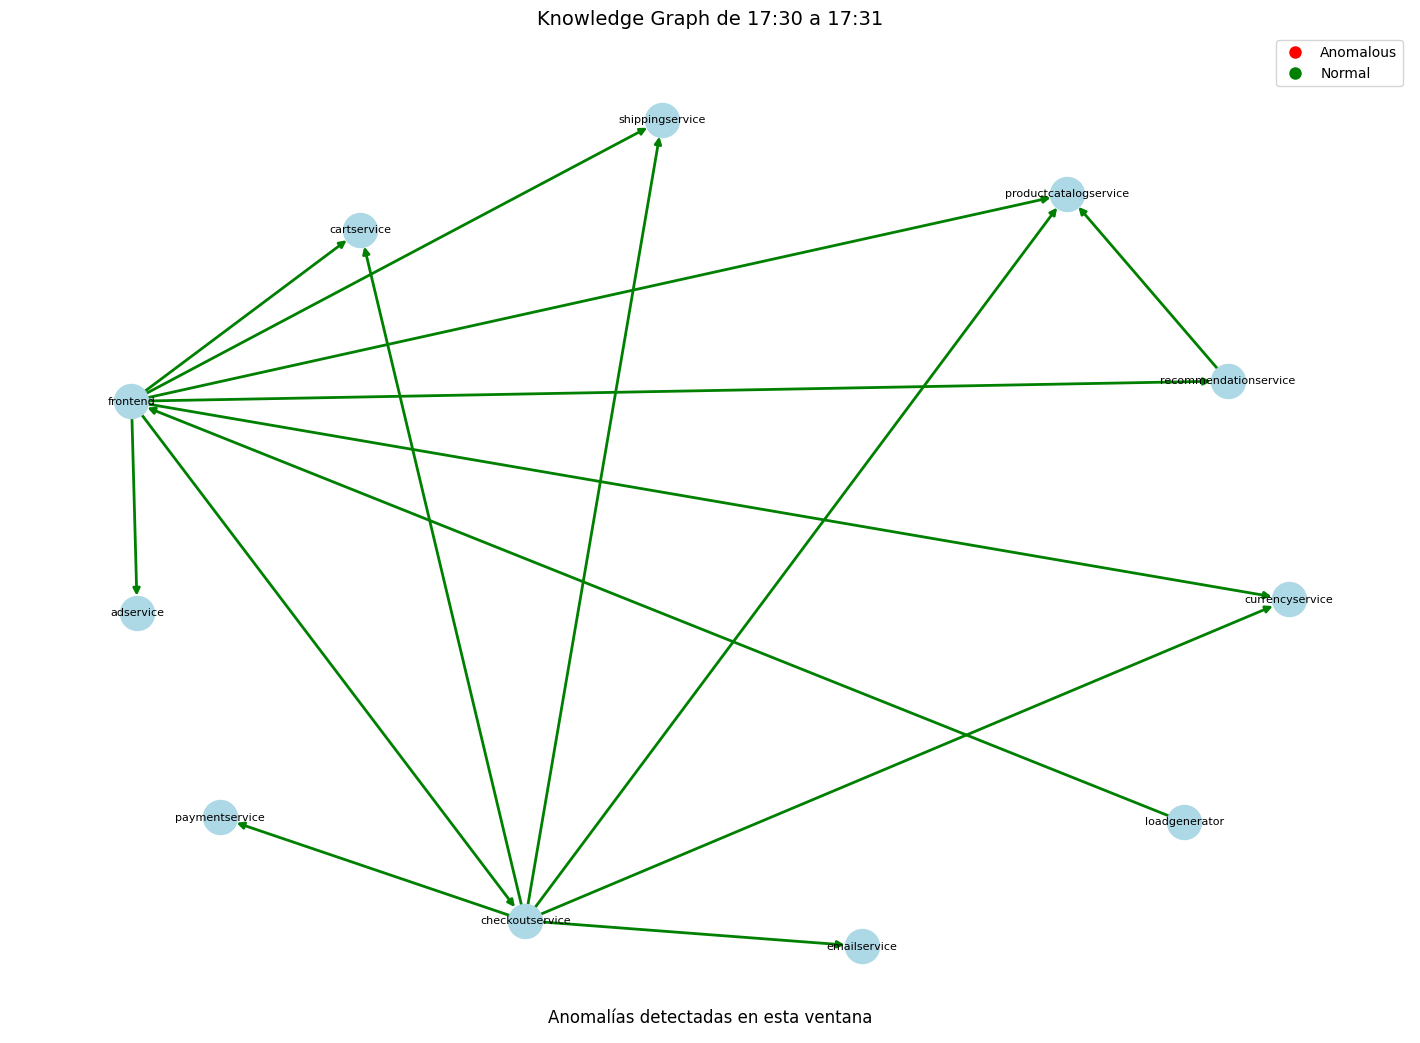

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


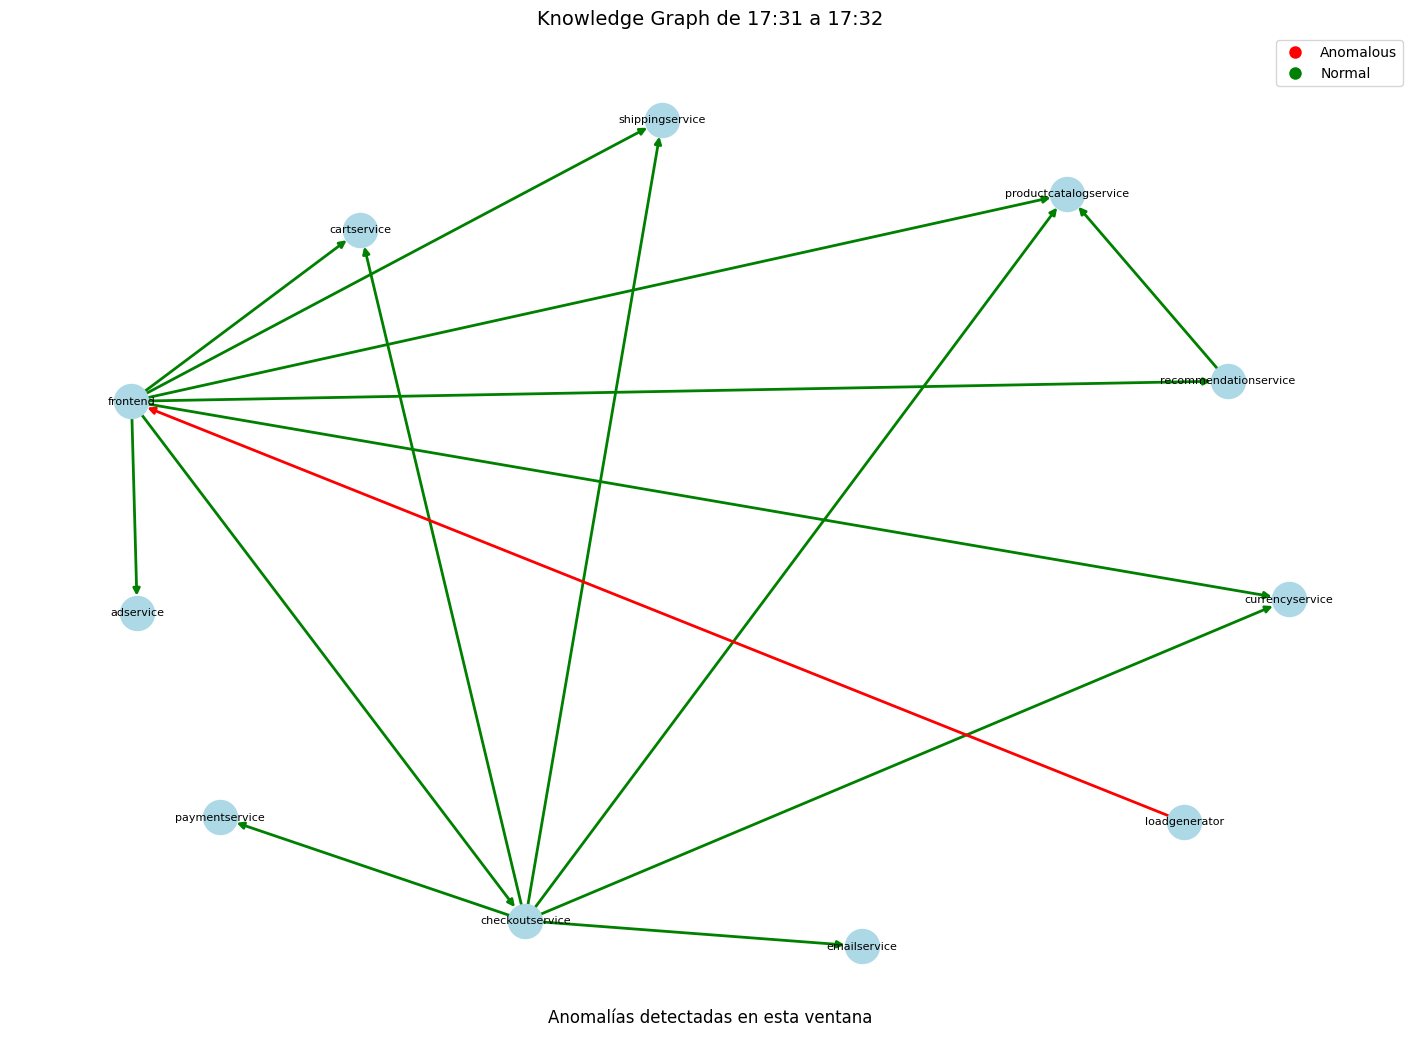

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


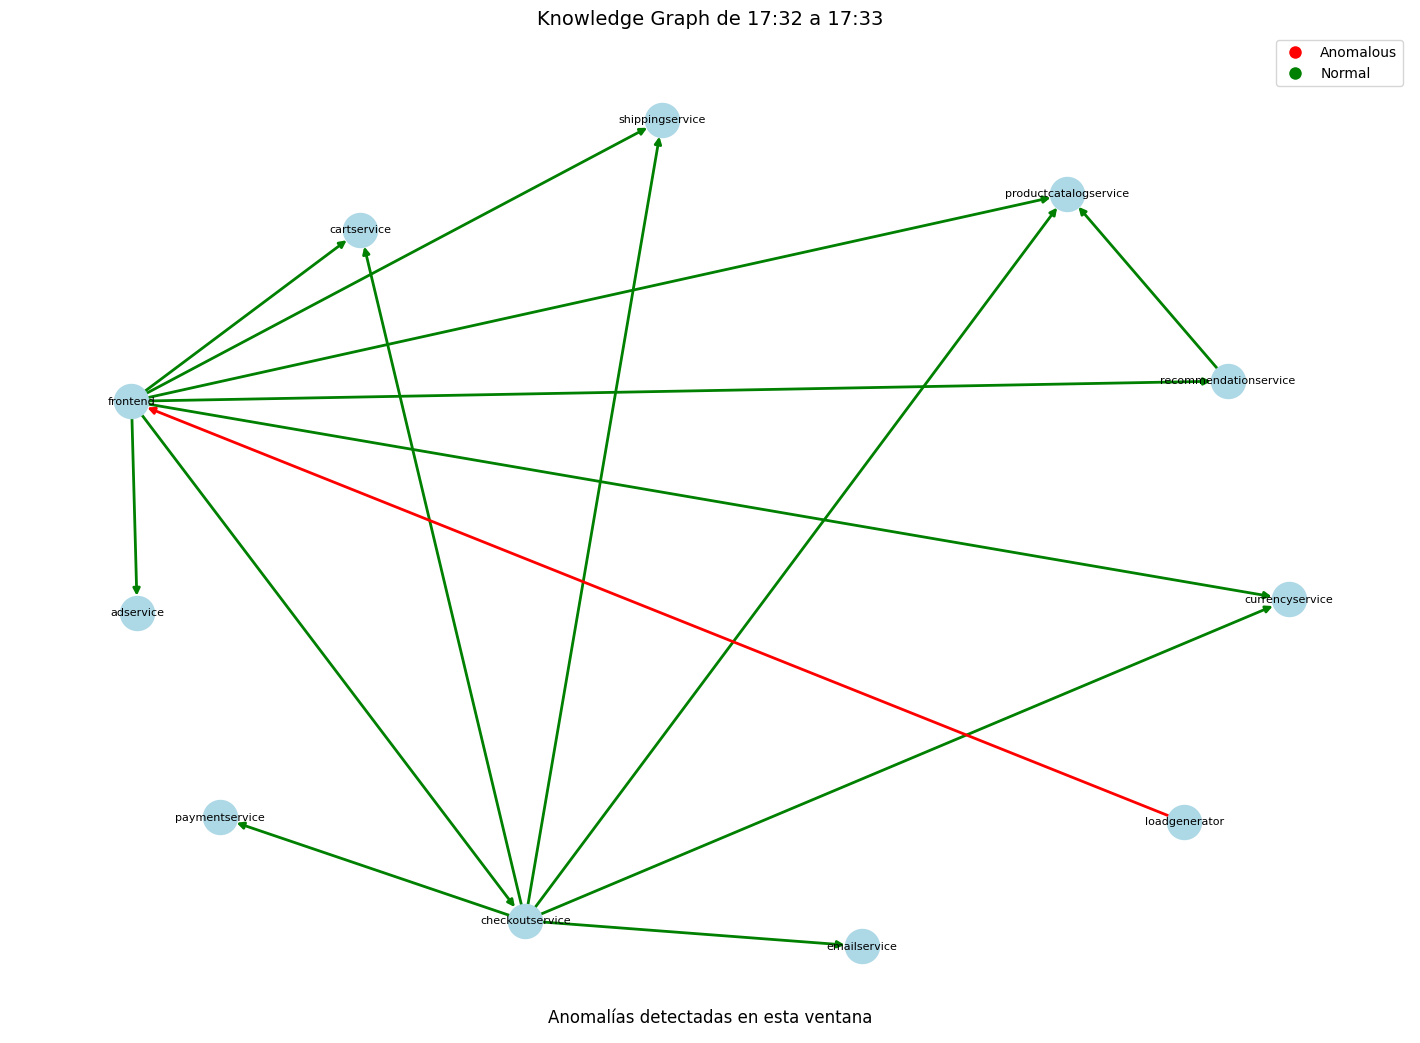

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


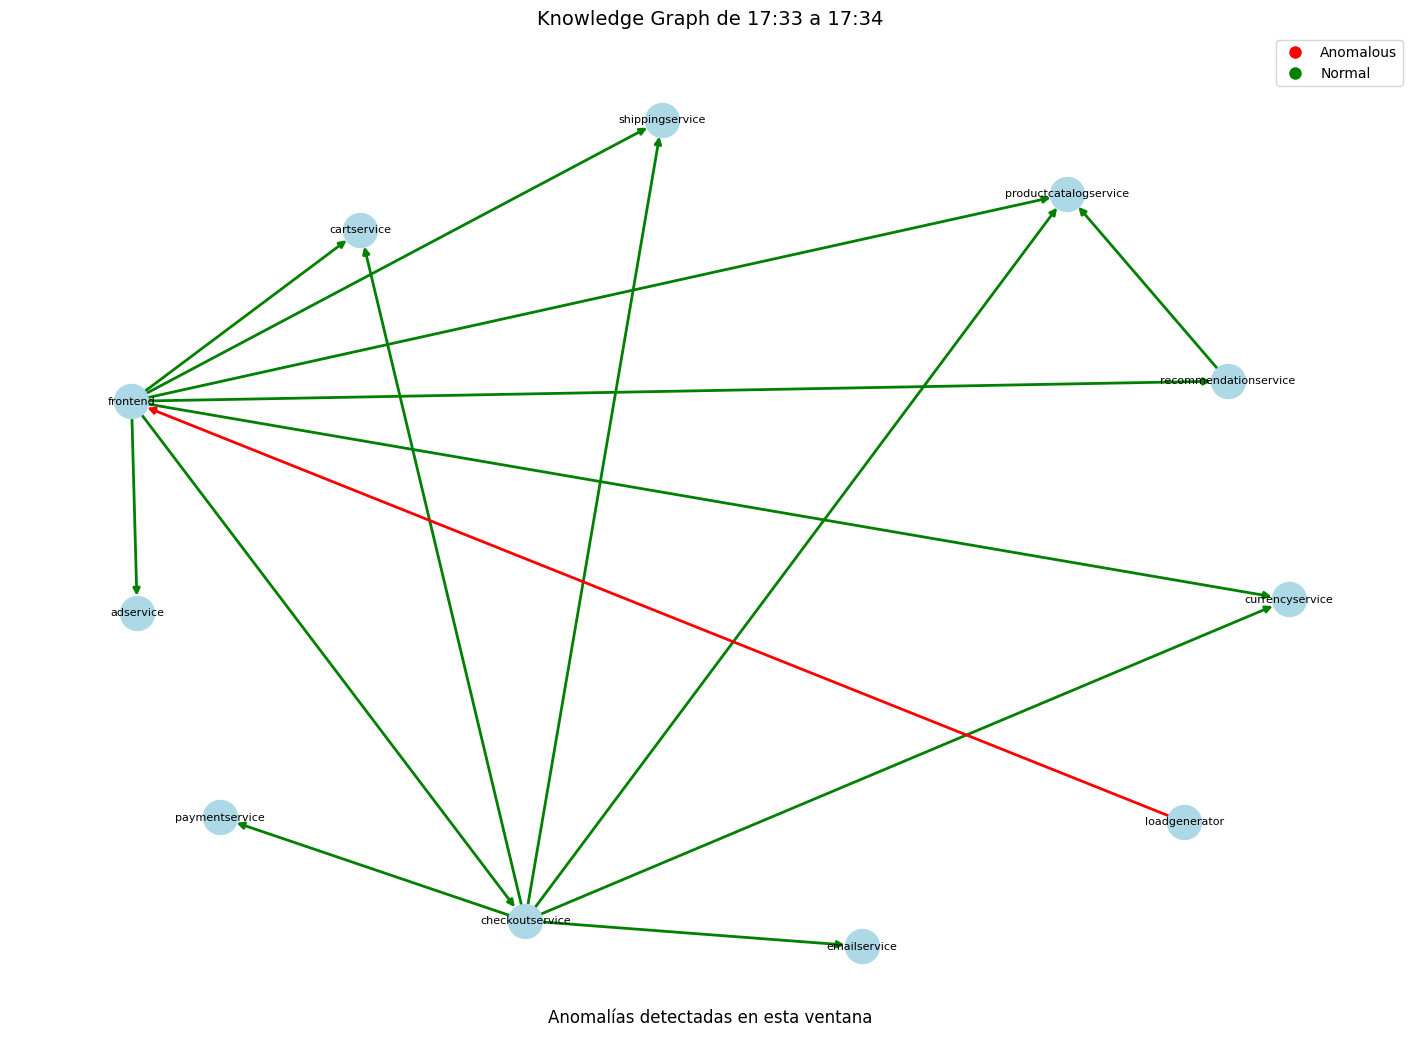

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


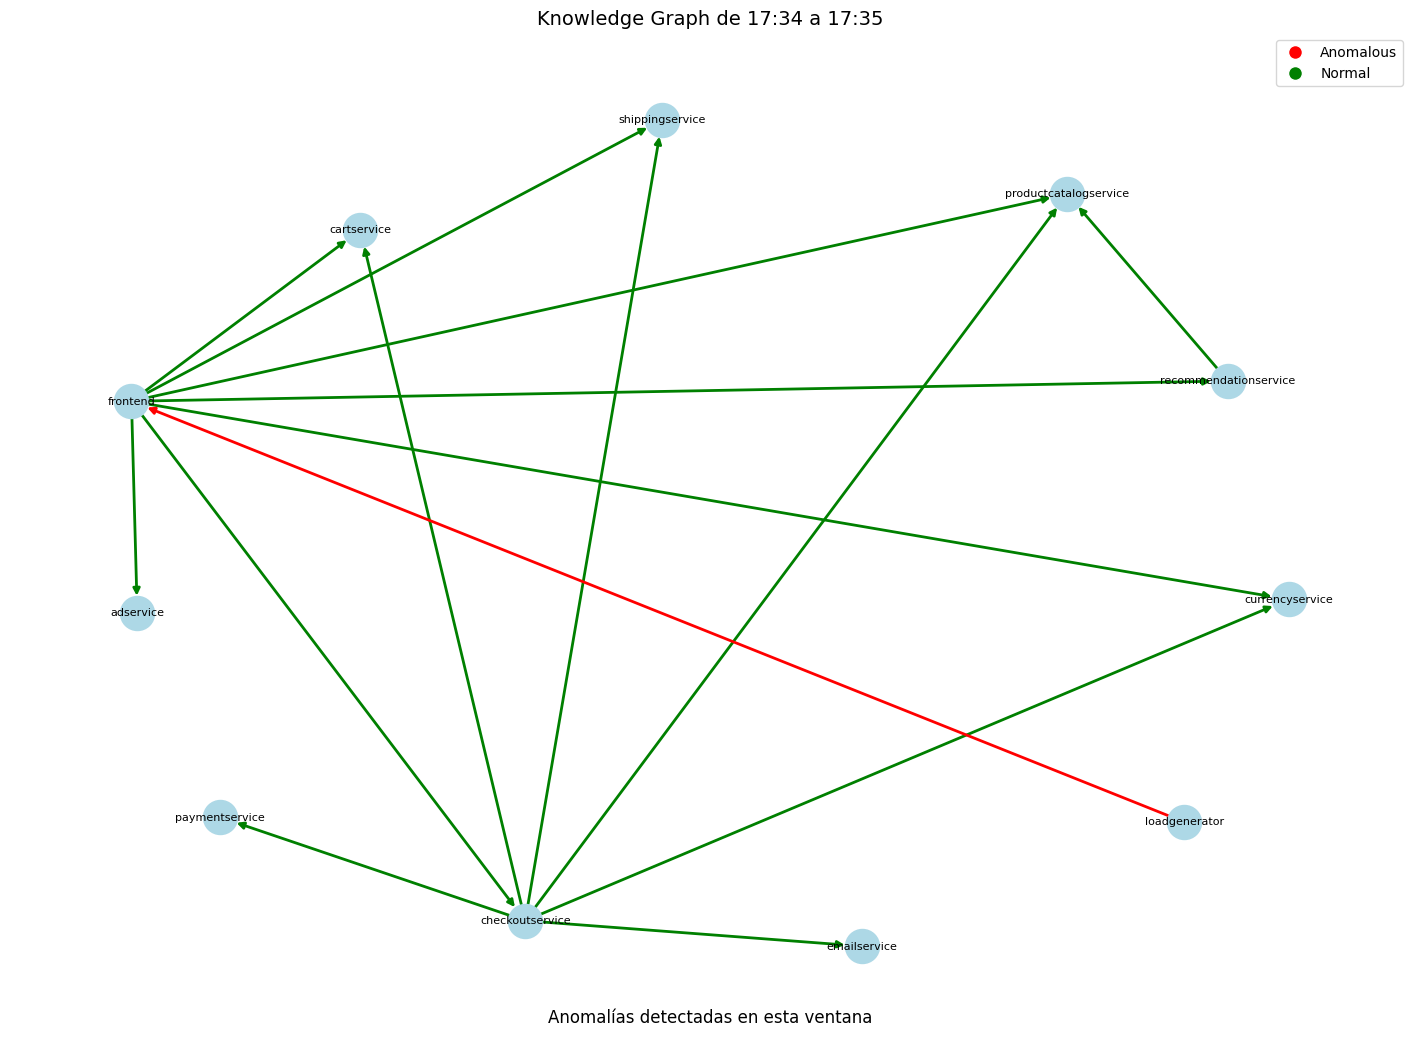

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


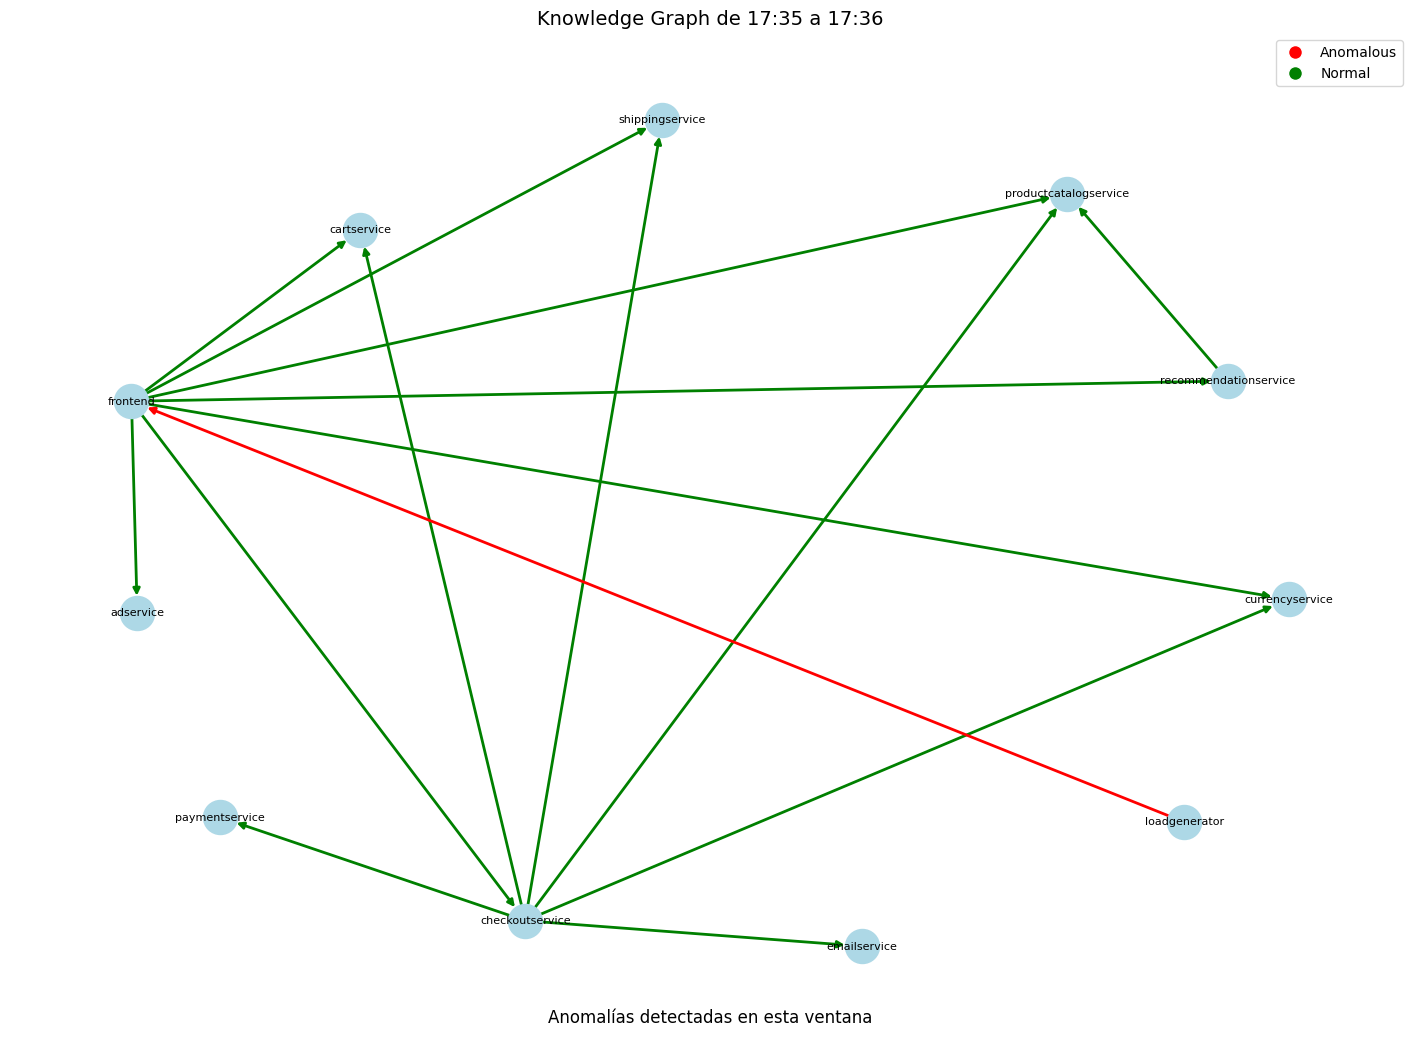

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


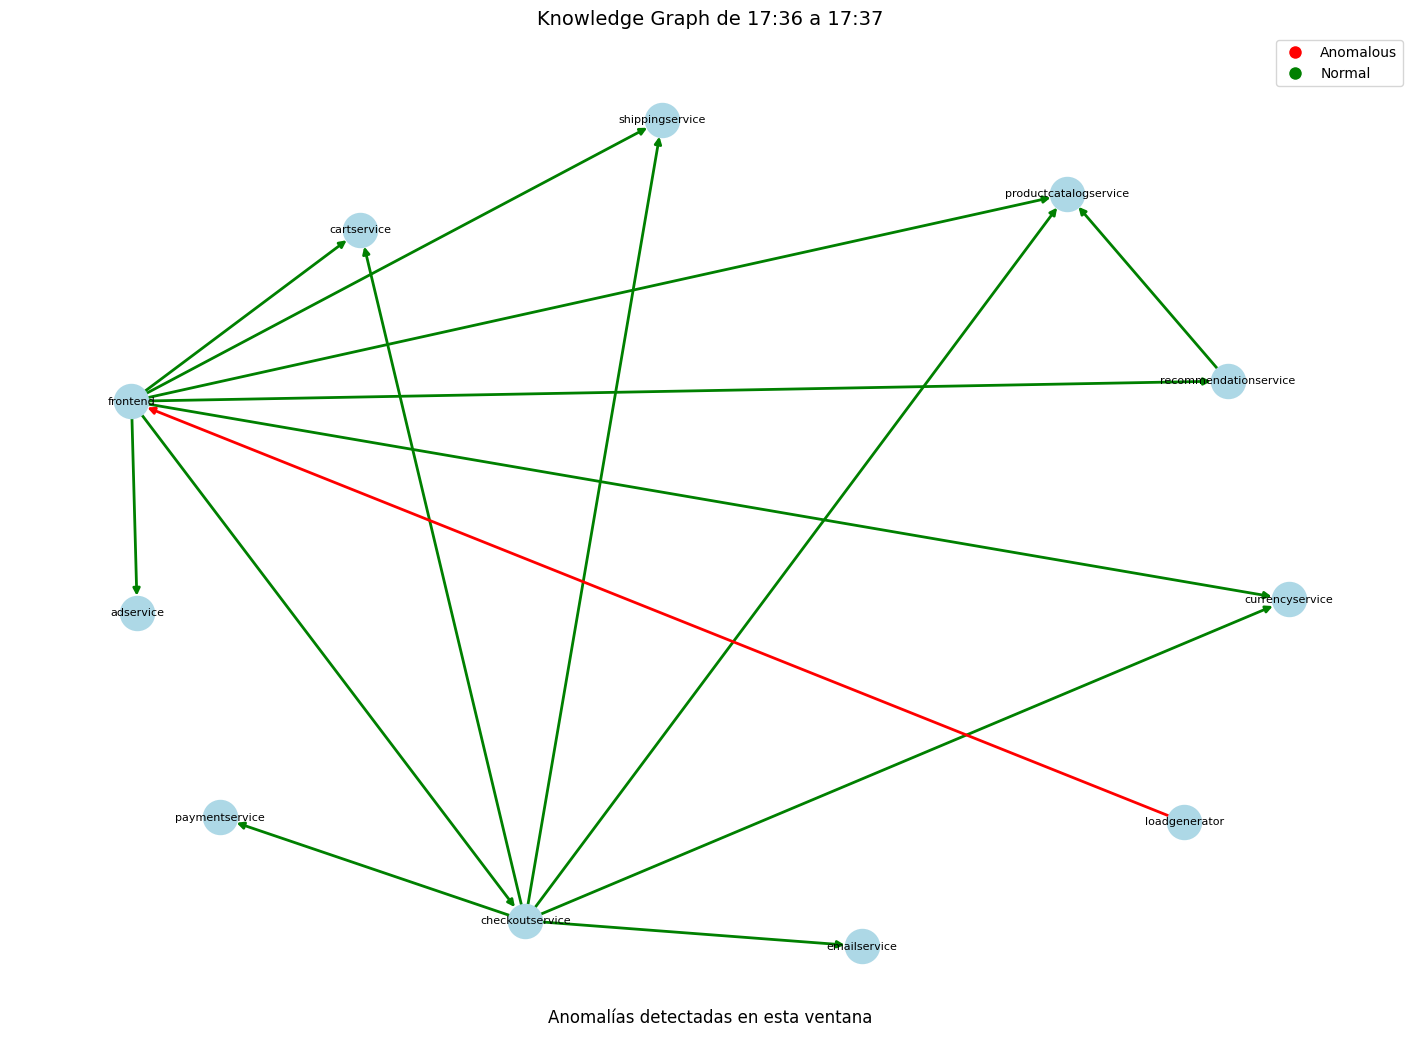

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


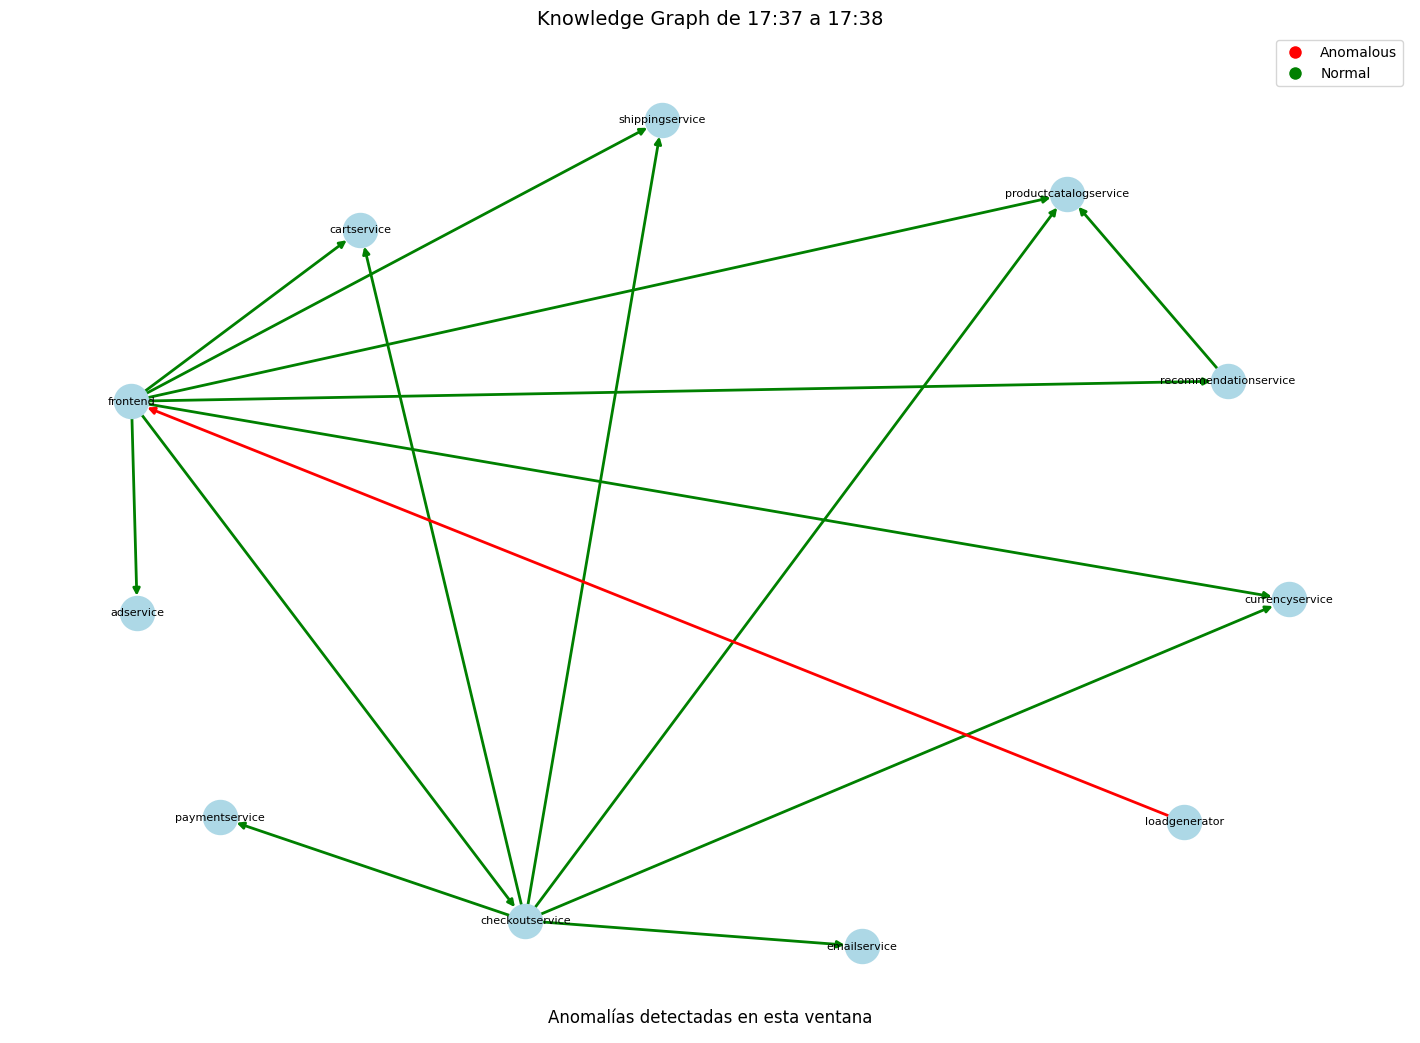

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


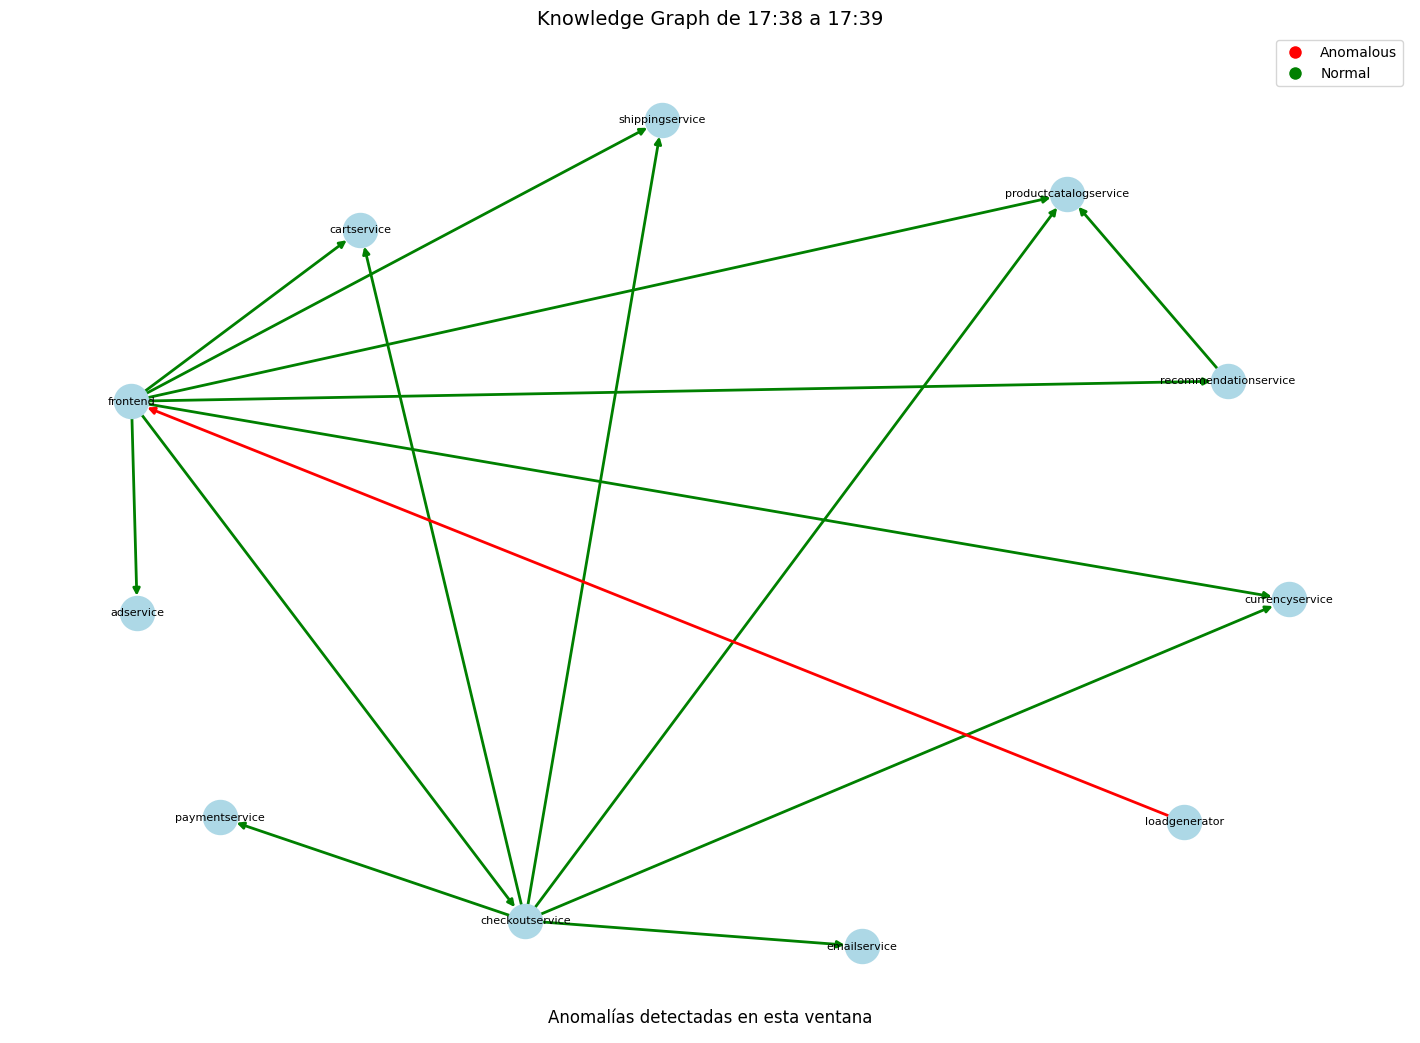

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


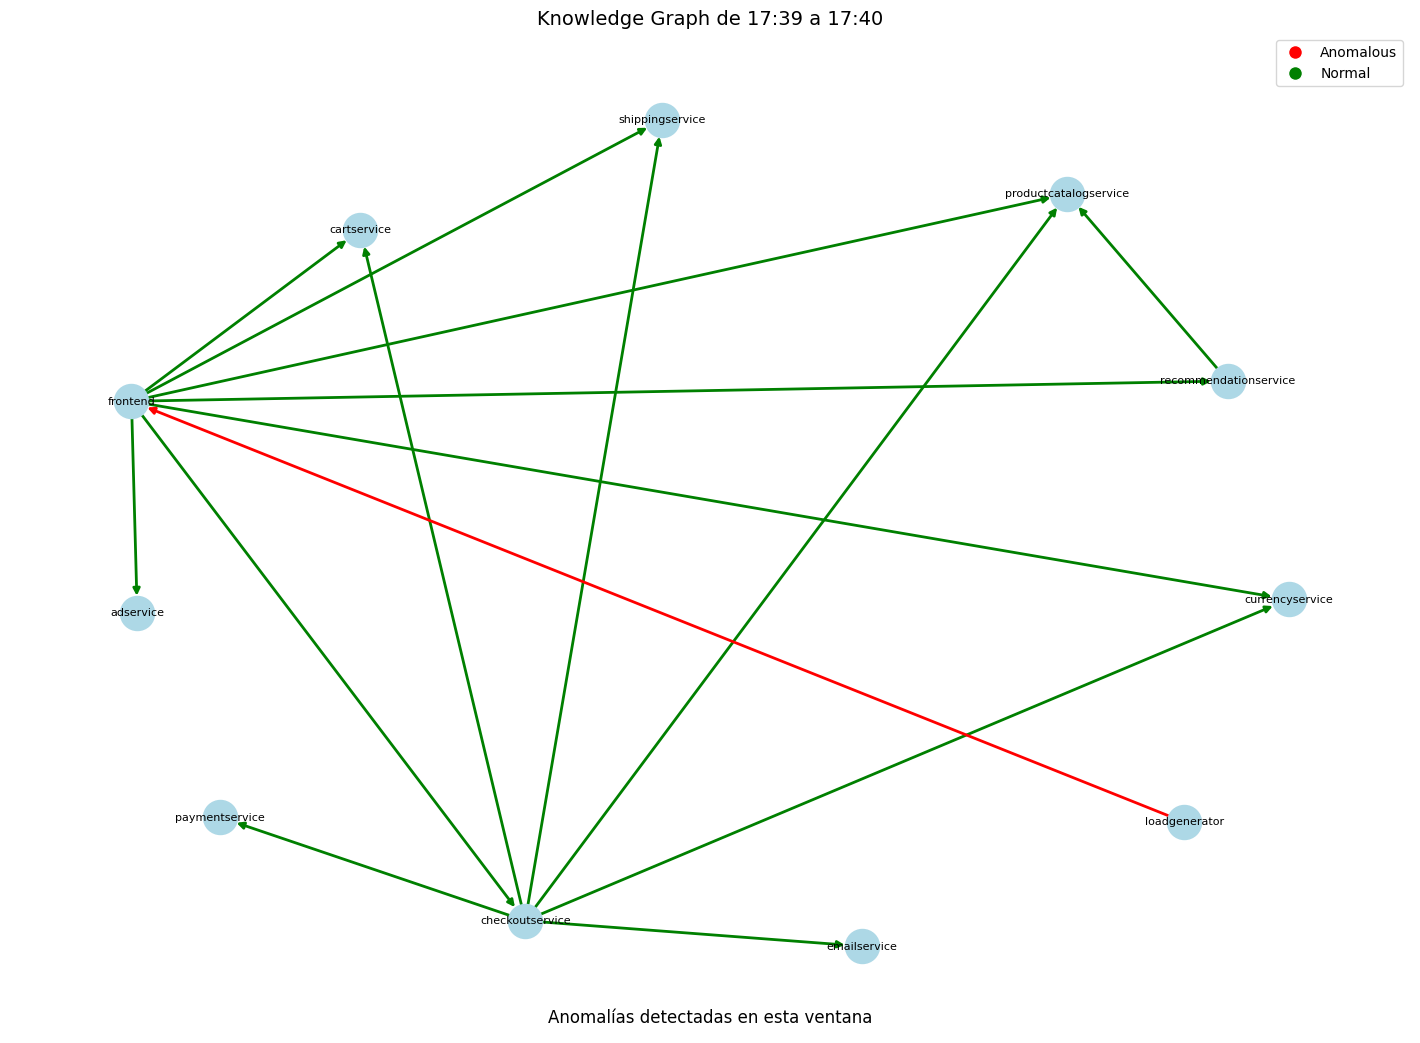

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


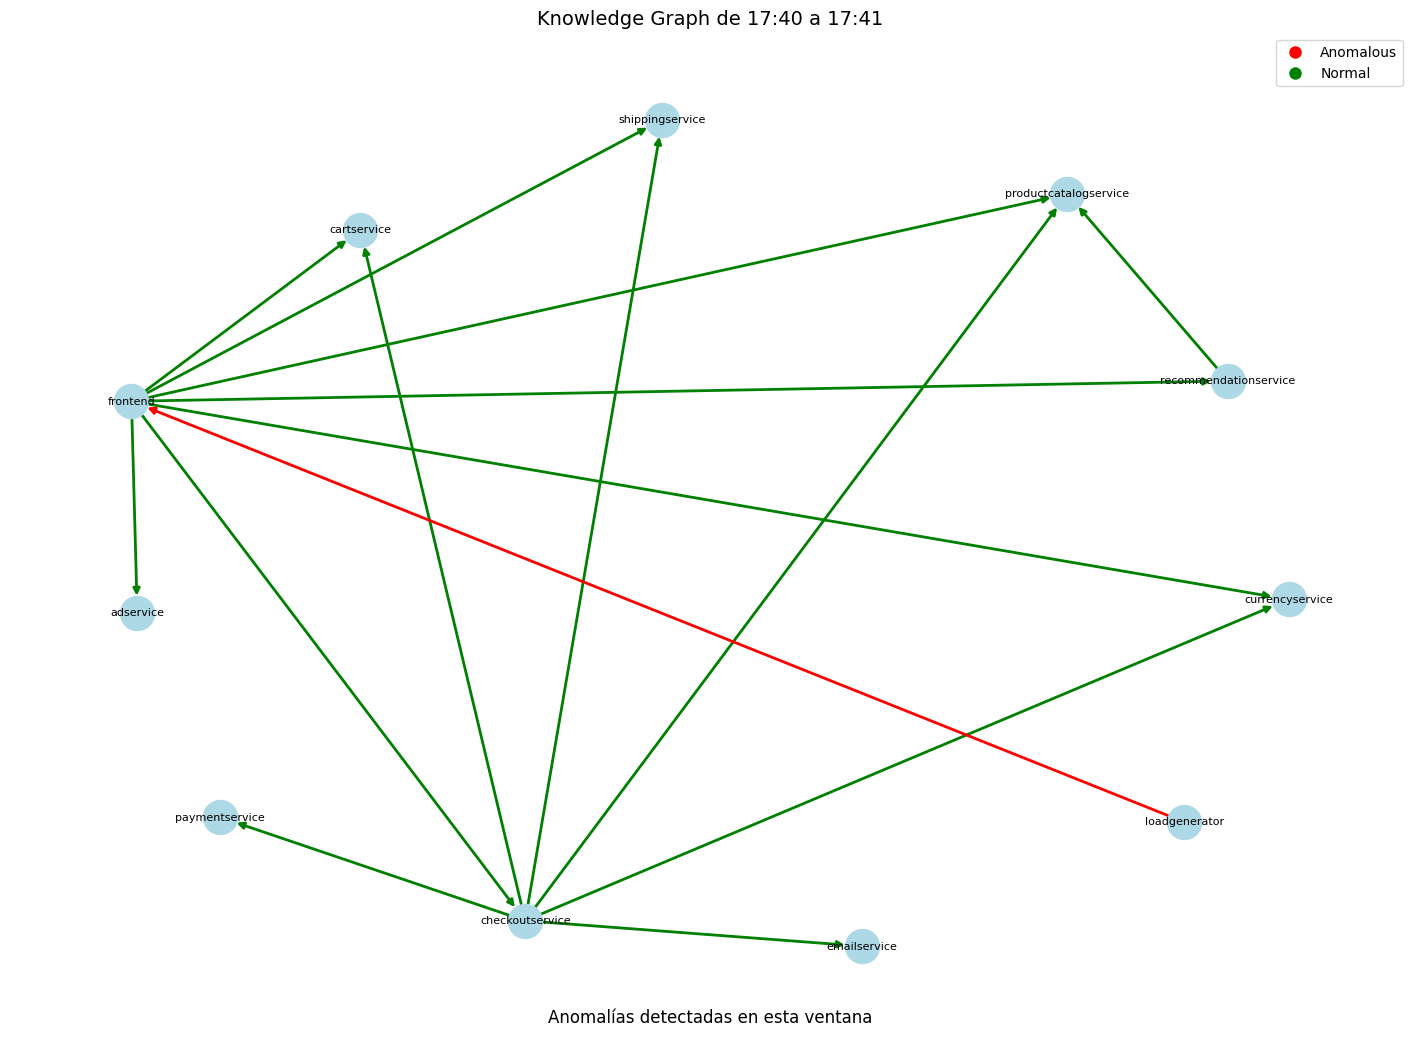

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


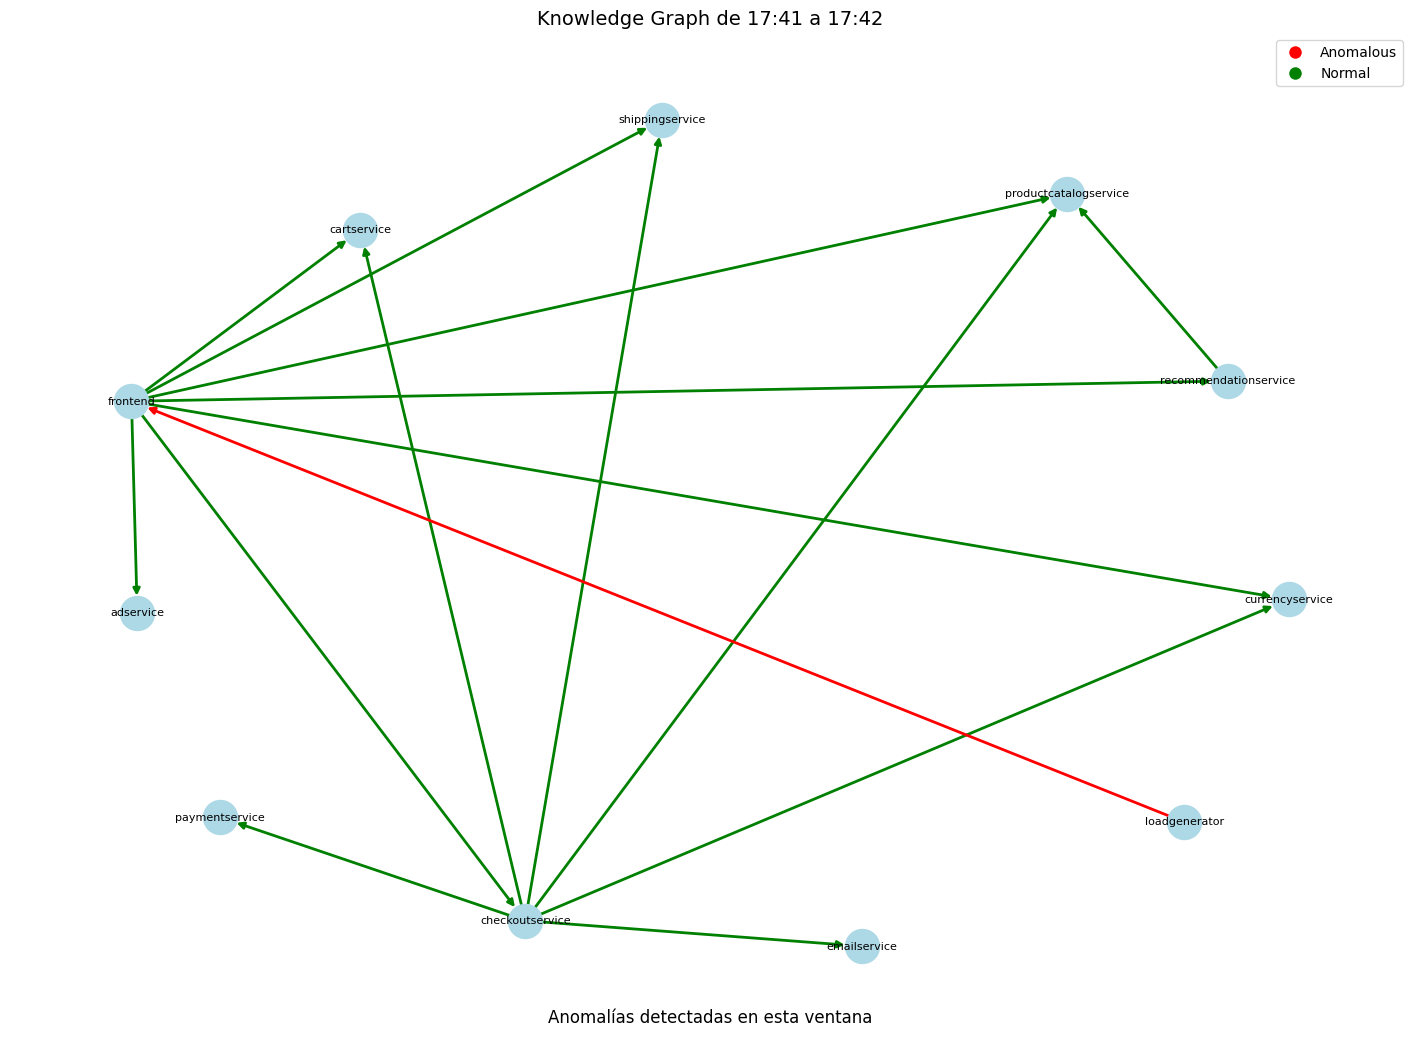

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


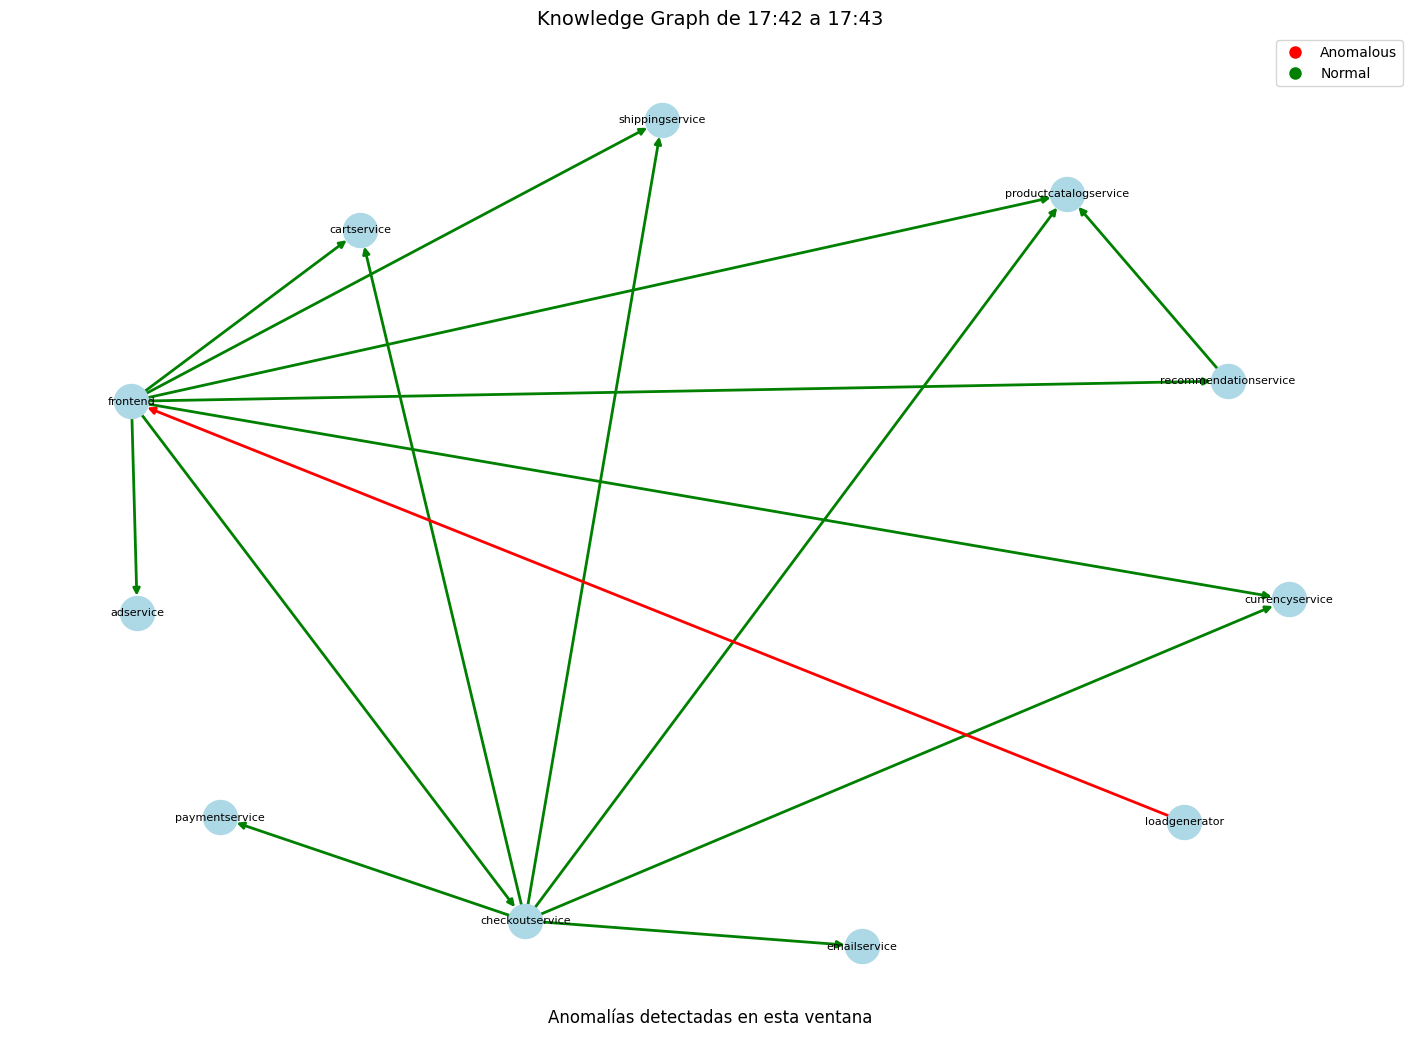

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


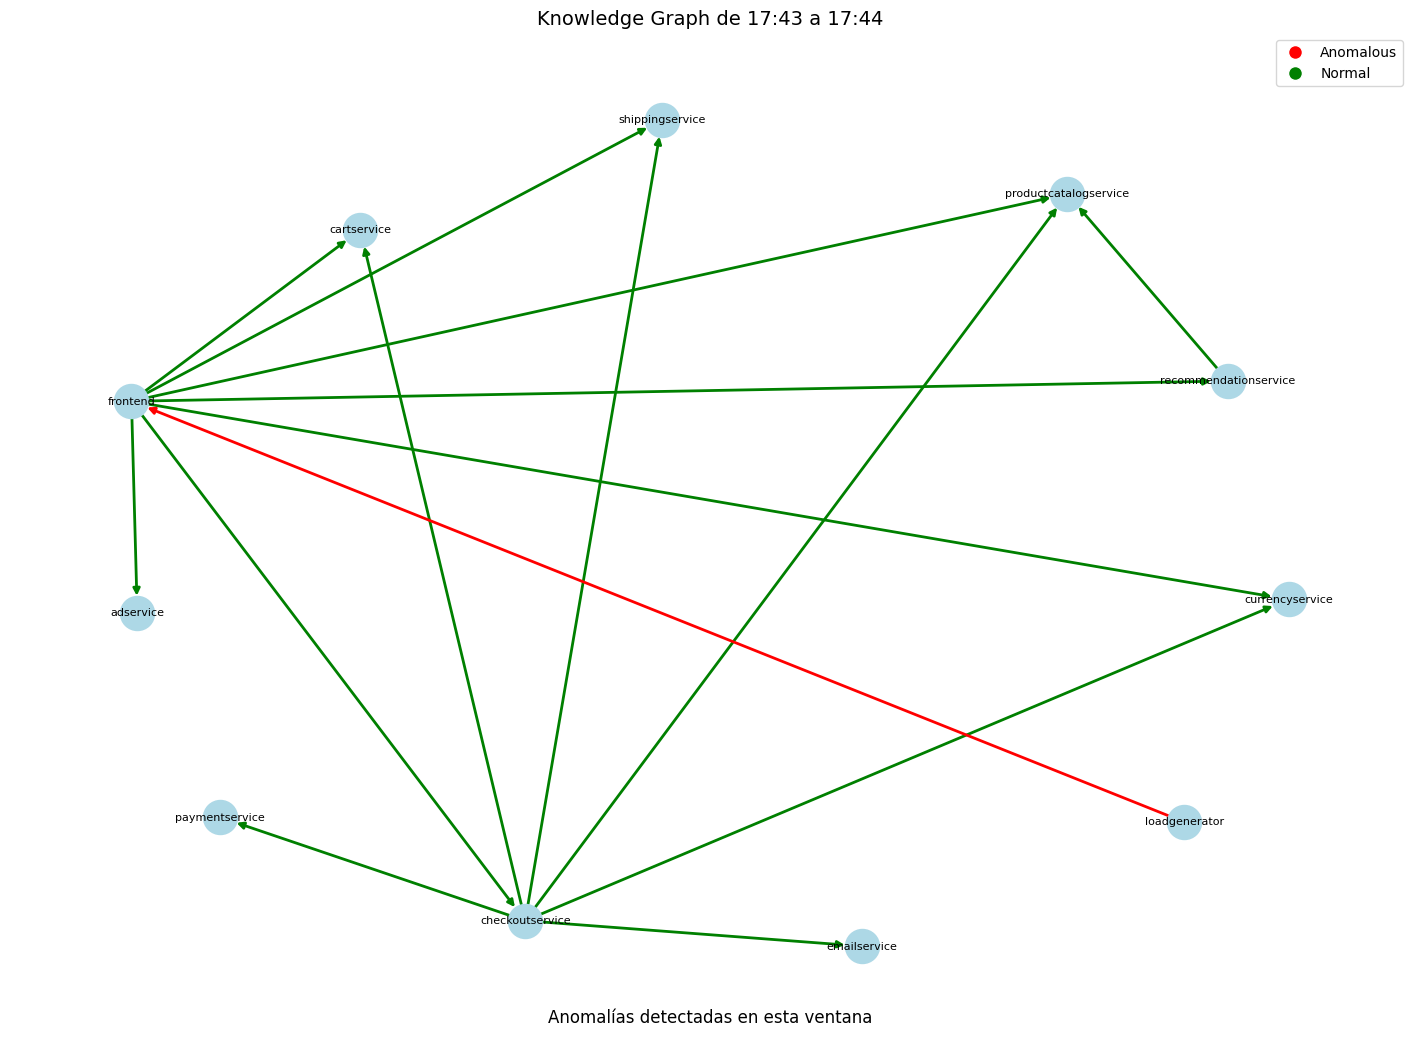

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


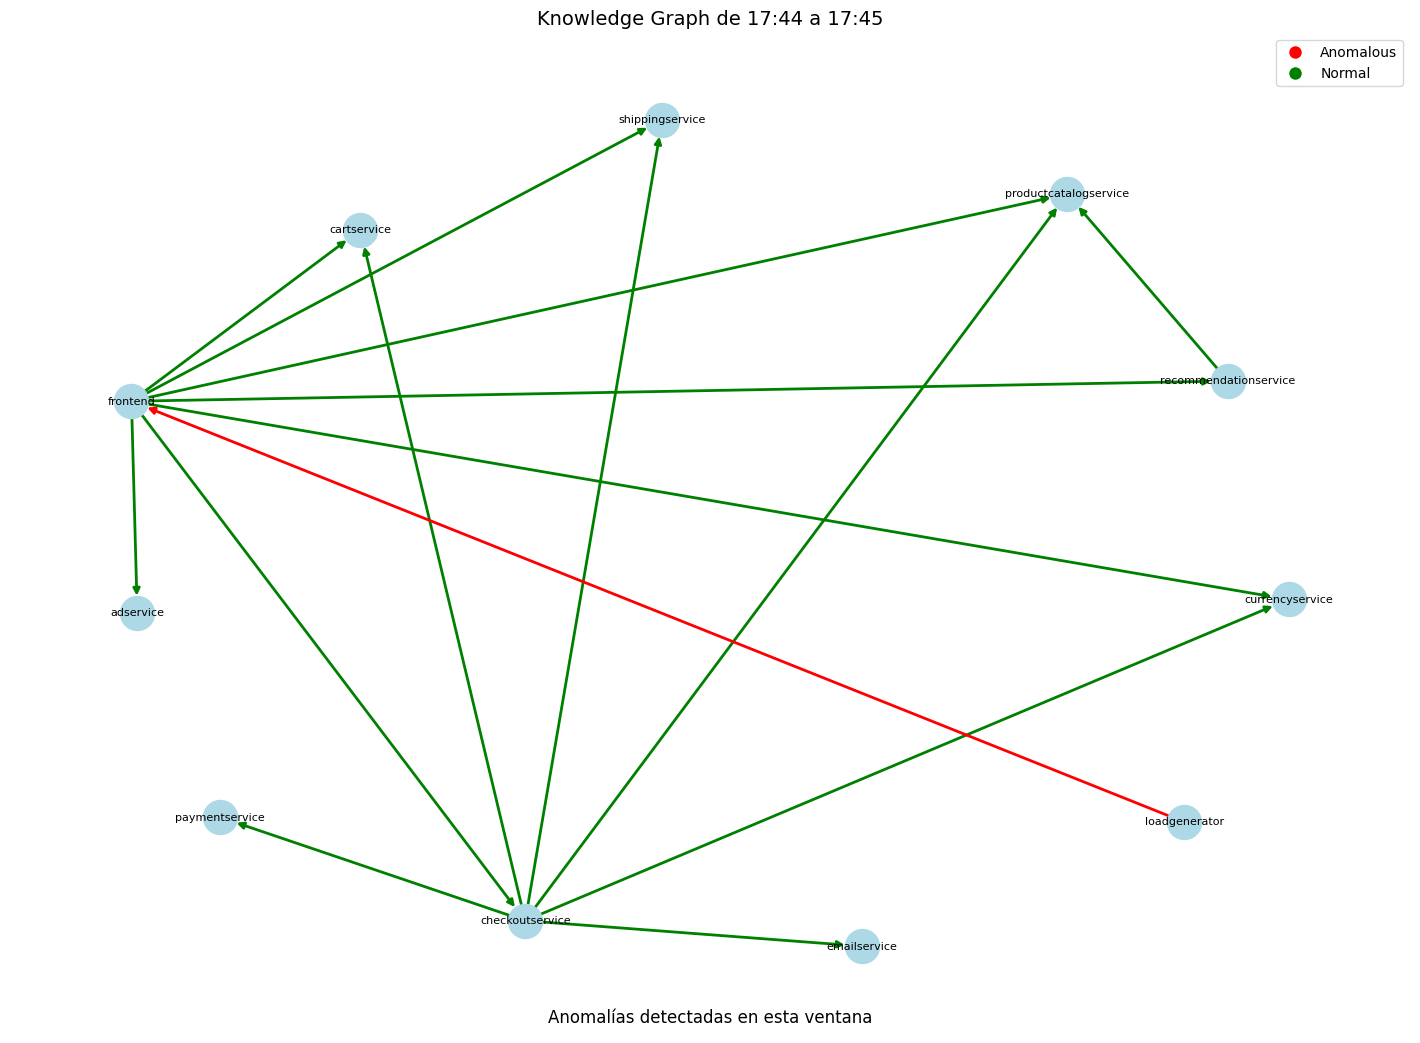

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


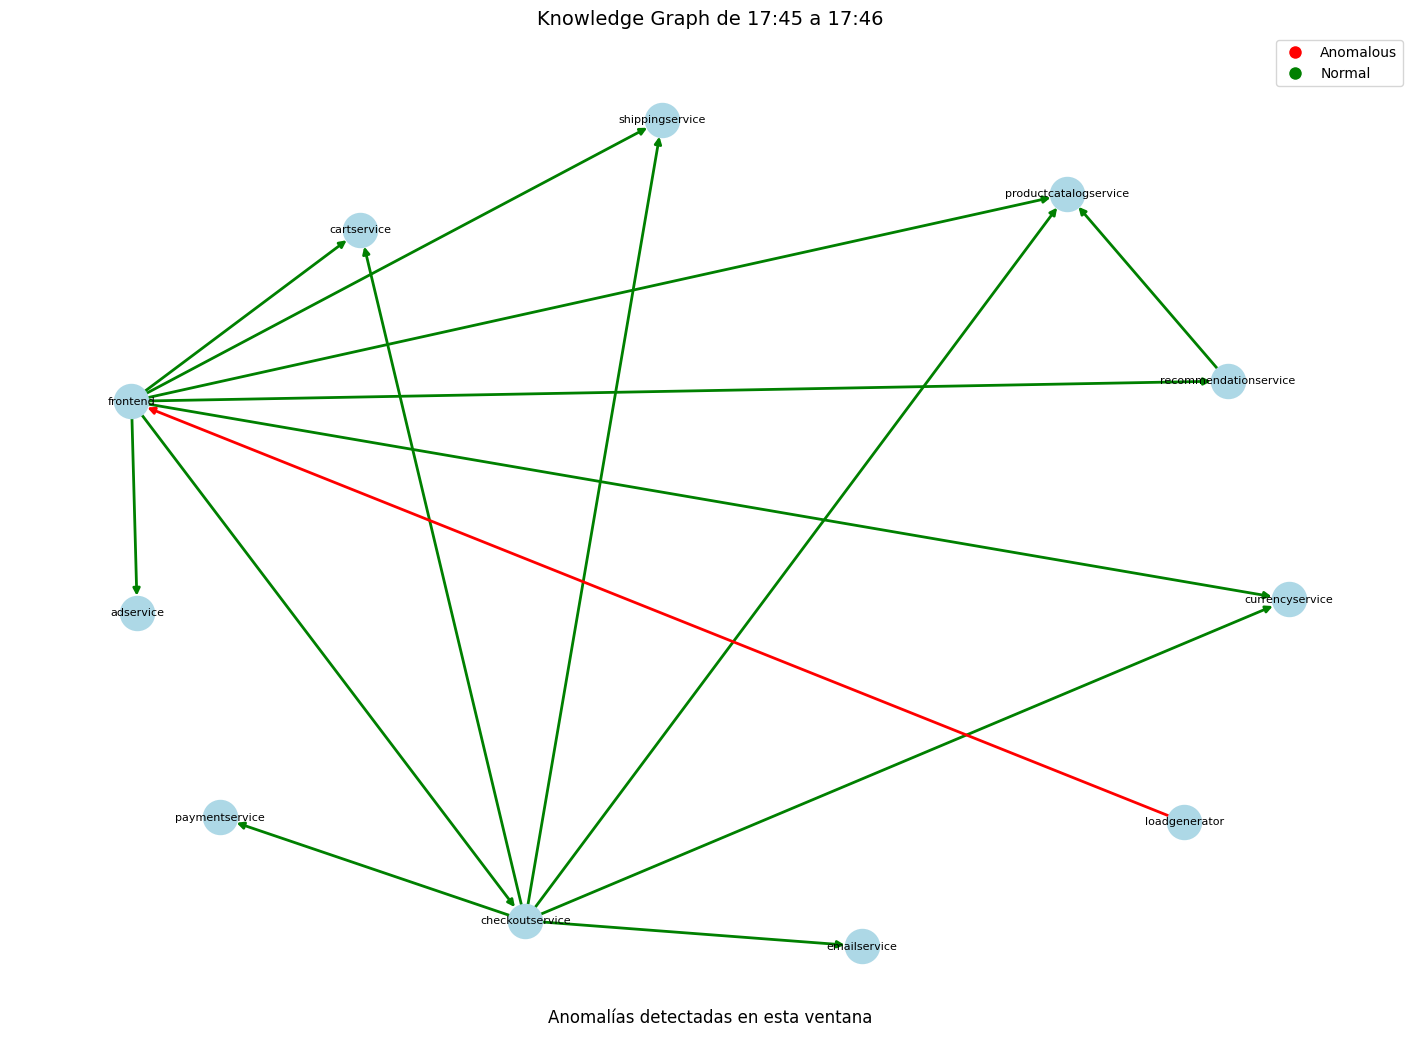

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


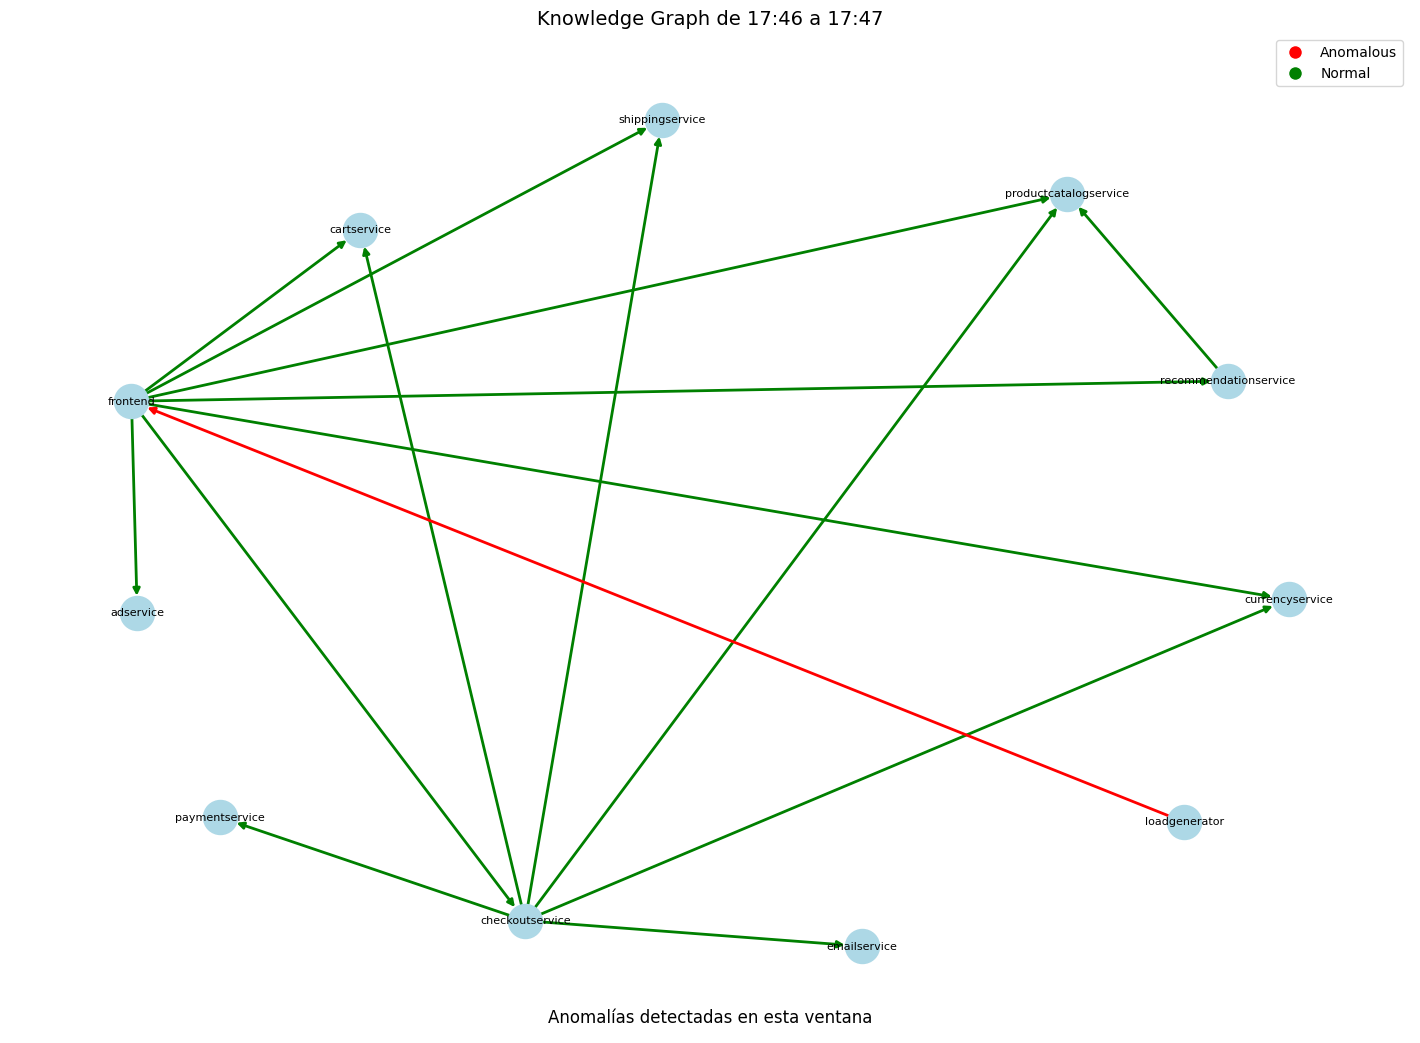

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


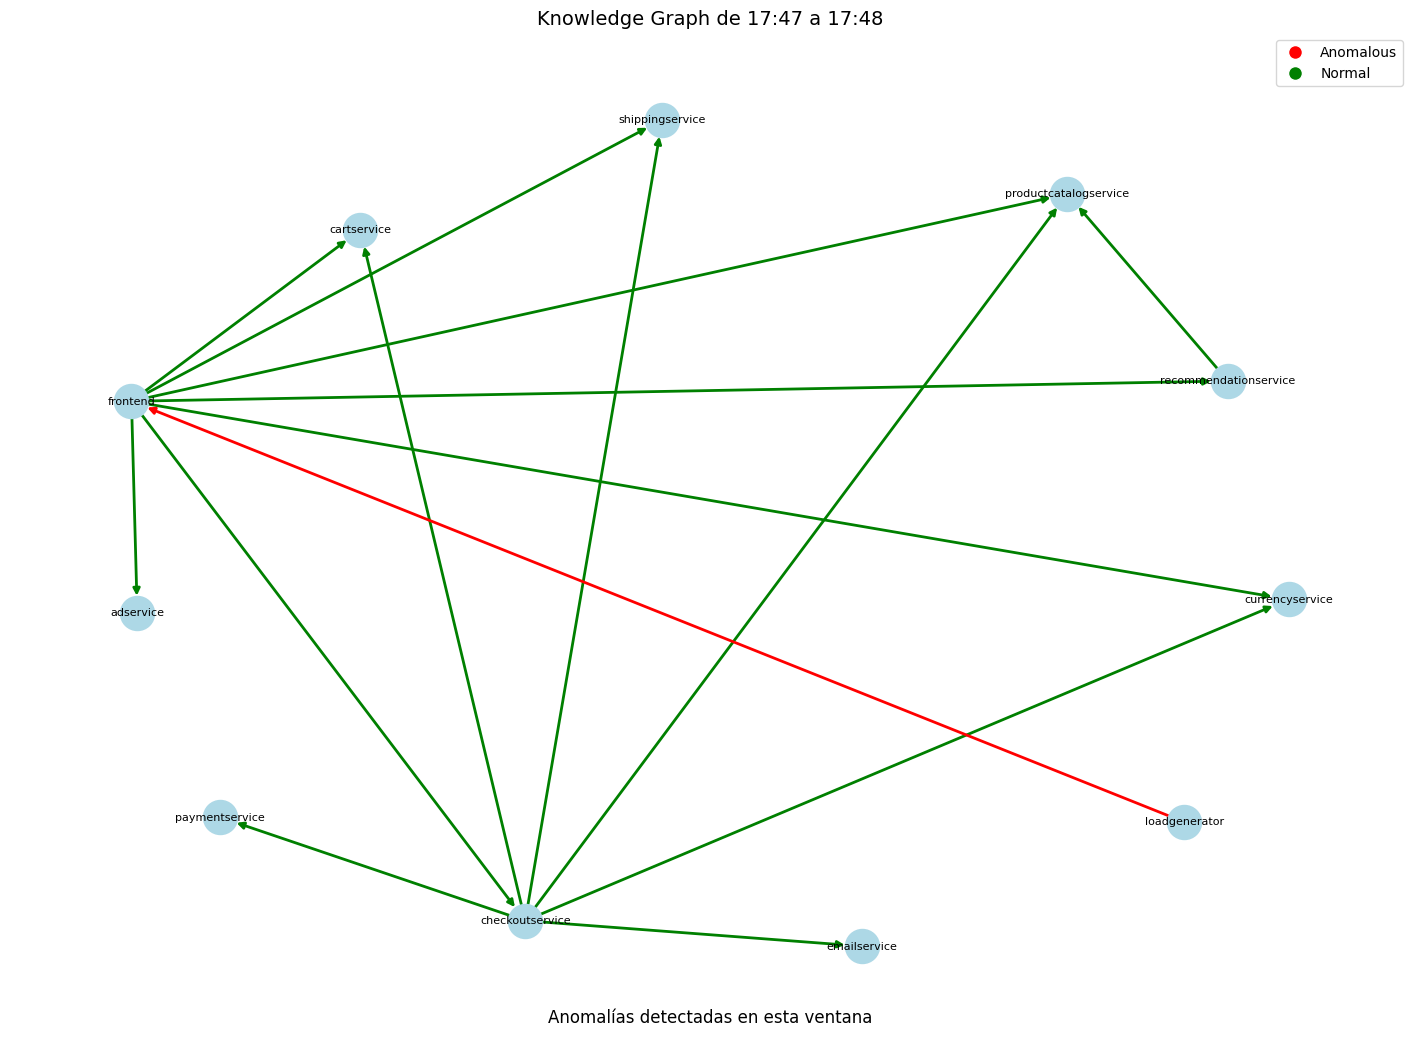

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


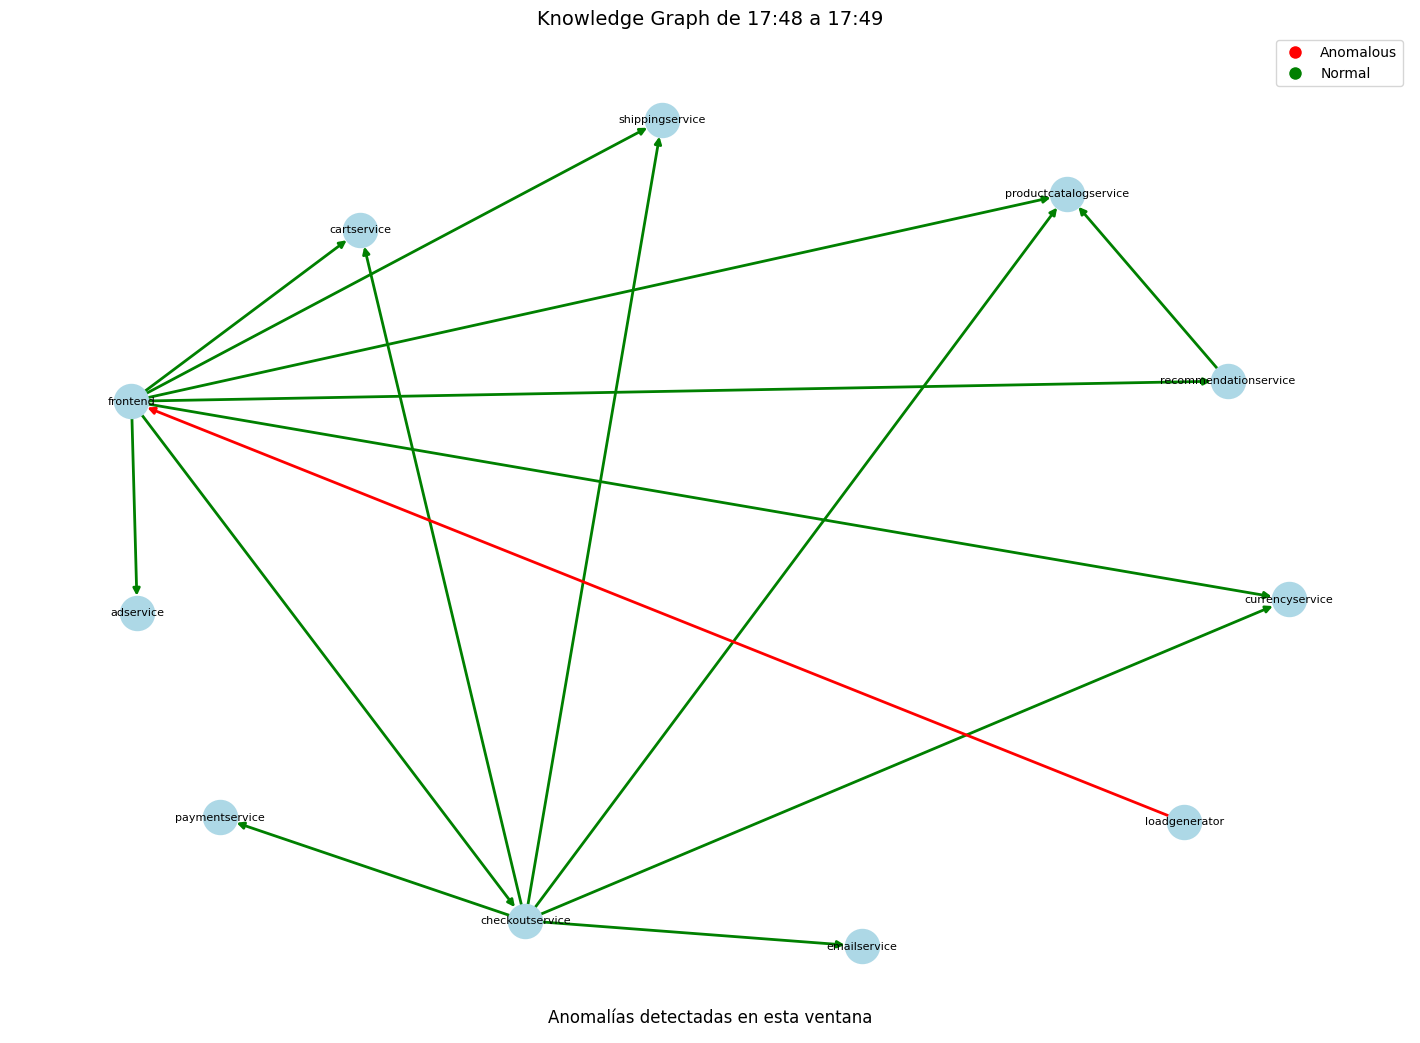

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\3518687670.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


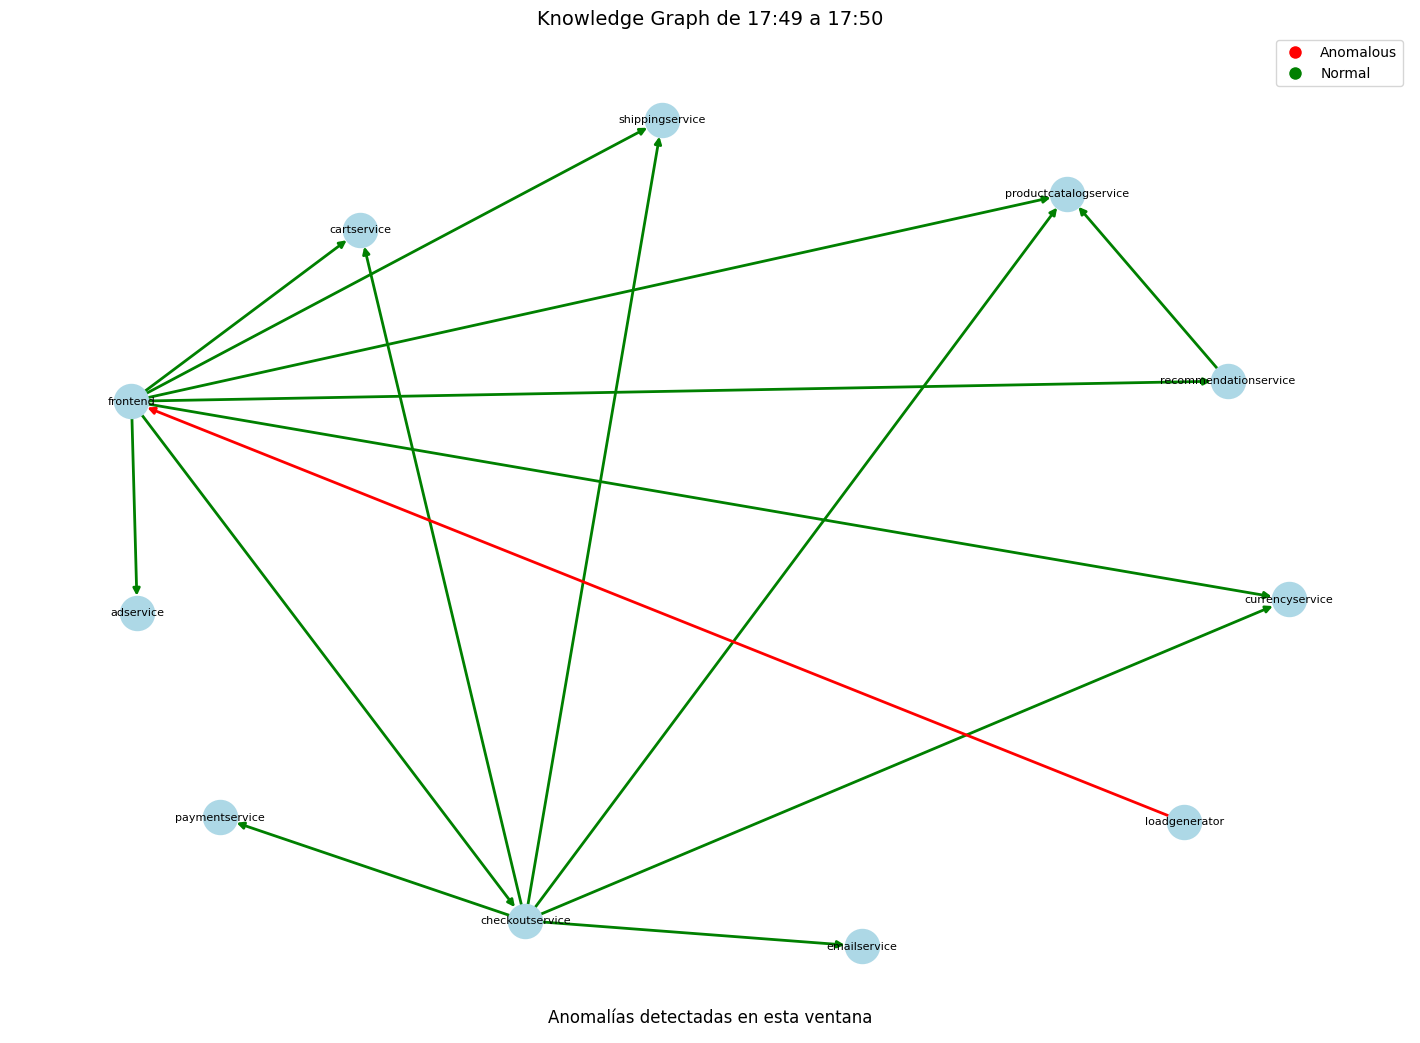

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta

# Carga el CSV y parsea timestamps
df = pd.read_csv('results/kiali_kpi_metrics_processed.csv', parse_dates=['timestamp'])

# Función para generar el grafo en un intervalo de 1 minuto
def create_knowledge_graph(df, start_time, end_time):
    filtered = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
    G = nx.DiGraph()
    anomaly_flag = False

    for _, row in filtered.iterrows():
        src = row['source_workload']
        dst = row['destination_workload']
        G.add_node(src, type='service')
        G.add_node(dst, type='service')
        color = row['link_color']
        anomaly = row['Abnormality class']
        if anomaly != 'Normal':
            anomaly_flag = True
        G.add_edge(src, dst, color=color, anomaly=anomaly)

    anomaly_class = 'Anomalous' if anomaly_flag else 'Normal'
    return G, anomaly_class

# Función para dibujar el grafo y la descripción
def plot_graph(G, start_time, end_time, anomaly_class):
    plt.figure(figsize=(14, 10))
    edge_colors = [d['color'] for _, _, d in G.edges(data=True)]
    pos = nx.spring_layout(G, seed=60, k=10)
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=600,
        node_color='lightblue',
        edge_color=edge_colors,
        width=2,
        font_size=8
    )
    plt.title(f"Knowledge Graph de {start_time.strftime('%H:%M')} a {end_time.strftime('%H:%M')}", fontsize=14)

    # Leyenda
    red_patch   = plt.Line2D([0], [0], marker='o', color='w', label='Anomalous',   markerfacecolor='red',   markersize=10)
    green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Normal',      markerfacecolor='green', markersize=10)
    plt.legend(handles=[red_patch, green_patch], loc='upper right')

    # Texto de anomalía
    if anomaly_class != 'Normal':
        plt.figtext(0.5, 0.01, "Anomalías detectadas en esta ventana", wrap=True, horizontalalignment='center', fontsize=12)
    else:
        plt.figtext(0.5, 0.01, "No se detectaron anomalías en esta ventana", wrap=True, horizontalalignment='center', fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Iterar ventanas de 1 minuto
start = df['timestamp'].min().floor('T')
end   = df['timestamp'].max().ceil('T')

current = start
while current < end:
    next_min = current + timedelta(minutes=1)
    G, anomaly_class = create_knowledge_graph(df, current, next_min)
    plot_graph(G, current, next_min, anomaly_class)
    current = next_min

# Raphtory

In [ ]:
pip install raphtory

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar el dataset procesado
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Crear el grafo
g = Graph()

# Convertir timestamps a milisegundos desde época
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["ts_ms"] = df["timestamp"].astype("int64") // 10**6

# Añadir nodos con todas las propiedades disponibles
for _, row in df.iterrows():
    ts = int(row["ts_ms"])
    src = str(row["source_workload"])
    dst = str(row["destination_workload"])

    # Extraer todas las columnas salvo las de control
    properties = {
        col: row[col] for col in df.columns
        if col not in ["timestamp", "ts_ms", "source_workload", "destination_workload"]
    }

    g.add_node(timestamp=ts, id=src, properties=properties)
    g.add_node(timestamp=ts, id=dst, properties=properties)

    # Añadir arista con propiedades clave
    g.add_edge(
        timestamp=ts,
        src=src,
        dst=dst,
        properties={
            "success_rate": row.get("success_rate"),
            "request_rate": row.get("request_rate"),
            "throughput": row.get("throughput"),
            "link_color": row.get("link_color"),
            "abnormality_class": row.get("Abnormality class")
        }
    )

# Guardar el grafo
output_path = "graphs/kiali_fullnode_graph-1"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs/", exist_ok=True)
g.save_to_file("graphs/kiali_fullnode_graph-1")

print("✅ Grafo guardado en:", output_path)


✅ Grafo guardado en: graphs/kiali_fullnode_graph-1


In [ ]:
from raphtory.graphql import GraphServer
import time

# Inicializar el servidor desde la carpeta donde está guardado el grafo
server = GraphServer(work_dir="graphs/").start()
client = server.get_client()

# Pausa para asegurar que el grafo se cargue correctamente
time.sleep(2)

# Función segura para ejecutar queries
def safe_query(query, label):
    try:
        result = client.query(query)
        if "graph" in result or "__schema" in result:
            print(f"\n✅ {label} ejecutada con éxito.")
            return result
        else:
            print(f"\n⚠️ {label}: resultado inesperado.")
            return result
    except Exception as e:
        print(f"\n❌ Error en {label}: {e}")
        return None

# Query 1: Propiedades de los nodos
node_properties_query = """
{
  graph(path: "kiali_fullnode_graph-1") {
    nodes {
      list {
        name
        degree
        properties {
          keys
          values {
            value
          }
        }
      }
    }
  }
}
"""
node_data = safe_query(node_properties_query, "Node Properties")
if node_data and "graph" in node_data:
    nodes = node_data["graph"]["nodes"]["list"]
    for node in nodes:
        properties = dict(zip(node["properties"]["keys"], [v["value"] for v in node["properties"]["values"]]))
        print(f"Node: {node['name']}, Degree: {node['degree']}, Properties: {properties}")

# Query 2: Propiedades de las aristas
# Query para obtener las propiedades de las aristas
edge_properties_query = """
{
  graph(path: "kiali_fullnode_graph-1") {
    edges {
      list {
        src {
          name
        }
        dst {
          name
        }
        properties {
          keys
          values {
            value
          }
        }
      }
    }
  }
}
"""

# Ejecutar la query
edge_data = safe_query(edge_properties_query, "Edge Properties")

# Procesar y mostrar los resultados
if edge_data and "graph" in edge_data:
    edges = edge_data["graph"]["edges"]["list"]
    for edge in edges:
        src = edge["src"]["name"]
        dst = edge["dst"]["name"]
        properties = dict(zip(edge["properties"]["keys"], [v["value"] for v in edge["properties"]["values"]]))
        print(f"Edge: {src} -> {dst}, Properties: {properties}")
else:
    print("❌ No se pudieron obtener los datos de las aristas.")

# Query 3: Nodos con alto grado
high_degree_nodes_query = """
{
  graph(path: "communication_graph-1") {
    nodes {
      list {
        name
        degree
      }
    }
  }
}
"""
node_degree_data = safe_query(high_degree_nodes_query, "Node Degrees")
if node_degree_data and "graph" in node_degree_data:
    high_degree_nodes = [
        node for node in node_degree_data["graph"]["nodes"]["list"]
        if node["degree"] > 5
    ]
    print("🎯 High Degree Nodes:")
    for node in high_degree_nodes:
        print(f"Node: {node['name']}, Degree: {node['degree']}")
test_query = """
{
  graph(path: "kiali_fullnode_grap-1h") {
    edges {
      list {
        src {
          name
        }
        dst {
          name
        }
      }
    }
  }
}
"""
test_data = safe_query(test_query, "Test Query")
print(test_data)

# Query 4: Introspección del esquema
introspection_query = """
{
  __schema {
    types {
      name
      fields {
        name
        type {
          name
          kind
        }
      }
    }
  }
}
"""
schema_info = safe_query(introspection_query, "Schema Introspection")
if schema_info and "__schema" in schema_info:
    types = schema_info["__schema"]["types"]
    for type_info in types:
        print(f"Type: {type_info['name']}")
        if type_info["fields"]:
            for field in type_info["fields"]:
                print(f"  Field: {field['name']}, Type: {field['type']['name']}, Kind: {field['type']['kind']}")


✅ Node Properties ejecutada con éxito.
Node: checkoutservice, Degree: 7, Properties: {'total_request': 6949.0, 'new_request': 1104.0, 'success_count': 1097.0, 'error_count': 7.0, 'success_rate': 0.993156269029351, 'error_rate': 0.0068437309706491, 'average_latency': 859.2533913699232, 'istio_request_bytes': 351410.0, 'throughput': 585.6833333333333, 'request_rate': 1.84, 'time_window': '10min', 'link_color': 'green', 'Abnormality class': 'Normal'}
Node: cartservice, Degree: 2, Properties: {'total_request': 173941.0, 'new_request': 28307.0, 'success_count': 28307.0, 'error_count': 0.0, 'success_rate': 1.0, 'error_rate': 0.0, 'average_latency': 547.5896120584744, 'istio_request_bytes': 5602345.0, 'throughput': 9337.241666666669, 'request_rate': 47.178333333333335, 'time_window': '10min', 'link_color': 'green', 'Abnormality class': 'Normal'}
Node: currencyservice, Degree: 2, Properties: {'total_request': 568205.0, 'new_request': 93372.0, 'success_count': 93372.0, 'error_count': 0.0, 'suc

In [20]:
import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar el dataset procesado
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

g = Graph()

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["ts_ms"] = df["timestamp"].astype("int64") // 10**6

for _, row in df.iterrows():
    ts = int(row["ts_ms"])
    src = str(row["source_workload"])
    dst = str(row["destination_workload"])

    properties = {
        col: row[col] for col in df.columns
        if col not in ["timestamp", "ts_ms", "source_workload", "destination_workload"]
    }

    g.add_node(timestamp=ts, id=src, properties=properties)
    g.add_node(timestamp=ts, id=dst, properties=properties)

    g.add_edge(
        timestamp=ts,
        src=src,
        dst=dst,
        properties={
            "success_rate": row.get("success_rate"),
            "request_rate": row.get("request_rate"),
            "throughput": row.get("throughput"),
            "link_color": row.get("link_color"),
            "abnormality_class": row.get("Abnormality class")
        }
    )

# ------------------- ANÁLISIS TEMPORAL Y ALGORITMOS (CON NETWORKX) -------------------
import networkx as nx

window_size = 60 * 1000  # 60 segundos en ms
pagerank_results = []
communities_results = []

print("\n🔎 Análisis temporal con rolling windows y algoritmos integrados:")

for idx, graph_view in enumerate(g.rolling(window=window_size)):
    window_start = df['ts_ms'].min() + idx * window_size

    # 1. Exportar a NetworkX
    try:
        nx_graph = graph_view.to_networkx()
        # 2. Calcular PageRank (si el grafo no está vacío)
        if nx_graph.number_of_nodes() > 0:
            pr = nx.pagerank(nx_graph)
            # Top 5 por PageRank
            top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"\n[Ventana {idx}] Top 5 nodos por PageRank:", top_pr)
            for name, score in top_pr:
                pagerank_results.append({
                    "window_idx": idx,
                    "window_start": window_start,
                    "node": name,
                    "pagerank": score
                })
            # 3. Comunidades (componentes fuertemente conectados)
            communities = list(nx.weakly_connected_components(nx_graph))
            print(f"[Ventana {idx}] Nº de comunidades detectadas:", len(communities))
            communities_results.append({
                "window_idx": idx,
                "window_start": window_start,
                "num_communities": len(communities),
                "sizes": [len(c) for c in communities]
            })
        else:
            print(f"[Ventana {idx}] Grafo vacío")
    except Exception as e:
        print(f"❌ Error ventana {idx}: {e}")

# Guardar resultados
if pagerank_results:
    pd.DataFrame(pagerank_results).to_csv("results/pagerank_rolling.csv", index=False)
    print("✅ Resultados de PageRank guardados en results/pagerank_rolling.csv")
if communities_results:
    pd.DataFrame(communities_results).to_csv("results/communities_rolling.csv", index=False)
    print("✅ Resultados de comunidades guardados en results/communities_rolling.csv")
# ------------------- FIN ANÁLISIS TEMPORAL Y ALGORITMOS -------------------

# Guardar el grafo
output_path = "graphs/kiali_fullnode_graph-3"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs/", exist_ok=True)
g.save_to_file("graphs/kiali_fullnode_graph-3")

print("✅ Grafo guardado en:", output_path)



🔎 Análisis temporal con rolling windows y algoritmos integrados:

[Ventana 0] Top 5 nodos por PageRank: [('productcatalogservice', 0.1573155292203106), ('frontend', 0.11932119734800185), ('cartservice', 0.09017664078047094), ('currencyservice', 0.09017664078047094), ('shippingservice', 0.09017664078047094)]
[Ventana 0] Nº de comunidades detectadas: 1

[Ventana 1] Top 5 nodos por PageRank: [('productcatalogservice', 0.1573155292203106), ('frontend', 0.11932119734800185), ('cartservice', 0.09017664078047094), ('currencyservice', 0.09017664078047094), ('shippingservice', 0.09017664078047094)]
[Ventana 1] Nº de comunidades detectadas: 1

[Ventana 2] Top 5 nodos por PageRank: [('productcatalogservice', 0.1573155292203106), ('frontend', 0.11932119734800185), ('cartservice', 0.09017664078047094), ('currencyservice', 0.09017664078047094), ('shippingservice', 0.09017664078047094)]
[Ventana 2] Nº de comunidades detectadas: 1

[Ventana 3] Top 5 nodos por PageRank: [('productcatalogservice', 0.15

In [ ]:
pip install --upgrade raphtory

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Metrics Graphs

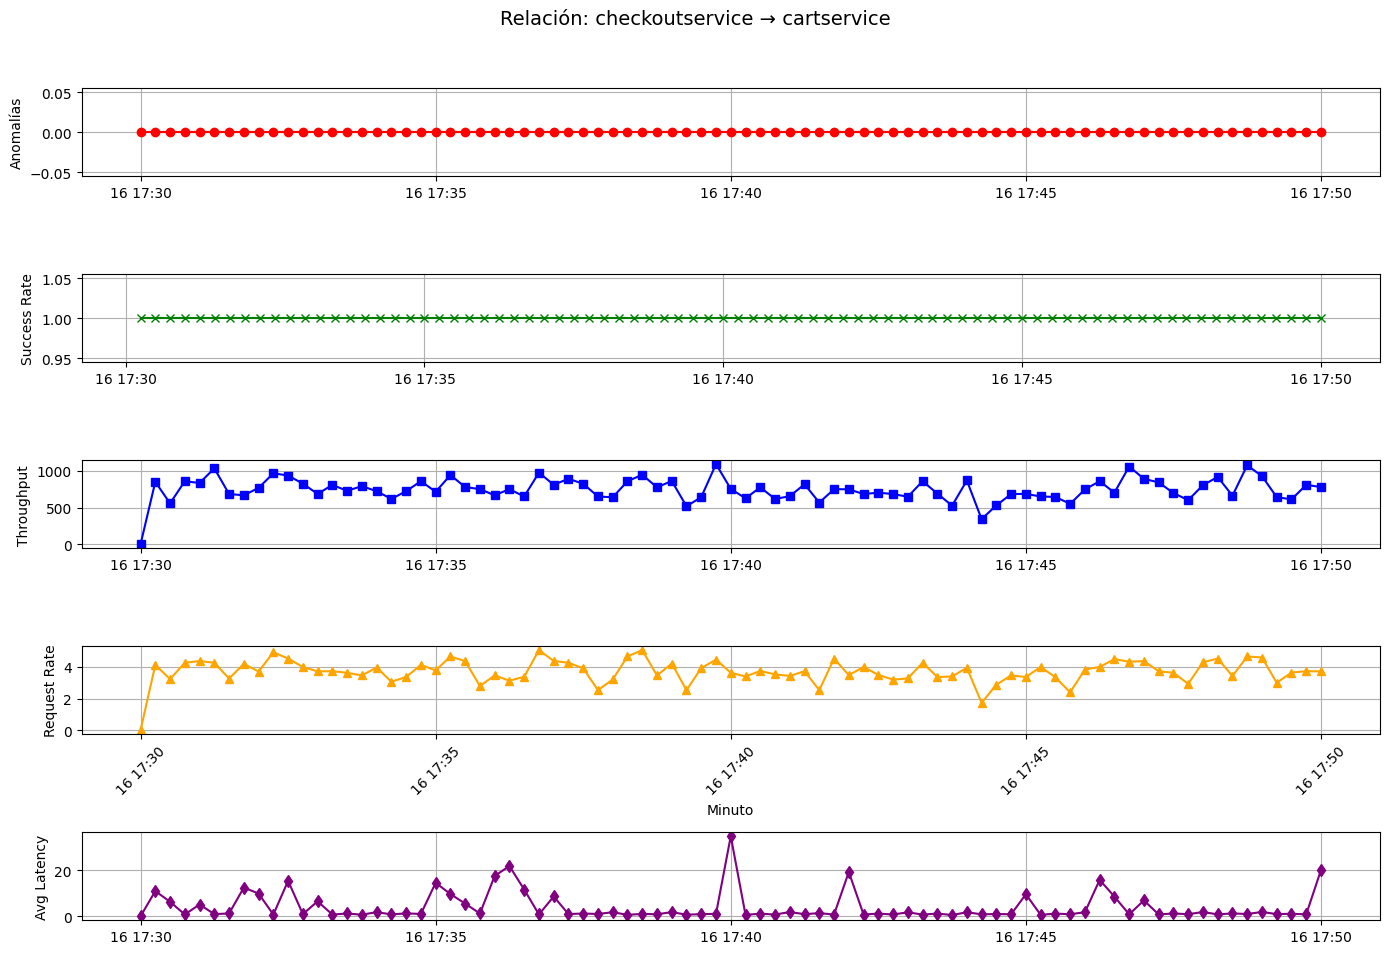

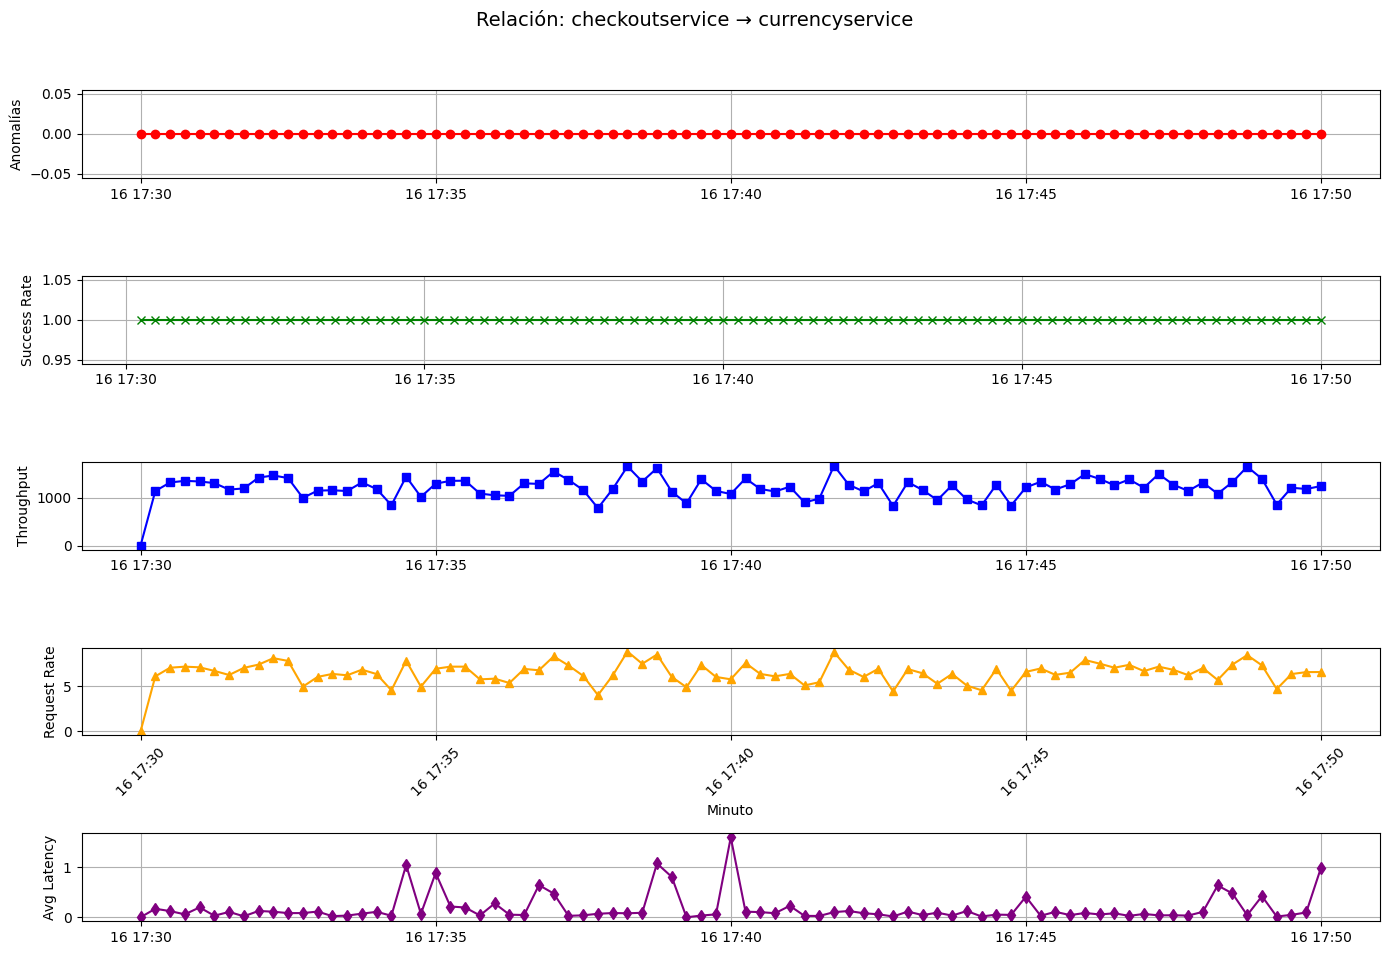

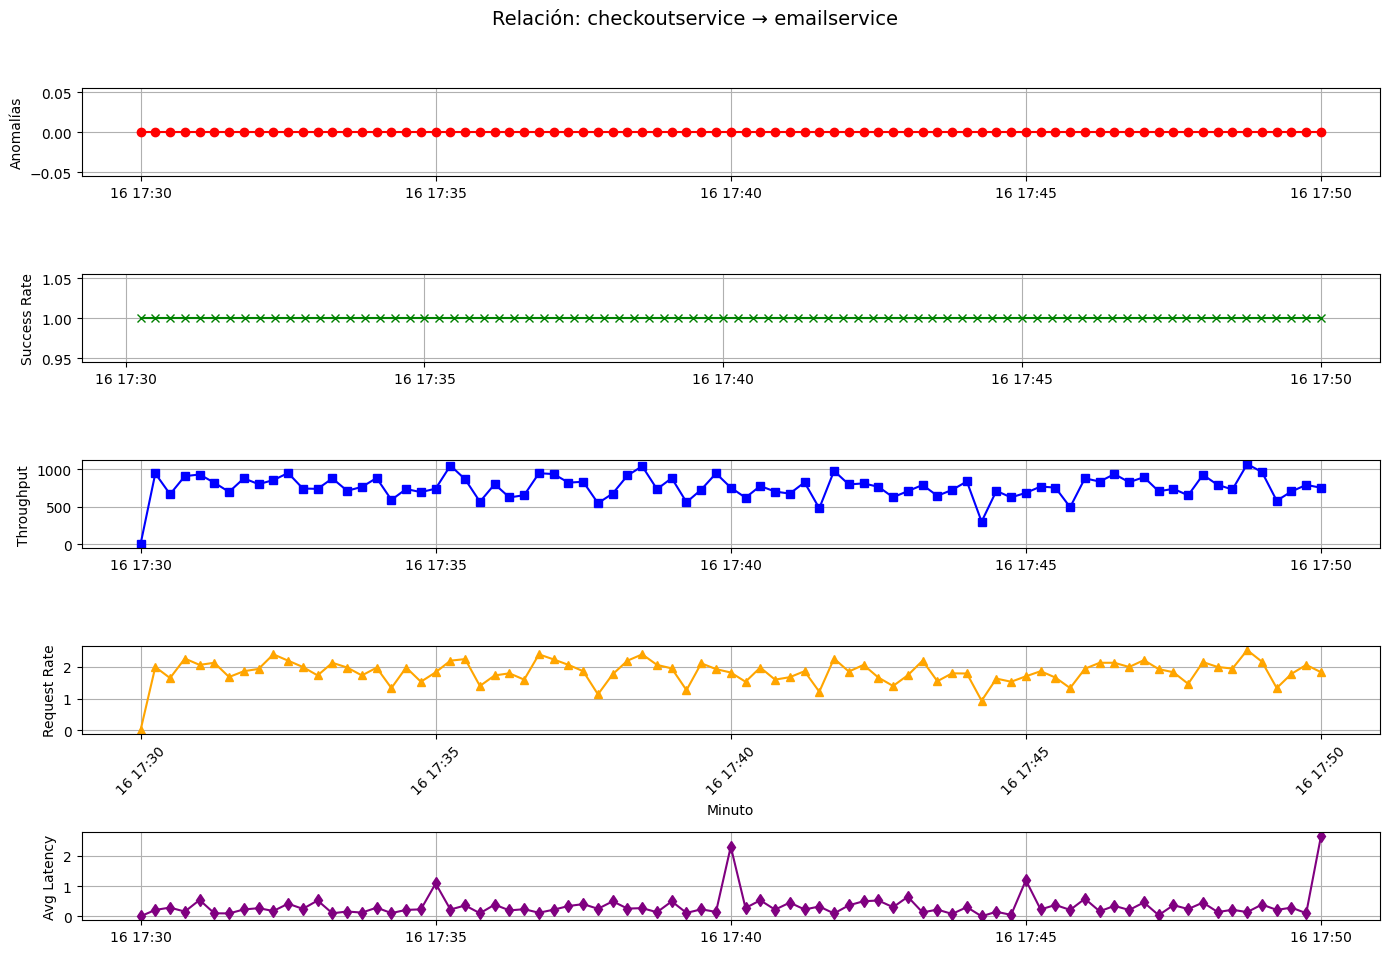

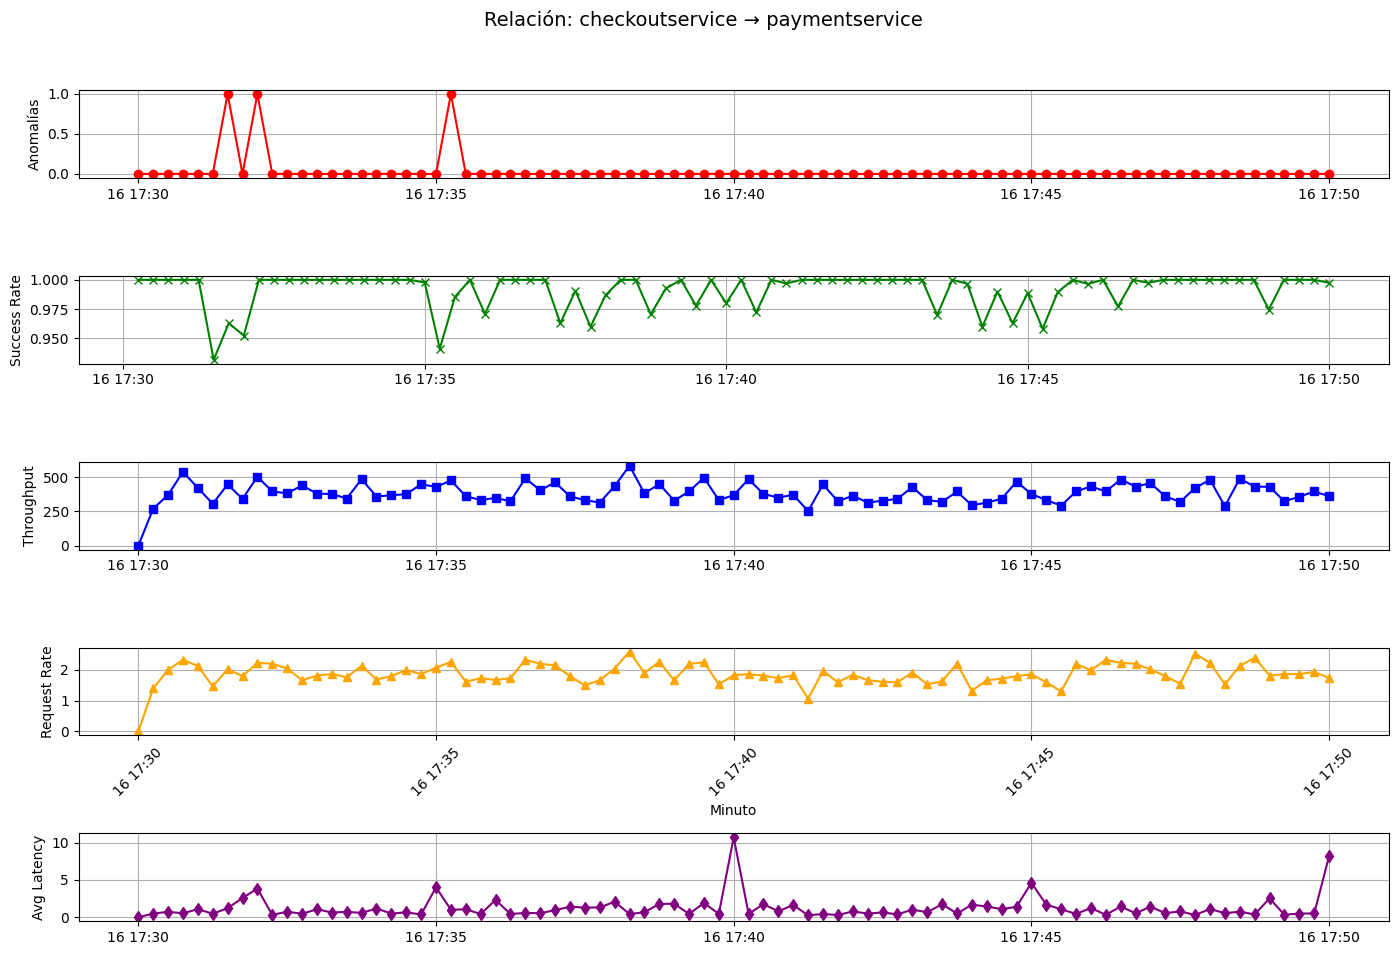

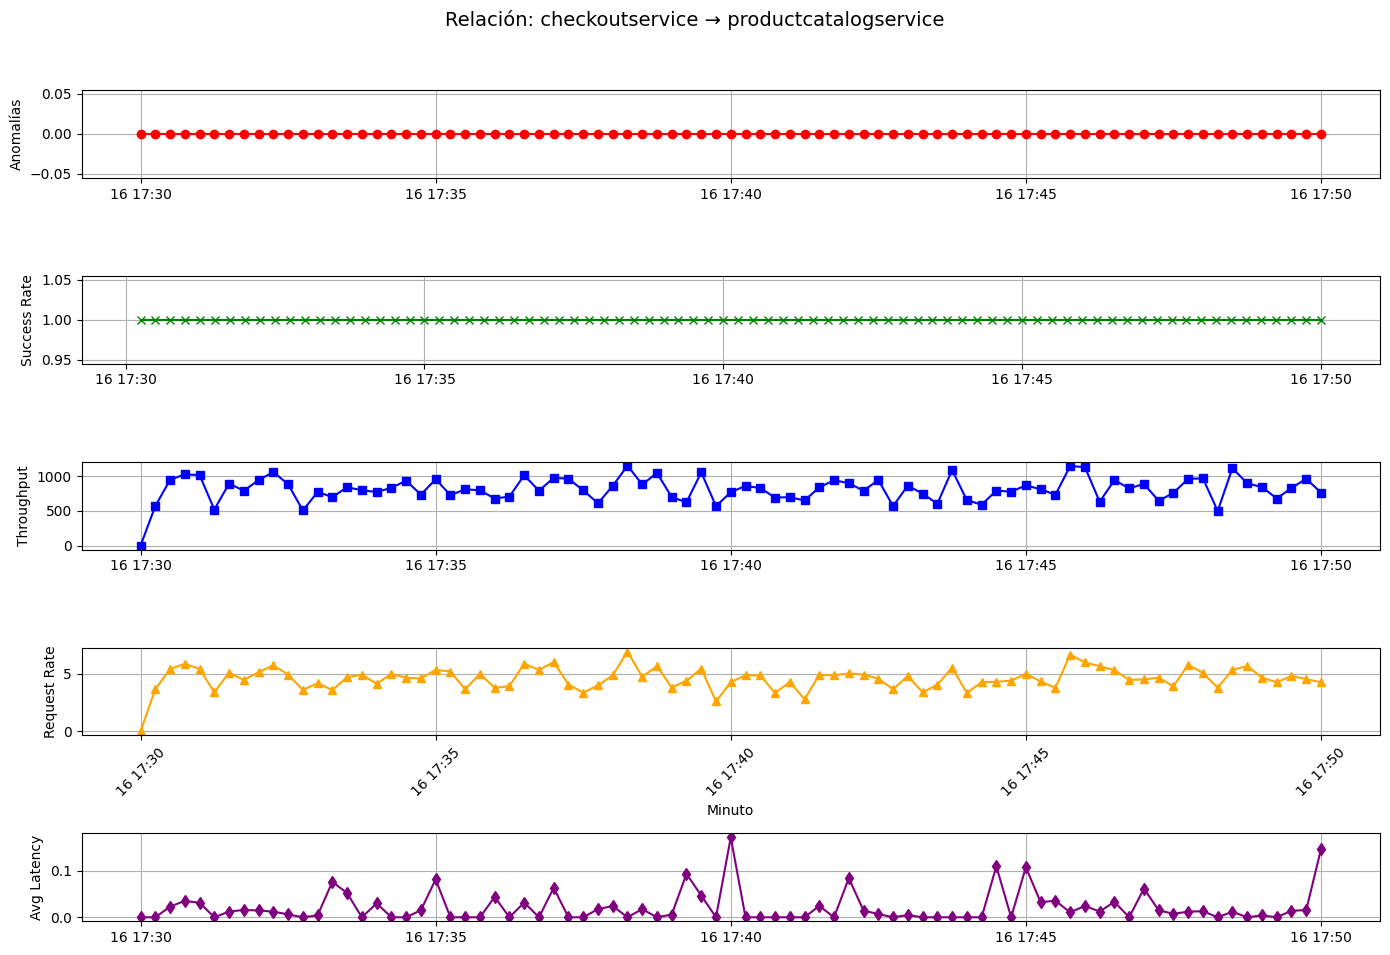

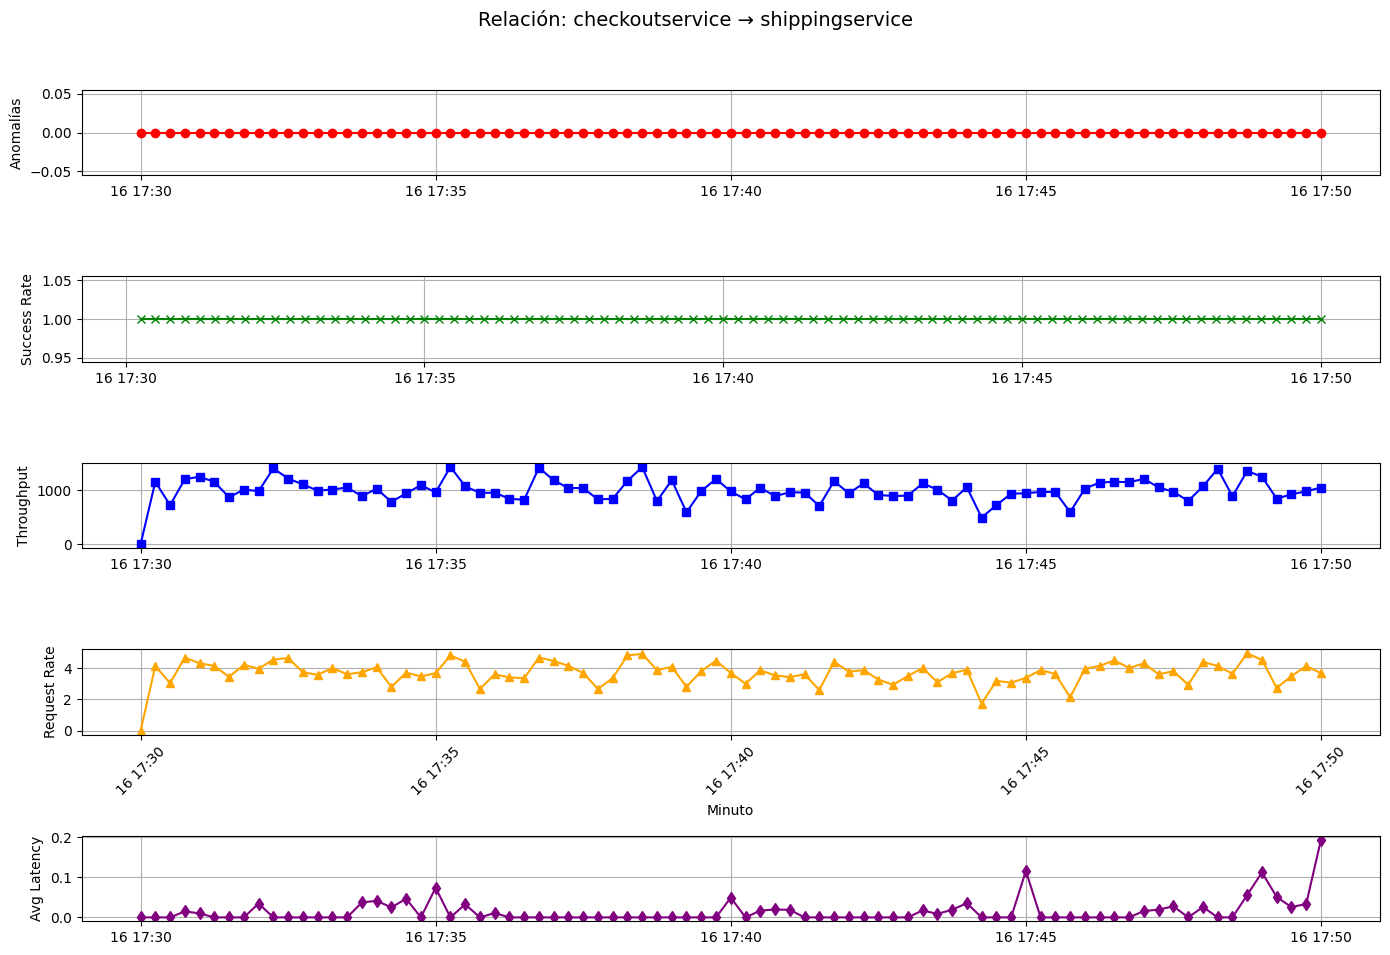

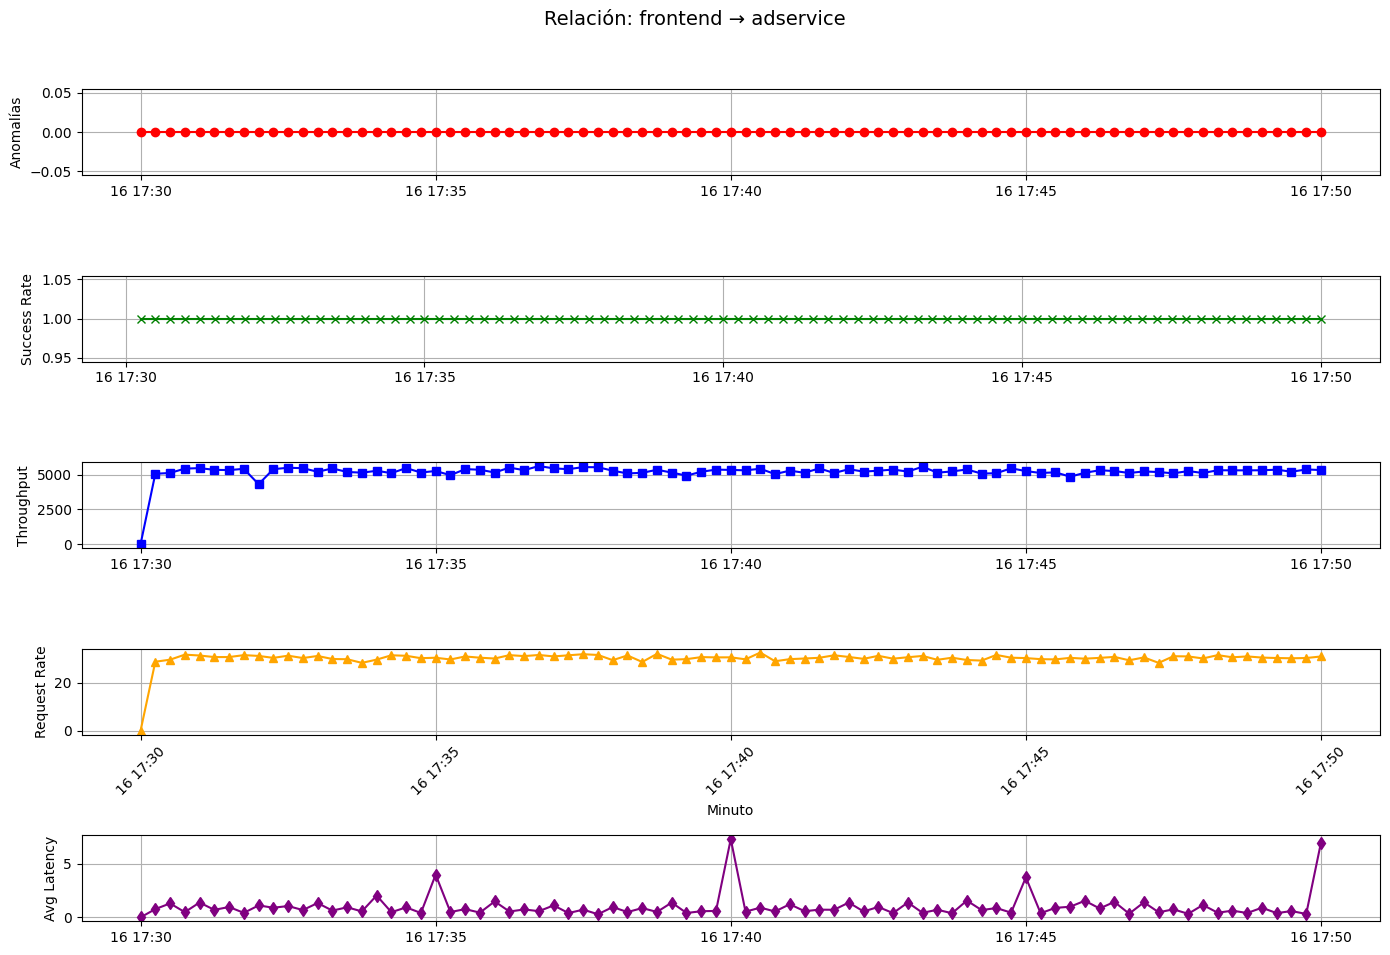

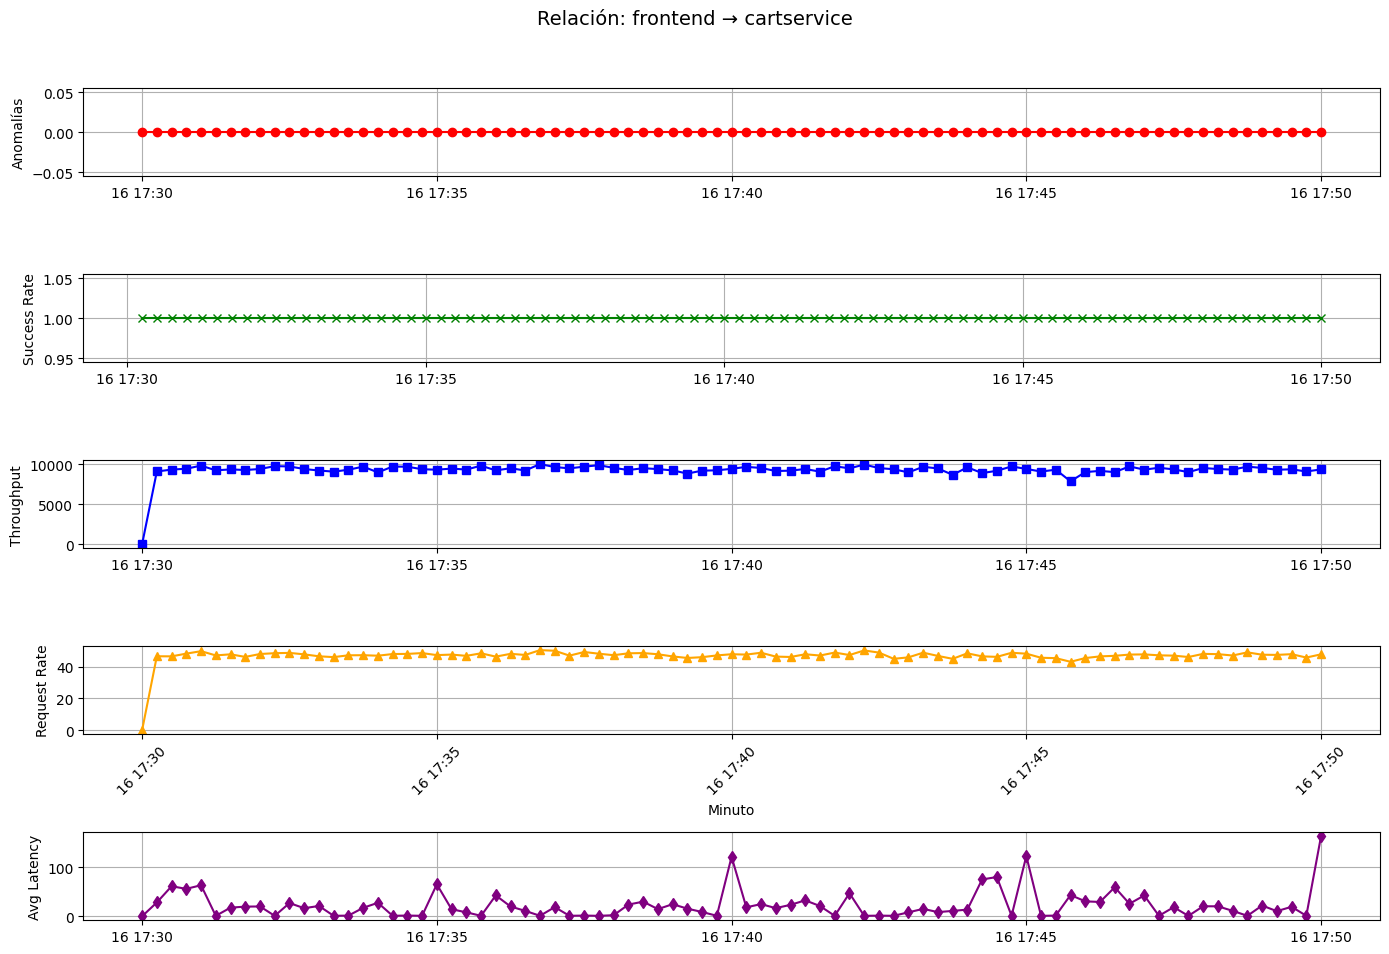

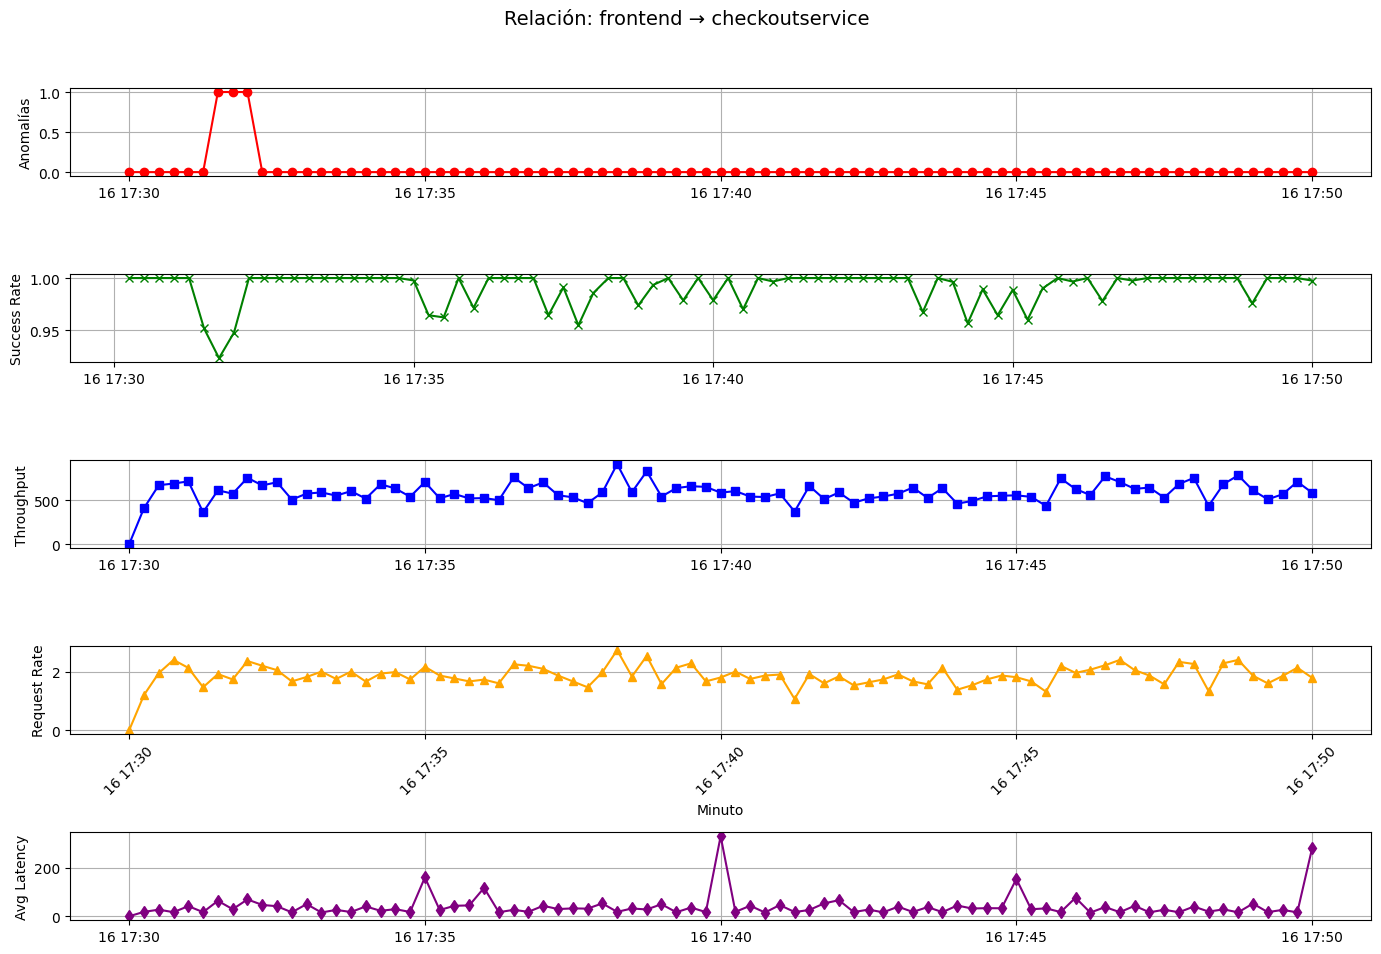

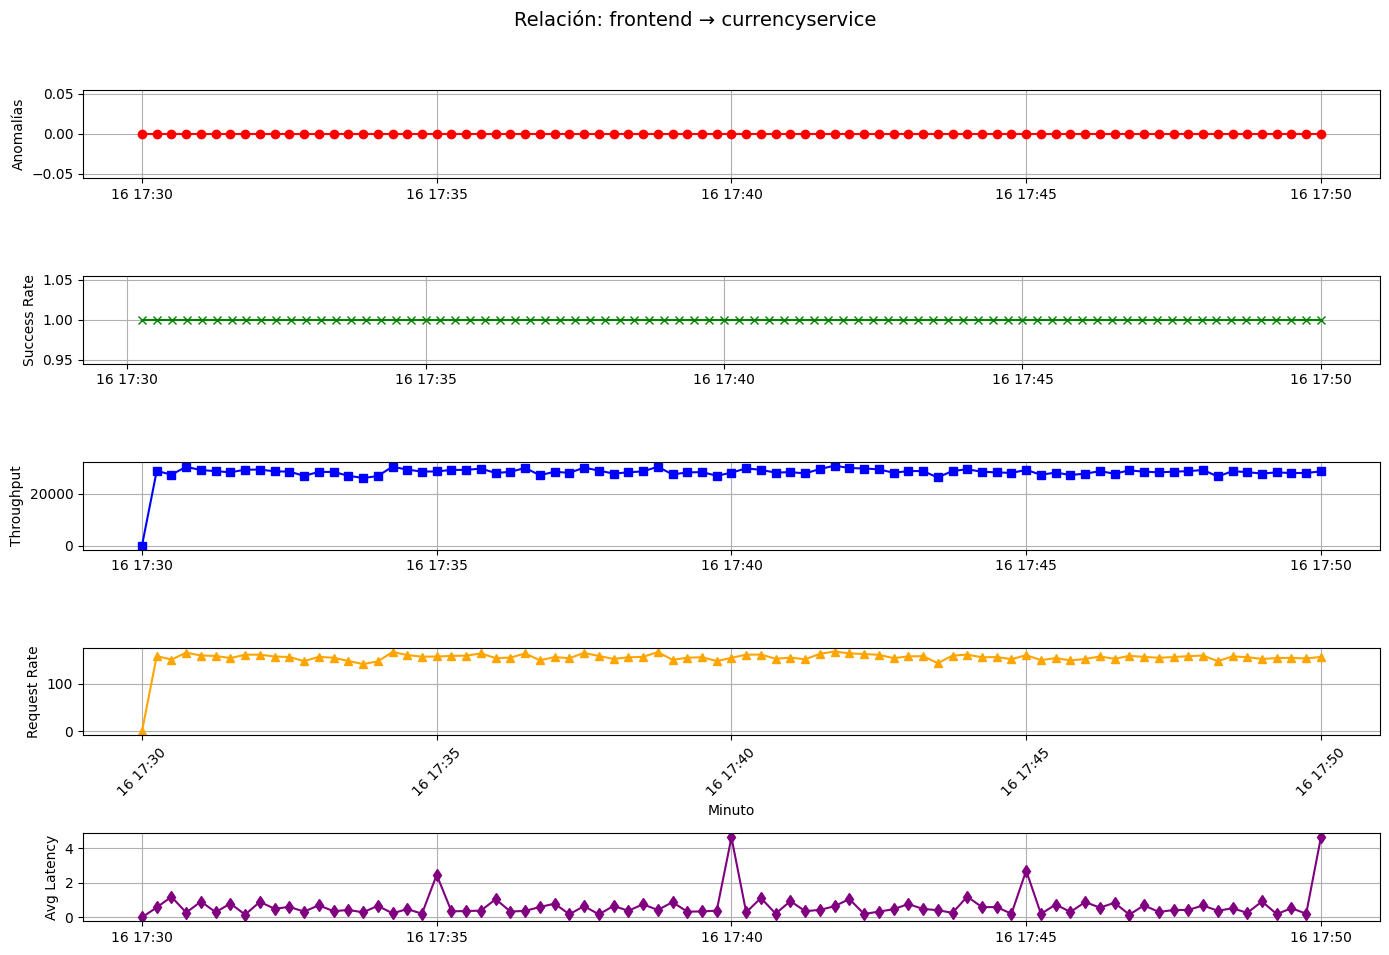

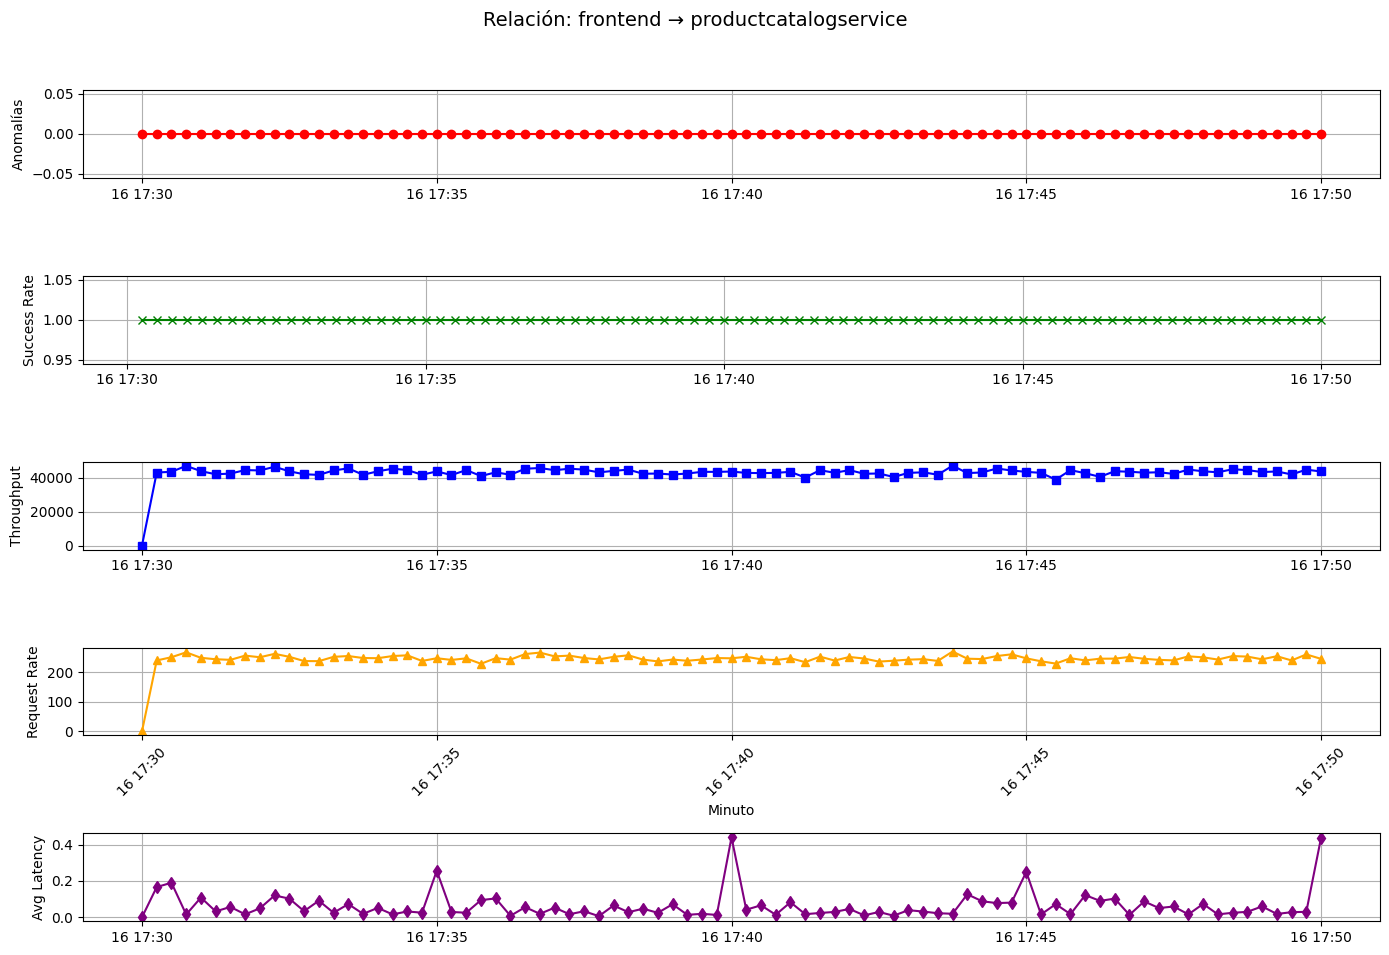

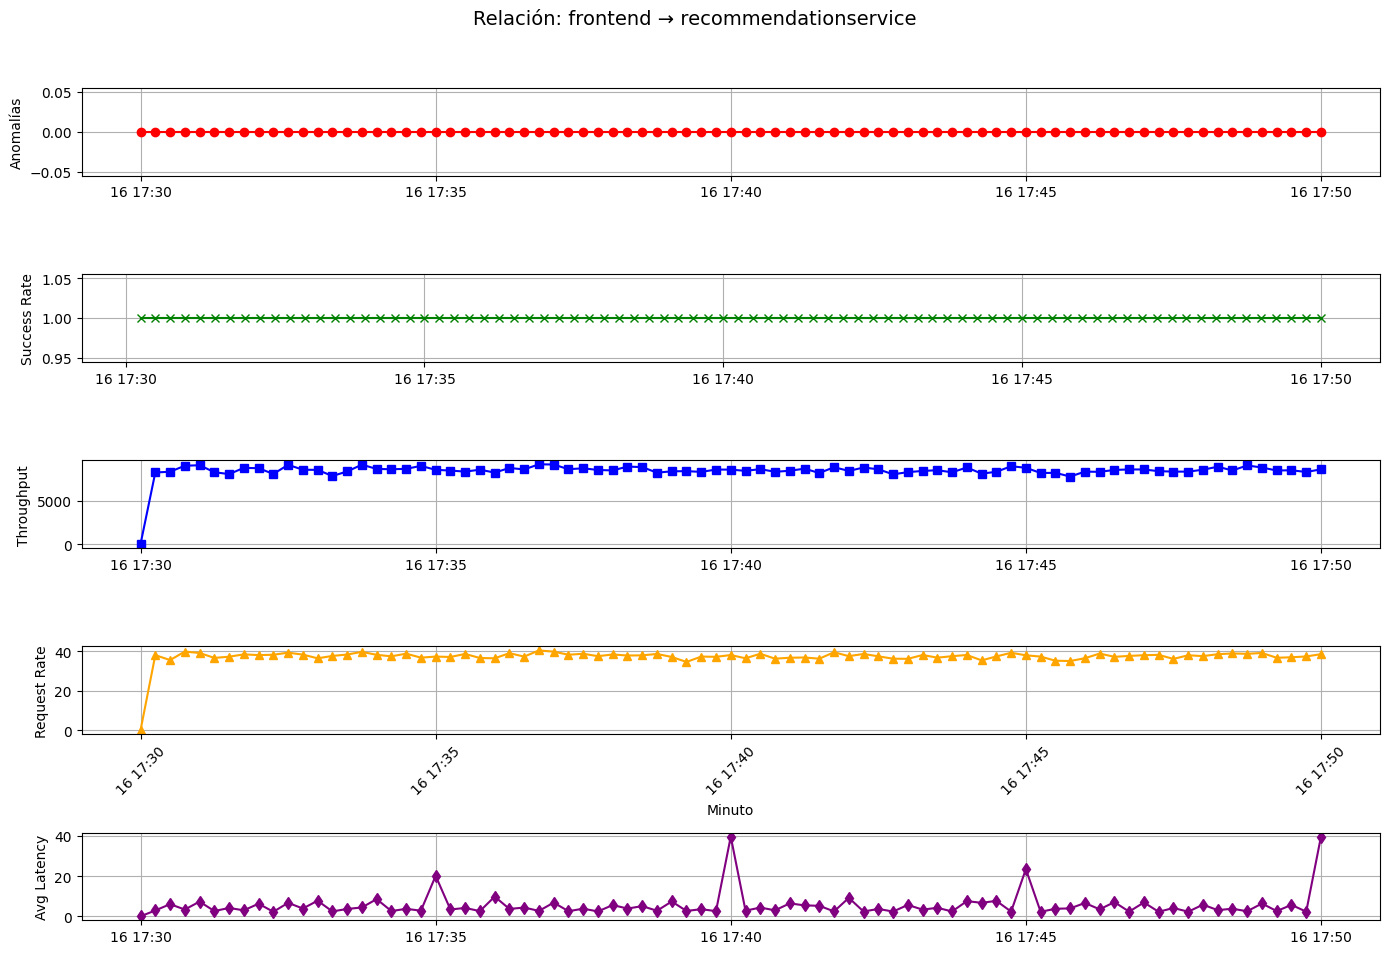

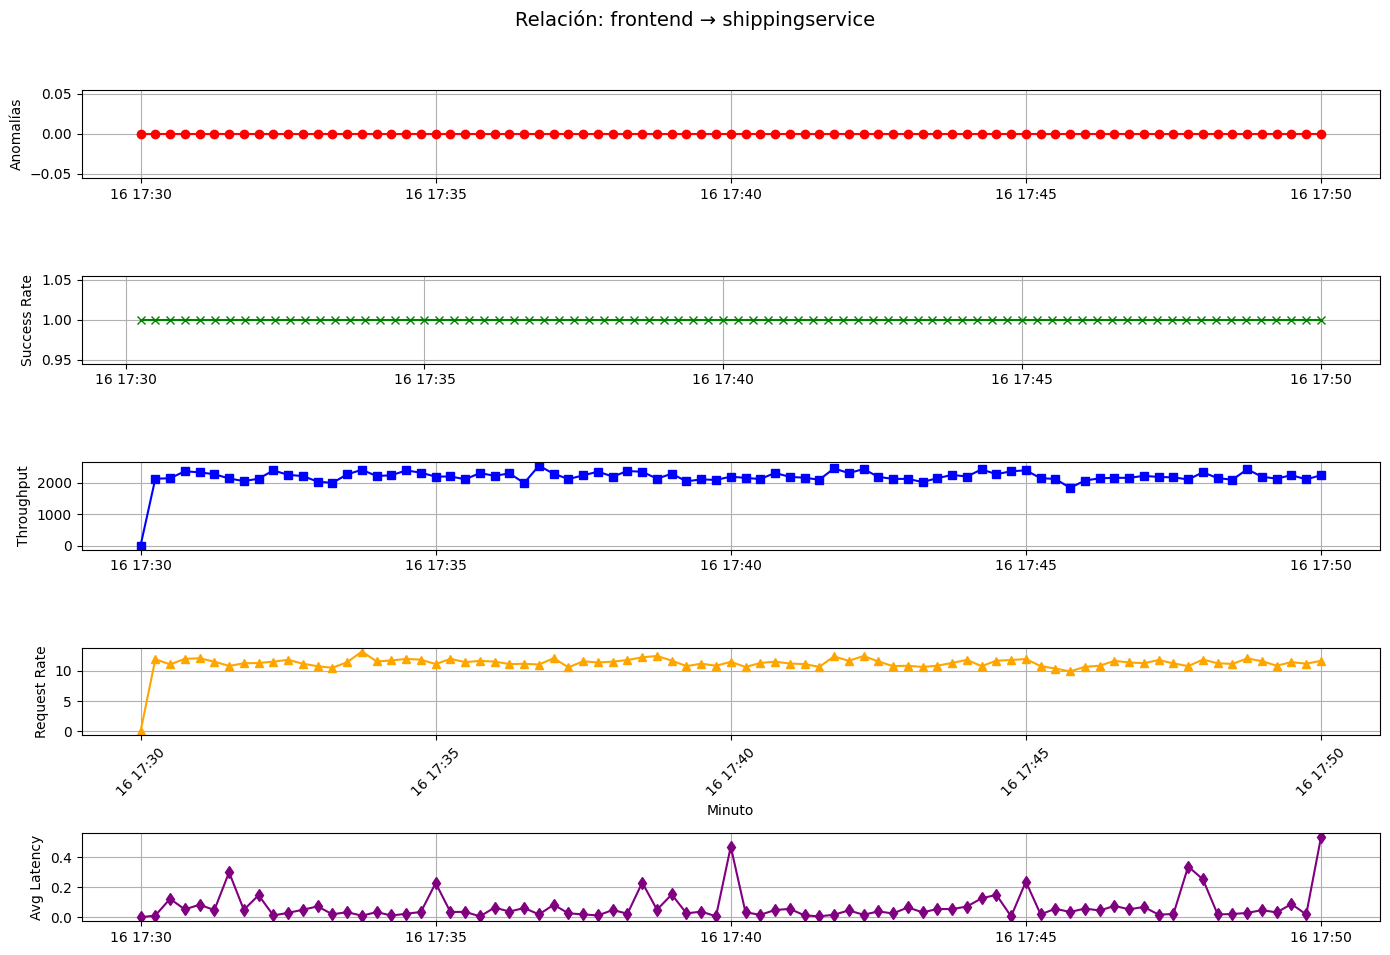

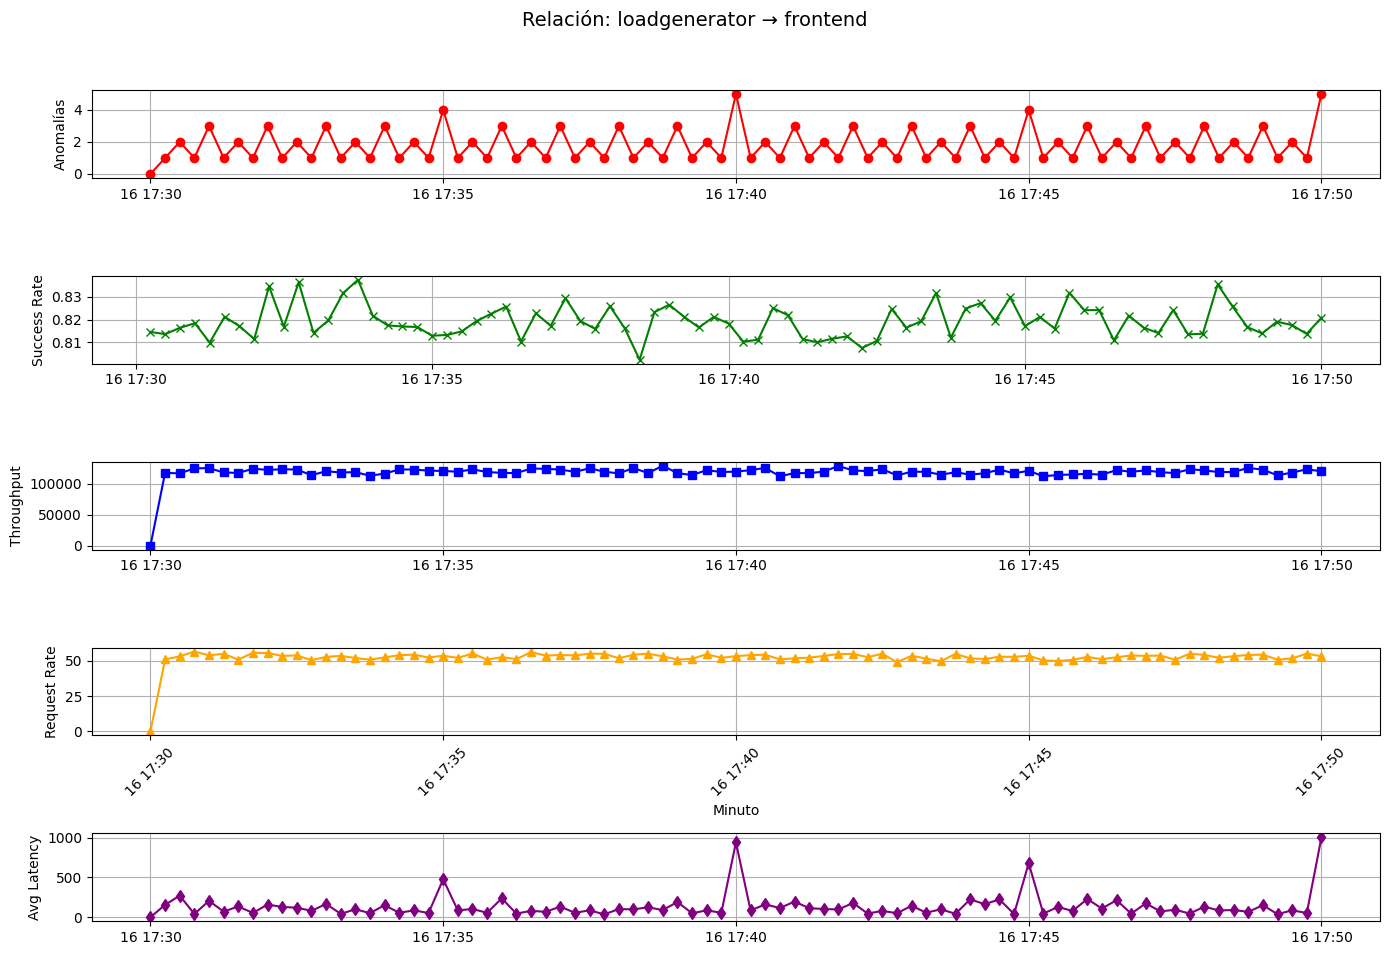

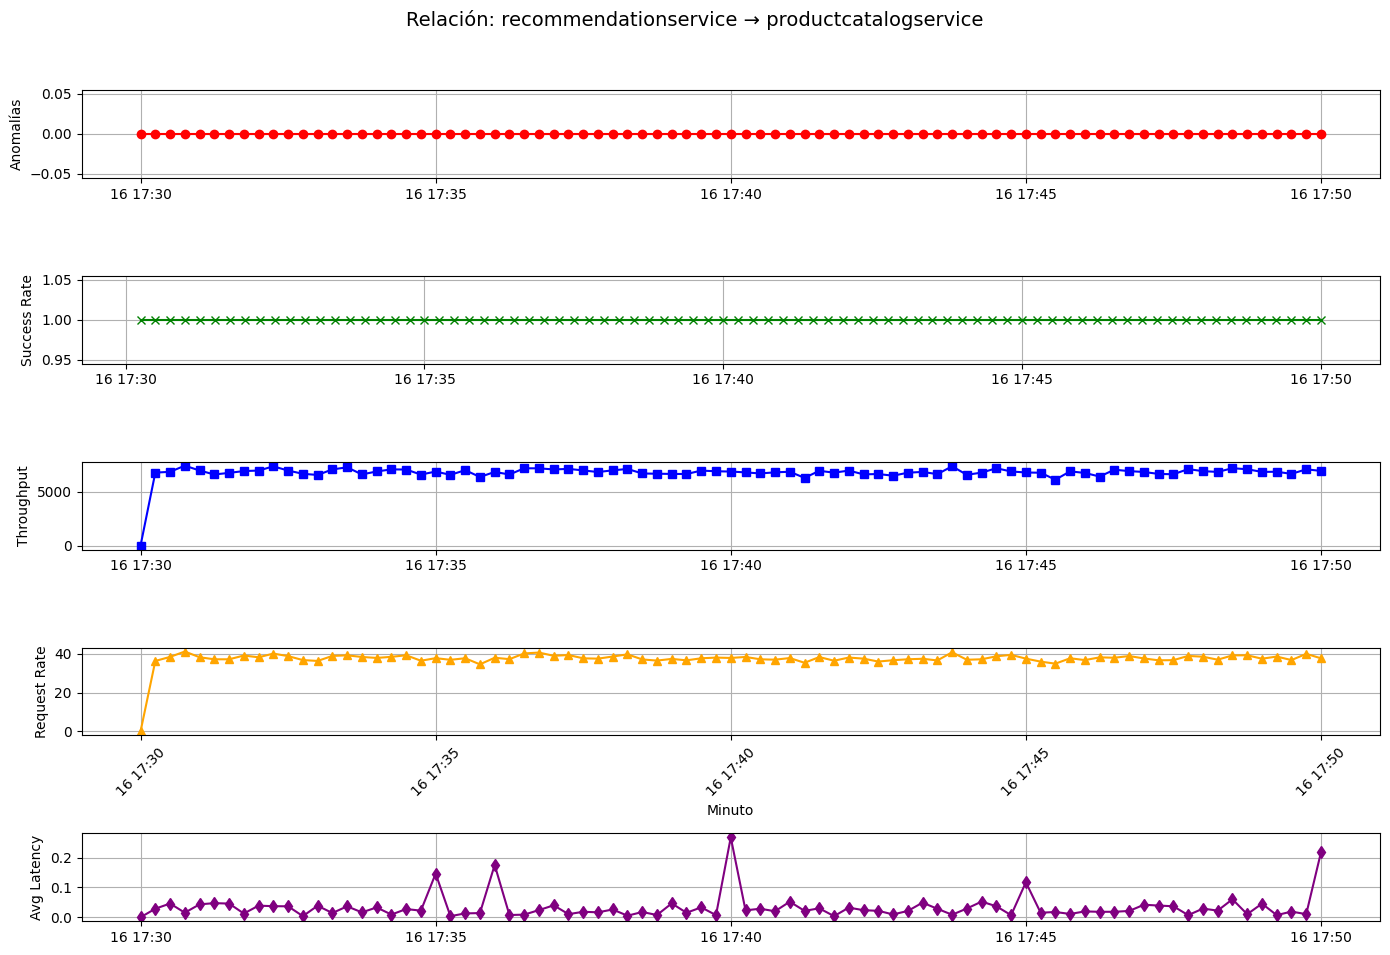

In [ ]:
# Graficas de métricas de rendimiento por relación de trabajo
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Cargar datos
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["minute"] = df["timestamp"].dt.floor("15s")  # agrupar por minuto exacto

# 🎯 Agrupar por source, destination y minuto
grouped = df.groupby(["source_workload", "destination_workload", "minute"])

# 🧠 Agregar métricas
agg = grouped.agg({
    "Abnormality class": lambda x: (x == "Anomalous").sum(),
    "success_rate": "mean",
    "throughput": "mean",
    "request_rate": "mean",
    "average_latency": "mean",
    "istio_request_bytes": "sum"
}).reset_index()

agg.rename(columns={"Abnormality class": "anomaly_count"}, inplace=True)

# 🔁 Generar una gráfica por relación
for (src, dst), sub_df in agg.groupby(["source_workload", "destination_workload"]):
    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Relación: {src} → {dst}", fontsize=14)

    plt.subplot(5, 1, 1)
    plt.plot(sub_df["minute"], sub_df["anomaly_count"], marker="o", color="red")
    plt.ylabel("Anomalías")
    plt.grid(True)

    plt.subplot(5, 1, 2)
    plt.plot(sub_df["minute"], sub_df["success_rate"], marker="x", color="green")
    plt.ylabel("Success Rate")
    plt.grid(True)

    plt.subplot(5, 1, 3)
    plt.plot(sub_df["minute"], sub_df["throughput"], marker="s", color="blue")
    plt.ylabel("Throughput")
    plt.grid(True)

    plt.subplot(5, 1, 4)
    plt.plot(sub_df["minute"], sub_df["request_rate"], marker="^", color="orange")
    plt.ylabel("Request Rate")
    plt.xlabel("Minuto")
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(sub_df["minute"], sub_df["average_latency"], marker="d", color="purple")
    plt.ylabel("Avg Latency")
    plt.grid(True)

    # plt.subplot(6, 1, 6)
    # plt.plot(sub_df["minute"], sub_df["istio_request_bytes"], marker="d", color="yellow")
    # plt.ylabel("istio_request_bytes")
    # plt.grid(True)

    

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
 # Crear una animación de las métricas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Cargar datos procesados
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["minute"] = df["timestamp"].dt.floor("15s")

# Agrupar por source, destination y minuto
grouped = df.groupby(["source_workload", "destination_workload", "minute"]).agg({
    "Abnormality class": lambda x: (x == "Anomalous").sum(),
    "success_rate": "mean",
    "throughput": "mean",
    "request_rate": "mean",
    "average_latency": "mean"
}).reset_index()

grouped.rename(columns={"Abnormality class": "anomaly_count"}, inplace=True)

# Selecciona una relación para el ejemplo (puedes iterar sobre todas si lo deseas)
relations = grouped.groupby(["source_workload", "destination_workload"])
for (src, dst), sub_df in relations:
    sub_df = sub_df.sort_values("minute")
    fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Relación: {src} → {dst}", fontsize=14)

    def update(i):
        for ax in axs:
            ax.clear()
        axs[0].plot(sub_df["minute"][:i+1], sub_df["anomaly_count"][:i+1], marker="o", color="red")
        axs[0].set_ylabel("Anomalías")
        axs[0].grid(True)

        axs[1].plot(sub_df["minute"][:i+1], sub_df["success_rate"][:i+1], marker="x", color="green")
        axs[1].set_ylabel("Success Rate")
        axs[1].grid(True)

        axs[2].plot(sub_df["minute"][:i+1], sub_df["throughput"][:i+1], marker="s", color="blue")
        axs[2].set_ylabel("Throughput")
        axs[2].grid(True)

        axs[3].plot(sub_df["minute"][:i+1], sub_df["request_rate"][:i+1], marker="^", color="orange")
        axs[3].set_ylabel("Request Rate")
        axs[3].grid(True)

        axs[4].plot(sub_df["minute"][:i+1], sub_df["average_latency"][:i+1], marker="d", color="purple")
        axs[4].set_ylabel("Avg Latency")
        axs[4].set_xlabel("Minuto")
        axs[4].grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    ani = FuncAnimation(fig, update, frames=len(sub_df), interval=600, repeat=False)
    gif_name = f"metrics_graph_{src}_{dst}.gif".replace(" ", "_")
    ani.save(gif_name, writer=PillowWriter(fps=2))
    plt.close(fig)
    print(f"GIF guardado: {gif_name}")
    # Si solo quieres un GIF, descomenta la siguiente línea
    # break


GIF guardado: metrics_graph_checkoutservice_cartservice.gif
GIF guardado: metrics_graph_checkoutservice_currencyservice.gif
GIF guardado: metrics_graph_checkoutservice_emailservice.gif
GIF guardado: metrics_graph_checkoutservice_paymentservice.gif
GIF guardado: metrics_graph_checkoutservice_productcatalogservice.gif
GIF guardado: metrics_graph_checkoutservice_shippingservice.gif
GIF guardado: metrics_graph_frontend_adservice.gif
GIF guardado: metrics_graph_frontend_cartservice.gif
GIF guardado: metrics_graph_frontend_checkoutservice.gif
GIF guardado: metrics_graph_frontend_currencyservice.gif
GIF guardado: metrics_graph_frontend_productcatalogservice.gif
GIF guardado: metrics_graph_frontend_recommendationservice.gif
GIF guardado: metrics_graph_frontend_shippingservice.gif
GIF guardado: metrics_graph_loadgenerator_frontend.gif
GIF guardado: metrics_graph_recommendationservice_productcatalogservice.gif


In [ ]:
#🔍 Relaciones con anomalías detectadas en el CSV:
# Cargar datos
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["minute"] = df["timestamp"].dt.floor("T")

# Validar coherencia por minuto y par origen-destino
check = df[df["Abnormality class"] == "Anomalous"] \
    .groupby(["source_workload", "destination_workload", "minute"]) \
    .size().reset_index(name="true_anomalies")

# Mostrar relaciones con anomalías reales
print("🔍 Relaciones con anomalías detectadas en el CSV:")
print(check.sort_values("true_anomalies", ascending=False).head(100))


🔍 Relaciones con anomalías detectadas en el CSV:
    source_workload destination_workload              minute  true_anomalies
15    loadgenerator             frontend 2025-04-16 17:40:00               9
10    loadgenerator             frontend 2025-04-16 17:35:00               8
20    loadgenerator             frontend 2025-04-16 17:45:00               8
7     loadgenerator             frontend 2025-04-16 17:32:00               7
14    loadgenerator             frontend 2025-04-16 17:39:00               7
13    loadgenerator             frontend 2025-04-16 17:38:00               7
12    loadgenerator             frontend 2025-04-16 17:37:00               7
6     loadgenerator             frontend 2025-04-16 17:31:00               7
8     loadgenerator             frontend 2025-04-16 17:33:00               7
9     loadgenerator             frontend 2025-04-16 17:34:00               7
17    loadgenerator             frontend 2025-04-16 17:42:00               7
18    loadgenerator        

C:\Users\marti\AppData\Local\Temp\ipykernel_19172\1051250239.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["minute"] = df["timestamp"].dt.floor("T")


In [ ]:

import pandas as pd
from pyvis.network import Network

# Cargar el CSV procesado
file = "results/kiali_kpi_metrics_processed.csv"
df = pd.read_csv(file, parse_dates=["timestamp"])

# Definir las ventanas temporales
window1 = ("2025-04-16 17:30:00", "2025-04-16 17:35:00")
window2 = ("2025-04-16 17:40:00", "2025-04-16 17:45:00")

for i, (start, end) in enumerate([window1, window2], 1):
    df_win = df[df["timestamp"].between(start, end)]
    print(f"Ventana {i}: {start} a {end}")
    print("Resumen de clases:")
    print(df_win["Abnormality class"].value_counts())
    print("\nEnlaces (source → destination, clase):")
    for idx, row in df_win.iterrows():
        print(f"{row['source_workload']} → {row['destination_workload']} : {row['Abnormality class']}")
    print("\n---\n")

def get_edge_color_by_abnormality(ab_class):
    if ab_class == "Anomalous":
        return "red"
    elif ab_class == "Normal":
        return "green"
    else:
        return "gray"

def create_pyvis_graph(df_window, window_label):
    net = Network(height='500px', width='1000px', notebook=True, directed=True)
    net.toggle_physics(False)  # Fijar nodos
    added_nodes = set()
    for _, row in df_window.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        for node in [src, dst]:
            if node not in added_nodes:
                net.add_node(
                    node,
                    label=node,
                    title=f"{node}",
                    color="#97C2FC"
                )
                added_nodes.add(node)
        ab_class = row.get("Abnormality class", "Normal")
        edge_color = get_edge_color_by_abnormality(ab_class)
        edge_title = (
            f"Latencia: {row.get('average_latency', 0):.2f} ms<br>"
            f"Clase: {ab_class}"
        )
        net.add_edge(
            src, dst,
            title=edge_title,
            color=edge_color
        )
    filename = f"graph_{window_label.replace(':', '').replace(' ', '_')}_abclass.html"
    net.show(filename)
    print(f"✅ Grafo guardado: {filename}")

# Generar los dos grafos para cada ventana
df_t1 = df[df["timestamp"].between(*window1)]
df_t2 = df[df["timestamp"].between(*window2)]

if len(df_t1) > 0:
    label1 = f"{window1[0]}_{window1[1]}"
    create_pyvis_graph(df_t1, label1)
if len(df_t2) > 0:
    label2 = f"{window2[0]}_{window2[1]}"
    create_pyvis_graph(df_t2, label2)


Ventana 1: 2025-04-16 17:30:00 a 2025-04-16 17:35:00
Resumen de clases:
Abnormality class
Normal       574
Anomalous     41
Name: count, dtype: int64

Enlaces (source → destination, clase):
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice : Normal
checkoutservice → cartservice 

In [ ]:
import pandas as pd

# Cargar datos de comunicación y recursos
comm_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")
res_df = pd.read_csv("results/final2_modified_sorted.csv")

# ======================
# Crear nodos de microservicio
# ======================
ms_nodes = comm_df.copy()
ms_nodes["id"] = ms_nodes["source_workload"]
ms_nodes["layer"] = "Microservice"
ms_nodes["timestamp"] = pd.to_datetime(ms_nodes["timestamp"])
ms_nodes = ms_nodes[[
    "id", "timestamp", "layer", "success_rate", "error_rate", "request_rate",
    "throughput", "average_latency", "Abnormality class"
]].drop_duplicates()

# ======================
# Crear nodos de pods
# ======================
pod_nodes = res_df.copy()
pod_nodes["id"] = pod_nodes["pod"]
pod_nodes["layer"] = "Pod"
pod_nodes["timestamp"] = pd.to_datetime(pod_nodes["timestamp"])
pod_nodes = pod_nodes[[
    "id", "timestamp", "layer", "container_cpu_usage_seconds_total",
    "container_memory_working_set_bytes", "container_network_transmit_packets_total",
    "Abnormality class"
]].drop_duplicates()

# ======================
# Unir y exportar nodos
# ======================
fused_nodes = pd.concat([ms_nodes, pod_nodes], ignore_index=True)
fused_nodes.to_csv("fused_nodes.csv", index=False)

# ======================
# Crear edges comunica_con (de Microservice a Microservice)
# ======================
comm_edges = comm_df.copy()
comm_edges["timestamp"] = pd.to_datetime(comm_edges["timestamp"])
comm_edges["src"] = comm_edges["source_workload"]
comm_edges["dst"] = comm_edges["destination_workload"]
comm_edges["edge_type"] = "comunica_con"
comm_edges = comm_edges[[
    "src", "dst", "timestamp", "edge_type", "average_latency", "request_rate",
    "success_rate", "error_rate", "Abnormality class"
]]

# ======================
# Crear edges creado_por (de Pod a Microservice)
# ======================
res_edges = res_df.copy()
res_edges["timestamp"] = pd.to_datetime(res_edges["timestamp"])
res_edges["src"] = res_edges["pod"]
res_edges["dst"] = res_edges["Microservice"]
res_edges["edge_type"] = "creado_por"
res_edges = res_edges[["src", "dst", "timestamp", "edge_type"]].dropna()

# ======================
# Unir y exportar edges
# ======================
fused_edges = pd.concat([comm_edges, res_edges], ignore_index=True)
fused_edges.to_csv("fused_edges.csv", index=False)


In [ ]:
from raphtory import Graph
import time
import os
import shutil


g = Graph()

# --- Añadir microservicios como nodos ---
for _, row in comm_df.iterrows():
    ts = int(pd.to_datetime(row["timestamp"]).timestamp() * 1000)
    ms_name = row["source_workload"]

    # Remove None values from properties
    ms_props = {
        "layer": "Microservicio",
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "request_rate": row.get("request_rate"),
        "throughput": row.get("throughput"),
        "average_latency": row.get("average_latency"),
        "abnormality": row.get("Abnormality class")
    }
    ms_props = {k: v for k, v in ms_props.items() if v is not None}
    g.add_node(ts, ms_name, node_type="Microservice", properties=ms_props)

    ms_dst = row["destination_workload"]
    g.add_node(ts, ms_dst, node_type="Microservice", properties={"layer": "Microservicio"})

    edge_props = {
        "edge_type": "comunica_con",
        "latency": row.get("latency"),
        "request_rate": row.get("request_rate"),
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "abnormality": row.get("Abnormality class"),
        "protocol": row.get("protocol")
    }
    edge_props = {k: v for k, v in edge_props.items() if v is not None}
    g.add_edge(ts, ms_name, ms_dst, properties=edge_props)

# --- Añadir pods como nodos y relaciones creado_por ---
for _, row in res_df.iterrows():
    ts = int(pd.to_datetime(row["timestamp"]).timestamp() * 1000)
    pod = row["pod"]
    service = row["Microservice"]

    g.add_node(ts, pod, node_type="Pod", properties={
        "layer": "Pod",
        "container_cpu_usage_seconds_total": row.get("container_cpu_usage_seconds_total", None),
        "container_memory_working_set_bytes": row.get("container_memory_working_set_bytes", None),
        "container_network_transmit_bytes_total": row.get("container_network_transmit_packets_total", None),
        "abnormality": row.get("Abnormality class", None)
    })

    g.add_edge(ts, pod, service, properties={
        "edge_type": "creado_por"
    })

# Guardar el grafo
output_path = "graphs/kiali_fused_graph"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs/", exist_ok=True)
g.save_to_file("graphs/kiali_fused_graph")
print("✅ Grafo fusionado guardado en:", output_path)


✅ Grafo fusionado guardado en: graphs/kiali_fused_graph


In [ ]:
import pandas as pd

# Cargar CSVs
comm_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")
res_df = pd.read_csv("results/final2_modified_sorted.csv")

# =====================================
# 🟦 Crear nodos de Microservicios
# =====================================
ms_nodes = comm_df.copy()
ms_nodes["id"] = ms_nodes["source_workload"]
ms_nodes["layer"] = "Microservice"
ms_nodes["timestamp"] = pd.to_datetime(ms_nodes["timestamp"])
ms_nodes = ms_nodes[[
    "id", "timestamp", "layer", "success_rate", "error_rate", "request_rate",
    "throughput", "average_latency", "Abnormality class"
]].drop_duplicates()

# También considerar los microservicios desde la capa de recursos (instance)
ms_from_resource = res_df[["instance", "timestamp"]].copy()
ms_from_resource = ms_from_resource.rename(columns={"instance": "id"})
ms_from_resource["layer"] = "Microservice"
ms_from_resource["timestamp"] = pd.to_datetime(ms_from_resource["timestamp"])
ms_from_resource = ms_from_resource.drop_duplicates()

# Unir microservicios de ambas fuentes
ms_nodes = pd.concat([ms_nodes, ms_from_resource], ignore_index=True).drop_duplicates(subset=["id", "timestamp"])

# =====================================
# 🟧 Crear nodos de Pods
# =====================================
pod_nodes = res_df.copy()
pod_nodes["id"] = pod_nodes["pod"]
pod_nodes["layer"] = "Pod"
pod_nodes["timestamp"] = pd.to_datetime(pod_nodes["timestamp"])
pod_nodes = pod_nodes[[
    "id", "timestamp", "layer",
    "container_cpu_usage_seconds_total",
    "container_memory_working_set_bytes",
    "container_network_transmit_packets_total",
    "Abnormality class"
]].drop_duplicates()

# =====================================
# 🔷 Exportar nodos fusionados
# =====================================
fused_nodes = pd.concat([ms_nodes, pod_nodes], ignore_index=True)
fused_nodes.to_csv("fused_nodes.csv", index=False)

# =====================================
# 🔁 Aristas comunica_con
# =====================================
comm_edges = comm_df.copy()
comm_edges["timestamp"] = pd.to_datetime(comm_edges["timestamp"])
comm_edges["src"] = comm_edges["source_workload"]
comm_edges["dst"] = comm_edges["destination_workload"]
comm_edges["edge_type"] = "comunica_con"
comm_edges = comm_edges[[
    "src", "dst", "timestamp", "edge_type", "average_latency", "request_rate",
    "success_rate", "error_rate", "Abnormality class"
]]

# =====================================
# 🔁 Aristas creado_por (de Pod a Microservicio según instance)
# =====================================
res_edges = res_df.copy()
res_edges["timestamp"] = pd.to_datetime(res_edges["timestamp"])
res_edges["src"] = res_edges["pod"]
res_edges["dst"] = res_edges["instance"]  # Aquí está la clave
res_edges["edge_type"] = "creado_por"
res_edges = res_edges[["src", "dst", "timestamp", "edge_type"]].dropna()

# =====================================
# 📦 Exportar aristas
# =====================================
fused_edges = pd.concat([comm_edges, res_edges], ignore_index=True)
fused_edges.to_csv("fused_edges.csv", index=False)

print("✅ CSVs fusionados generados correctamente.")


✅ CSVs fusionados generados correctamente.


In [ ]:
from raphtory import Graph
import pandas as pd
import os
import shutil

# Cargar nodos y aristas
nodes_df = pd.read_csv("fused_nodes.csv", parse_dates=["timestamp"])
edges_df = pd.read_csv("fused_edges.csv", parse_dates=["timestamp"])

# Inicializar grafo
g = Graph()

# ========================================
# Añadir nodos
# ========================================
for _, row in nodes_df.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    node_id = row["id"]
    layer = row["layer"]

    # Crear propiedades de nodo filtrando valores válidos
    node_props = {
        "layer": layer,
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "request_rate": row.get("request_rate"),
        "throughput": row.get("throughput"),
        "average_latency": row.get("average_latency"),
        "abnormality": row.get("Abnormality class"),
        "container_cpu_usage_seconds_total": row.get("container_cpu_usage_seconds_total"),
        "container_memory_working_set_bytes": row.get("container_memory_working_set_bytes"),
        "container_network_transmit_packets_total": row.get("container_network_transmit_packets_total")
    }
    node_props = {k: v for k, v in node_props.items() if pd.notna(v)}
    g.add_node(ts, node_id, node_type=layer, properties=node_props)

# ========================================
# Añadir aristas
# ========================================
for _, row in edges_df.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    src = row["src"]
    dst = row["dst"]
    edge_type = row["edge_type"]

    edge_props = {
        "edge_type": edge_type,
        "latency": row.get("average_latency"),
        "request_rate": row.get("request_rate"),
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "abnormality": row.get("Abnormality class")
    }
    edge_props = {k: v for k, v in edge_props.items() if pd.notna(v)}
    g.add_edge(ts, src, dst, properties=edge_props)

# ========================================
# Guardar grafo
# ========================================
output_path = "graphs/kiali_fused_graph_2"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs/", exist_ok=True)

g.save_to_file(output_path)
print("✅ Grafo completo creado y guardado en:", output_path)


C:\Users\marti\AppData\Local\Temp\ipykernel_12744\811035917.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv("fused_edges.csv", parse_dates=["timestamp"])


✅ Grafo completo creado y guardado en: graphs/kiali_fused_graph_2


In [ ]:
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv('results/final2_modified_sorted.csv')
# Eliminar nodos duplicados por 'id' (instance y pod) y conservar solo el primer timestamp
unique_instances = df[['instance']].drop_duplicates()
unique_pods = df[['pod']].drop_duplicates()
all_nodes = pd.concat([unique_instances.rename(columns={'instance': 'id'}), unique_pods.rename(columns={'pod': 'id'})]).drop_duplicates(subset=['id'])
num_nodes = len(all_nodes)

# Enlaces únicos: pares (instance, pod) sin duplicados
unique_links = df[['instance', 'pod']].drop_duplicates()
num_links = len(unique_links)

print(f"Número total de nodos únicos: {num_nodes}")
print(f"Número total de enlaces únicos (instance-pod): {num_links}")

Número total de nodos únicos: 73
Número total de enlaces únicos (instance-pod): 65


In [ ]:
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv('results/kiali_kpi_metrics_processed.csv')

# Nodos únicos: source_workload y destination_workload
unique_sources = set(df['source_workload'].unique())
unique_destinations = set(df['destination_workload'].unique())
all_nodes = unique_sources.union(unique_destinations)
num_nodes = len(all_nodes)

# Enlaces únicos: pares (source_workload, destination_workload)
unique_links = df[['source_workload', 'destination_workload']].drop_duplicates()
num_links = len(unique_links)

print(f"Número total de nodos únicos: {num_nodes}")
print(f"Número total de enlaces únicos (source-destination): {num_links}")

Número total de nodos únicos: 11
Número total de enlaces únicos (source-destination): 15


In [2]:
from raphtory import Graph
import pandas as pd
import os
import shutil

# Cargar datos
df_comm = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])
df_res = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Inicializar grafo
g = Graph()

# ================================
# 🔷 Añadir nodos de Microservicio y comunica_con
# ================================
for _, row in df_comm.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)

    src = str(row["source_workload"]).strip()
    dst = str(row["destination_workload"]).strip()

    # Nodo origen
    g.add_node(ts, src, node_type="Microservice", properties={
        "layer": "Microservice",
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "request_rate": row.get("request_rate"),
        "average_latency": row.get("average_latency"),
        "throughput": row.get("throughput"),
        "abnormality": row.get("Abnormality class")
    })

    # Nodo destino (sin duplicar propiedades)
    g.add_node(ts, dst, node_type="Microservice", properties={
        "layer": "Microservice",
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "request_rate": row.get("request_rate"),
        "average_latency": row.get("average_latency"),
        "throughput": row.get("throughput"),
        "abnormality": row.get("Abnormality class")
    })

    # Arista comunica_con
    g.add_edge(ts, src, dst, properties={
        "edge_type": "comunica_con",
        "latency": row.get("average_latency"),
        "request_rate": row.get("request_rate"),
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "throughput": row.get("throughput"),
        "abnormality": row.get("Abnormality class")
    })

# "latency": row.get("average_latency"),
#         "request_rate": row.get("request_rate"),
#         "success_rate": row.get("success_rate"),
#         "error_rate": row.get("error_rate"),
#         "abnormality": row.get("Abnormality class"),

# ================================
# 🟩 Añadir nodos de Pod y creado_por (instance → pod)
# ================================
for _, row in df_res.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)

    micro = str(row["pod"]).strip()
    pod = str(row["instance"]).strip()

    # Nodo pod
    g.add_node(ts, pod, node_type="Pod", properties={
        "layer": "Pod",
        "container_cpu_usage_seconds_total": row.get("container_cpu_usage_seconds_total"),
        "container_memory_working_set_bytes": row.get("container_memory_working_set_bytes"),
        "container_network_transmit_packets_total": row.get("container_network_transmit_packets_total"),
        "abnormality": row.get("Abnormality class")
    })

    # Nodo instance como Microservicio (si no está ya creado)
    g.add_node(ts, micro, node_type="Microservice", properties={
        "layer": "Microservice",
        "container_cpu_usage_seconds_total": row.get("container_cpu_usage_seconds_total"),
        "container_memory_working_set_bytes": row.get("container_memory_working_set_bytes"),
        "container_network_transmit_packets_total": row.get("container_network_transmit_packets_total"),
        "abnormality": row.get("Abnormality class")
    })

    # Arista creado_por
    g.add_edge(ts, pod, micro, properties={
        "edge_type": "creado_por"
    })

# ================================
# 💾 Guardar el grafo
# ================================
output_path = "graphs/kiali_fused_graph_5_final"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs/", exist_ok=True)
g.save_to_file(output_path)

print(f"✅ Grafo completo fusionado guardado correctamente en: {output_path}")


✅ Grafo completo fusionado guardado correctamente en: graphs/kiali_fused_graph_5_final


In [1]:
from pyvis.network import Network
import pandas as pd

# Cargar CSVs
df_comm = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])
df_res = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Crear grafo Pyvis
net = Network(height="800px", width="100%", directed=True, notebook=True)
net.barnes_hut()

# === Añadir Microservicios y aristas comunica_con ===
for _, row in df_comm.iterrows():
    src = str(row["source_workload"]).strip()
    dst = str(row["destination_workload"]).strip()

    # Tooltip con propiedades
    tooltip = (
        f"Request rate: {row.get('request_rate')}<br>"
        f"Latency: {row.get('average_latency')}<br>"
        f"Error rate: {row.get('error_rate')}<br>"
        f"Success rate: {row.get('success_rate')}<br>"
        f"Throughput: {row.get('throughput')}<br>"
        f"Abnormality: {row.get('Abnormality class')}"
    )

    # Añadir nodos si no existen
    net.add_node(src, label=src, title=tooltip, color="skyblue", shape="ellipse")
    net.add_node(dst, label=dst, title=tooltip, color="skyblue", shape="ellipse")

    # Añadir arista comunica_con
    net.add_edge(src, dst, title="comunica_con", color="black")

# === Añadir Pods y aristas creado_por ===
for _, row in df_res.iterrows():
    pod = str(row["pod"]).strip()
    instance = str(row["instance"]).strip()

    # Tooltip Pod
    pod_info = (
        f"CPU: {row.get('container_cpu_usage_seconds_total')}<br>"
        f"Memory: {row.get('container_memory_working_set_bytes')}<br>"
        f"Packets: {row.get('container_network_transmit_packets_total')}<br>"
        f"Abnormality: {row.get('Abnormality class')}"
    )

    # Añadir nodo Pod
    net.add_node(pod, label=pod, title=pod_info, color="lightgreen", shape="box")

    # Añadir nodo instance (Microservice, si no existía aún)
    net.add_node(instance, label=instance, title="Creador de pod", color="skyblue", shape="ellipse")

    # Añadir arista creado_por
    net.add_edge(pod, instance, title="creado_por", color="gray", dashes=True)

# === Mostrar el grafo ===
net.show("grafo_fusionado_pyvis.html")



grafo_fusionado_pyvis.html


📌 Distribución de clases:
 Abnormality class
Normal       2113
Anomalous     152
Name: count, dtype: int64

🔹 Entrenando: Random Forest
✔️ Accuracy: 0.9978
              precision    recall  f1-score   support

   Anomalous       1.00      0.97      0.98        30
      Normal       1.00      1.00      1.00       423

    accuracy                           1.00       453
   macro avg       1.00      0.98      0.99       453
weighted avg       1.00      1.00      1.00       453


🔹 Entrenando: Decision Tree
✔️ Accuracy: 0.9978
              precision    recall  f1-score   support

   Anomalous       1.00      0.97      0.98        30
      Normal       1.00      1.00      1.00       423

    accuracy                           1.00       453
   macro avg       1.00      0.98      0.99       453
weighted avg       1.00      1.00      1.00       453


🔹 Entrenando: SVM
✔️ Accuracy: 1.0000
              precision    recall  f1-score   support

   Anomalous       1.00      1.00      1.00    

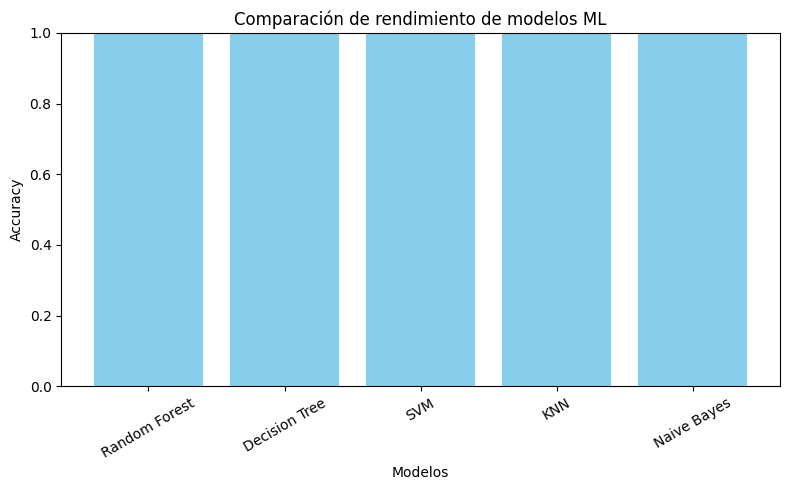

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# 🗂️ Cargar dataset (comunicación o recursos)
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")  # o "results/final2_modified_sorted.csv"

# 🎯 Objetivo: predecir "Abnormality class"
print("📌 Distribución de clases:\n", df["Abnormality class"].value_counts())

# 🧹 Eliminar columnas irrelevantes o no numéricas
X = df.drop(columns=["Abnormality class", "timestamp", "source_workload", "destination_workload", "protocol", "Experiment"], errors="ignore")
y = df["Abnormality class"]

# 🏷️ Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 🧪 Codificar columnas no numéricas si las hay
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 🧼 Imputar valores nulos
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 🧪 División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# ⚖️ Normalización
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 📦 Modelos
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# 📊 Evaluación
accuracies = {}
for name, model in models.items():
    print(f"\n🔹 Entrenando: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    
    print(f"✔️ Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))

# 📈 Visualización
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel("Modelos")
plt.ylabel("Accuracy")
plt.title("Comparación de rendimiento de modelos ML")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Cargar datasets
df_comm = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])
df_res = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Función BARO para identificar causas raíz
def baro_root_cause_analysis(df, group_col, metric_col, label_col="Abnormality class", normal_class="Normal"):
    results = []
    for group, group_df in df.groupby(group_col):
        normal = group_df[group_df[label_col] == normal_class][metric_col].dropna()
        anomalous = group_df[group_df[label_col] != normal_class][metric_col].dropna()
        if len(normal) < 5 or len(anomalous) < 5:
            continue
        median_normal = np.median(normal)
        median_anomalous = np.median(anomalous)
        iqr_normal = iqr(normal)
        is_root_cause = (median_anomalous - median_normal) > (1.5 * iqr_normal)
        results.append({
            group_col: group,
            "metric": metric_col,
            "median_normal": median_normal,
            "median_anomalous": median_anomalous,
            "iqr_normal": iqr_normal,
            "difference": median_anomalous - median_normal,
            "is_root_cause": is_root_cause
        })
    return pd.DataFrame(results)

# Aplicar a las métricas de comunicación y recursos
metrics_comm = ["request_rate", "error_rate", "average_latency", "throughput"]
metrics_res = ["container_cpu_usage_seconds_total", "container_memory_working_set_bytes"]

baro_comm = pd.concat([
    baro_root_cause_analysis(df_comm, "source_workload", m) for m in metrics_comm
], ignore_index=True)

baro_res = pd.concat([
    baro_root_cause_analysis(df_res, "instance", m) for m in metrics_res
], ignore_index=True)

# Mostrar resultados positivos
baro_root_causes = pd.concat([
    baro_comm[baro_comm["is_root_cause"] == True],
    baro_res[baro_res["is_root_cause"] == True]
])

print("📌 Causas raíz detectadas por BARO:")
display(baro_root_causes)


📌 Causas raíz detectadas por BARO:


source_workload           metric  median_normal  median_anomalous  \
0   loadgenerator     request_rate            0.0         53.325000   
1   loadgenerator  average_latency            0.0        105.760233   
2   loadgenerator       throughput            0.0     119396.666667   

   iqr_normal     difference  is_root_cause instance  
0         0.0      53.325000           True      NaN  
1         0.0     105.760233           True      NaN  
2         0.0  119396.666667           True      NaN

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Cargar dataset combinado (o fusiona tú mismo communication + resource con la columna "Abnormality class")
df = pd.read_csv("results/final_dataset.csv")  # O ajusta la ruta según tu entorno

# Mostrar distribución de clases
print("📌 Distribución de clases:")
print(df["Abnormality class"].value_counts())

# Separar features y etiquetas
X = df.drop(columns=["Abnormality class", "Experiment"], errors="ignore")
y = df["Abnormality class"]

# Codificar etiquetas si no están en formato numérico
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Codificar columnas no numéricas
non_numeric_cols = X.select_dtypes(include=["object"]).columns
for col in non_numeric_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Imputar valores nulos (media)
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Escalar características
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Separar conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


C:\Users\marti\AppData\Local\Temp\ipykernel_31508\76452719.py:8: DtypeWarning: Columns (29,37,88,92,96,100,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200,204,208,212,216,220,224,228,232,236,240,244,248,252,256,260,264) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/final_dataset.csv")  # O ajusta la ruta según tu entorno


📌 Distribución de clases:
Abnormality class
Normal          3420
Packet Delay     912
Packet Loss      911
CPU HOG          906
MEM LEAK         727
Name: count, dtype: int64



🔹 Entrenando modelo: Random Forest
🔸 Accuracy: 1.0000
🔸 Reporte:
              precision    recall  f1-score   support

     CPU HOG       1.00      1.00      1.00       181
    MEM LEAK       1.00      1.00      1.00       146
      Normal       1.00      1.00      1.00       684
Packet Delay       1.00      1.00      1.00       183
 Packet Loss       1.00      1.00      1.00       182

    accuracy                           1.00      1376
   macro avg       1.00      1.00      1.00      1376
weighted avg       1.00      1.00      1.00      1376


🔹 Entrenando modelo: Decision Tree
🔸 Accuracy: 1.0000
🔸 Reporte:
              precision    recall  f1-score   support

     CPU HOG       1.00      1.00      1.00       181
    MEM LEAK       1.00      1.00      1.00       146
      Normal       1.00      1.00      1.00       684
Packet Delay       1.00      1.00      1.00       183
 Packet Loss       1.00      1.00      1.00       182

    accuracy                           1.00      1376

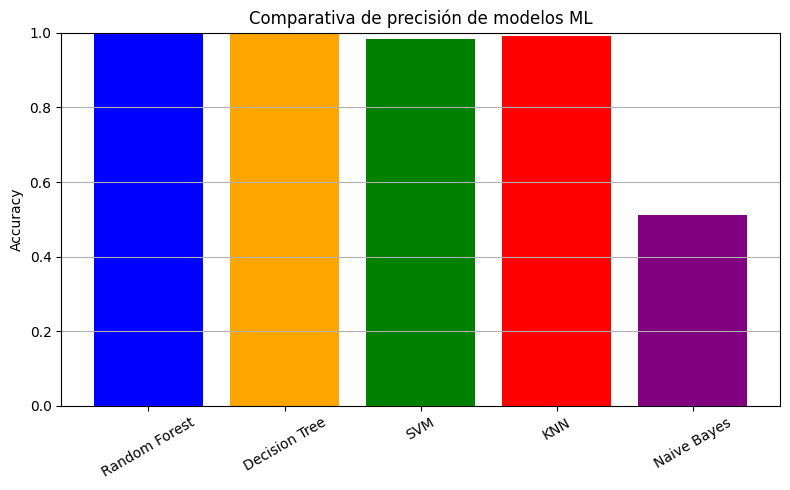

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Inicializar modelos
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Entrenamiento y resultados
accuracies = {}

for name, model in models.items():
    print(f"\n🔹 Entrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    
    print(f"🔸 Accuracy: {acc:.4f}")
    print(f"🔸 Reporte:\n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")

# Gráfica comparativa
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=["blue", "orange", "green", "red", "purple"])
plt.title("Comparativa de precisión de modelos ML")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Cargar dataset fusionado
df = pd.read_csv("results/final2_modified_sorted.csv")

# Asegurar que la columna esté bien
df["Abnormality class"] = df["Abnormality class"].astype(str)

# Definir función BARO
def baro_root_cause_analysis(df, group_col, metric_col, label_col="Abnormality class", normal_class="1"):
    results = []

    for group, group_df in df.groupby(group_col):
        normal = group_df[group_df[label_col] == normal_class][metric_col].dropna()
        anomalous = group_df[group_df[label_col] != normal_class][metric_col].dropna()

        if len(normal) < 5 or len(anomalous) < 5:
            continue

        median_normal = np.median(normal)
        median_anomalous = np.median(anomalous)
        iqr_normal = iqr(normal)

        is_root_cause = (median_anomalous - median_normal) > (1.5 * iqr_normal)

        results.append({
            group_col: group,
            "median_normal": median_normal,
            "median_anomalous": median_anomalous,
            "iqr_normal": iqr_normal,
            "difference": median_anomalous - median_normal,
            "is_root_cause": is_root_cause
        })

    return pd.DataFrame(results)

# Seleccionar columnas candidatas (excluyendo Abnormality class y objetos)
candidatas = [col for col in df.columns if col not in ["Abnormality class", "Experiment"]
              and df[col].dtype != "object"]

# Aplicar BARO para cada métrica usando como grupo los pods o microservicios
resultados_baro = {}

for col in candidatas:
    print(f"🔍 Analizando métrica: {col}")
    r = baro_root_cause_analysis(df, group_col="instance", metric_col=col, normal_class="1")
    resultados_baro[col] = r
    if not r.empty and "is_root_cause" in r.columns:
        display(r[r["is_root_cause"] == True])
    else:
        print("No hay resultados para esta métrica.")


🔍 Analizando métrica: container_cpu_usage_seconds_total
No hay resultados para esta métrica.
🔍 Analizando métrica: container_cpu_system_seconds_total
No hay resultados para esta métrica.
🔍 Analizando métrica: container_memory_working_set_bytes
No hay resultados para esta métrica.
🔍 Analizando métrica: container_memory_rss
No hay resultados para esta métrica.
🔍 Analizando métrica: container_network_receive_bytes_total
No hay resultados para esta métrica.
🔍 Analizando métrica: container_network_transmit_packets_total
No hay resultados para esta métrica.


In [19]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Cargar el dataset
df_res = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Lista de métricas de interés
metricas_pods = [
    "container_cpu_usage_seconds_total",
    "container_memory_working_set_bytes",
    "container_network_transmit_packets_total"
]

group_col = "instance"
label_col = "Abnormality class"
normal_class = "Normal"

# Función BARO
def aplicar_baro(df, group_col, metric_col, label_col="Abnormality class", normal_class="Normal"):
    resultados = []

    for grupo, df_grupo in df.groupby(group_col):
        normal = df_grupo[df_grupo[label_col] == normal_class][metric_col].dropna()
        anormal = df_grupo[df_grupo[label_col] != normal_class][metric_col].dropna()

        if len(normal) < 5 or len(anormal) < 5:
            continue

        mediana_normal = np.median(normal)
        mediana_anormal = np.median(anormal)
        iqr_normal = iqr(normal)

        es_causa = (mediana_anormal - mediana_normal) > (1.5 * iqr_normal)

        resultados.append({
            group_col: grupo,
            "median_normal": mediana_normal,
            "median_anomalous": mediana_anormal,
            "iqr_normal": iqr_normal,
            "difference": mediana_anormal - mediana_normal,
            "is_root_cause": es_causa
        })

    return pd.DataFrame(resultados)

# Ejecutar BARO para cada métrica
for metrica in metricas_pods:
    print(f"\n📌 Analizando métrica: {metrica}")
    baro_df = aplicar_baro(df_res, group_col, metrica, label_col, normal_class)
    causas_raiz = baro_df[baro_df["is_root_cause"] == True]
    print(causas_raiz)

    # Guardar resultados
    output_file = f"baro_root_cause_final2_{metrica}.csv"
    causas_raiz.to_csv(output_file, index=False)
    print(f"✅ Guardado en: {output_file}")



📌 Analizando métrica: container_cpu_usage_seconds_total
Empty DataFrame
Columns: [instance, median_normal, median_anomalous, iqr_normal, difference, is_root_cause]
Index: []
✅ Guardado en: baro_root_cause_final2_container_cpu_usage_seconds_total.csv

📌 Analizando métrica: container_memory_working_set_bytes
Empty DataFrame
Columns: [instance, median_normal, median_anomalous, iqr_normal, difference, is_root_cause]
Index: []
✅ Guardado en: baro_root_cause_final2_container_memory_working_set_bytes.csv

📌 Analizando métrica: container_network_transmit_packets_total
Empty DataFrame
Columns: [instance, median_normal, median_anomalous, iqr_normal, difference, is_root_cause]
Index: []
✅ Guardado en: baro_root_cause_final2_container_network_transmit_packets_total.csv


# PAGERANK


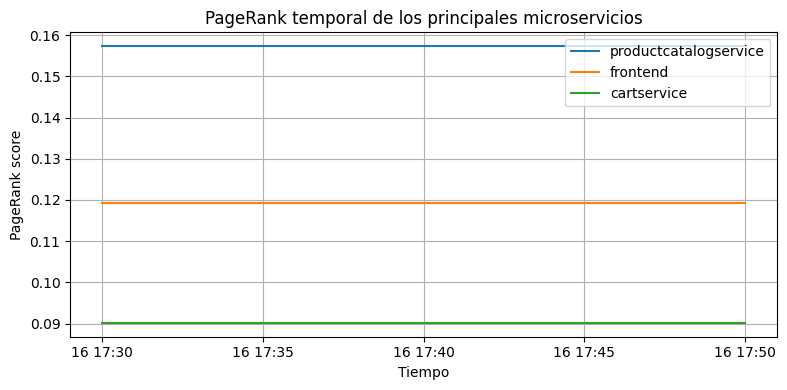

AttributeError: 'raphtory.node_state.NodeStateMotifs' object has no attribute 'keys'

In [16]:
from raphtory import Graph
from raphtory import algorithms as algo
import pandas as pd
import matplotlib.pyplot as plt
import os

# Cargar grafo
g = Graph.load_from_file("graphs/kiali_fused_graph_5_final")

# --- PageRank dinámico por ventanas temporales ---
pagerank_records = []
window_ms = 5 * 60 * 1000  # 5 minutos
step_ms = 1 * 60 * 1000    # 1 minuto

for view in g.rolling(window=window_ms, step=step_ms):
    pr = algo.pagerank(view)
    timestamp = view.earliest_time
    for node_obj, value in pr.items():
        # Extract node name as string (adjust attribute if needed)
        node_name = getattr(node_obj, "name", str(node_obj))
        pagerank_records.append({
            "timestamp": timestamp,
            "node": node_name,
            "pagerank": value
        })

df_pr = pd.DataFrame(pagerank_records)
df_pr.to_csv("results/raphtory_pagerank.csv", index=False)

# Mostrar gráfica para los 3 nodos más representativos
top_nodes = df_pr.groupby("node")["pagerank"].mean().nlargest(3).index
plt.figure(figsize=(8, 4))
for n in top_nodes:
    sub = df_pr[df_pr["node"] == n]
    plt.plot(pd.to_datetime(sub["timestamp"], unit="ms"), sub["pagerank"], label=n)
plt.title("PageRank temporal de los principales microservicios")
plt.xlabel("Tiempo"); plt.ylabel("PageRank score")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# --- Motifs temporales globales ---
delta_ms = 5 * 60 * 1000
motif_counts = algo.global_temporal_three_node_motif(g, delta_ms)
labels = [
    f"tri_{i+1}" for i in range(len(motif_counts))
]
df_mots = pd.DataFrame([motif_counts], columns=labels)
df_mots.to_csv("results/raphtory_motifs_global.csv", index=False)

# --- Motifs locales (por nodo) ---
local = algo.local_temporal_three_node_motifs(g, delta_ms)
df_loc = pd.DataFrame.from_dict(local, orient="index", columns=labels)
df_loc.index.name = "node"
df_loc.reset_index(inplace=True)
df_loc.to_csv("results/raphtory_motifs_local.csv", index=False)


        timestamp                   name     value
47  1744824600000           emailservice  0.075688
50  1744824600000        shippingservice  0.090177
49  1744824600000  productcatalogservice  0.157314
48  1744824600000         paymentservice  0.075688
51  1744824600000               frontend  0.119322


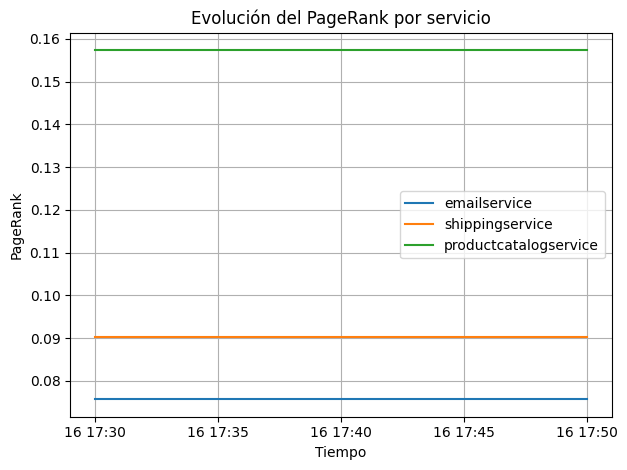

     tri_1    tri_2  tri_3  tri_4  tri_5  tri_6    tri_7       tri_8    tri_9  \
0  1038402  1182111      0      0      0      0  1240827  7306502217  1067760   

   tri_10  ...  tri_31      tri_32  tri_33  tri_34  tri_35  tri_36  tri_37  \
0       0  ...       0  2663393778  444900  449944  444900       0       0   

   tri_38  tri_39  tri_40  
0  455139  440007  435265  

[1 rows x 40 columns]


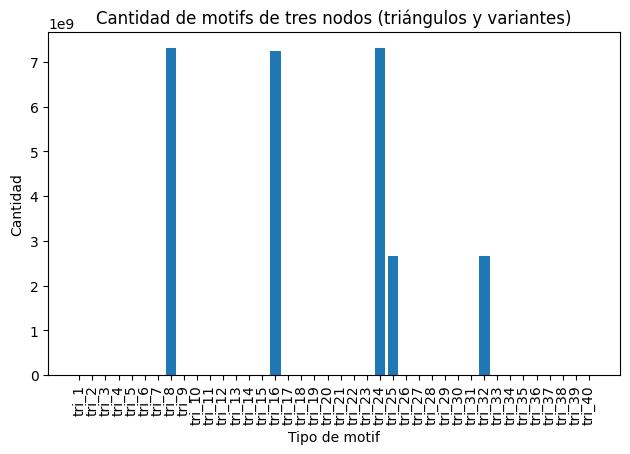

In [19]:
from raphtory import Graph
from raphtory import algorithms as algo
import pandas as pd
import matplotlib.pyplot as plt
import os


# Cargar el grafo existente
g = Graph.load_from_file("graphs/kiali_fused_graph_5_final")

# Ejecutar PageRank en ventanas temporales usando Raphtory API
window_ms = 5 * 60 * 1000  # 5 minutos
step_ms = 1 * 60 * 1000    # 1 minuto

pagerank_records = []
for view in g.rolling(window=window_ms, step=step_ms):
    pr = algo.pagerank(view)
    timestamp = view.earliest_time
    for node_obj, value in pr.items():
        node_name = getattr(node_obj, "name", str(node_obj))
        pagerank_records.append({
            "timestamp": timestamp,
            "name": node_name,
            "value": value
        })

df_pagerank = pd.DataFrame(pagerank_records)
df_pagerank = df_pagerank.sort_values(by="timestamp")

# Mostrar resultados
print(df_pagerank.head())

# Graficar evolución del PageRank de algunos servicios
for node in df_pagerank["name"].unique()[:3]:  # muestra 3 nodos
    sub = df_pagerank[df_pagerank["name"] == node]
    plt.plot(pd.to_datetime(sub["timestamp"], unit='ms'), sub["value"], label=node)

plt.title("Evolución del PageRank por servicio")
plt.xlabel("Tiempo")
plt.ylabel("PageRank")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Buscar motifs de comunicación tipo "triángulo de llamada" usando Raphtory algorithms
motif_counts = algo.global_temporal_three_node_motif(g, delta_ms)

# motif_counts es una lista con el número de cada tipo de motif (por ejemplo, triángulos)
# Puedes usar la variable 'labels' para los nombres de cada tipo de motif

df_motifs = pd.DataFrame([motif_counts], columns=labels)
print(df_motifs.head())

# Graficar la cantidad de triángulos detectados (por ejemplo, tri_1)
plt.bar(labels, motif_counts)
plt.title("Cantidad de motifs de tres nodos (triángulos y variantes)")
plt.xlabel("Tipo de motif")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


✅ PageRank guardado en: results/comunicacion_pagerank.csv


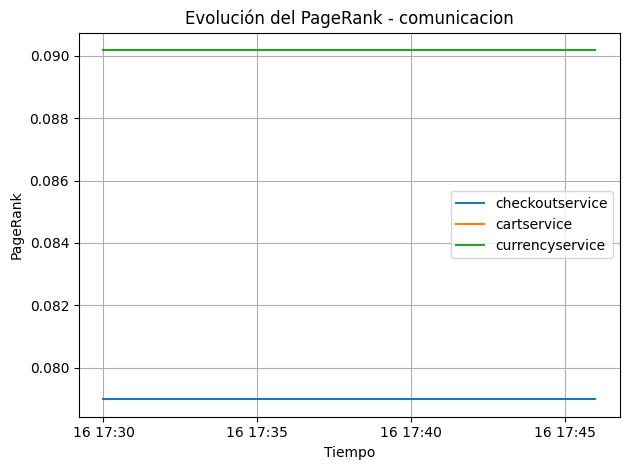

✅ Motifs guardado en: results/comunicacion_motifs.csv


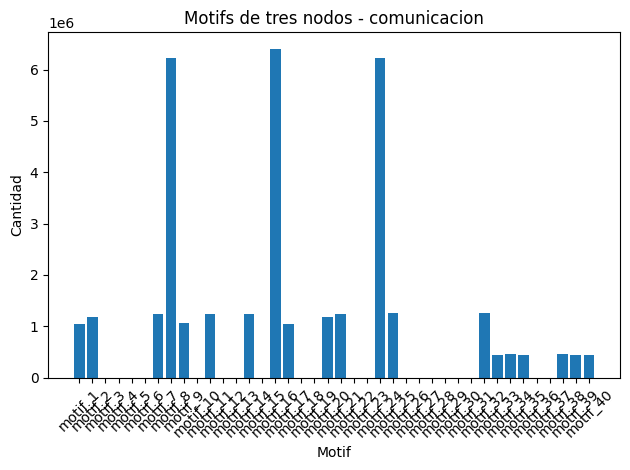

✅ PageRank guardado en: results/recursos_pagerank.csv


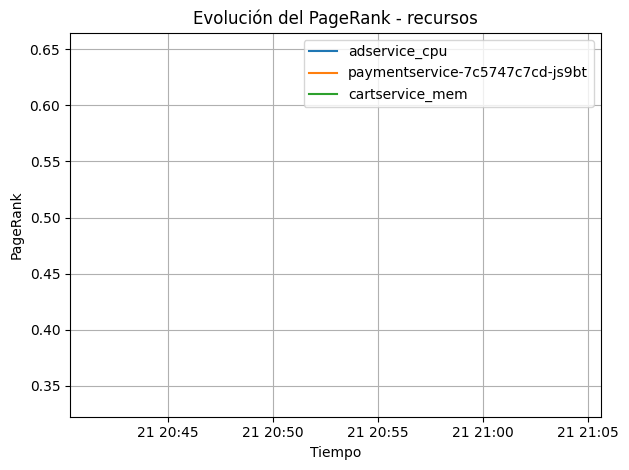

✅ Motifs guardado en: results/recursos_motifs.csv


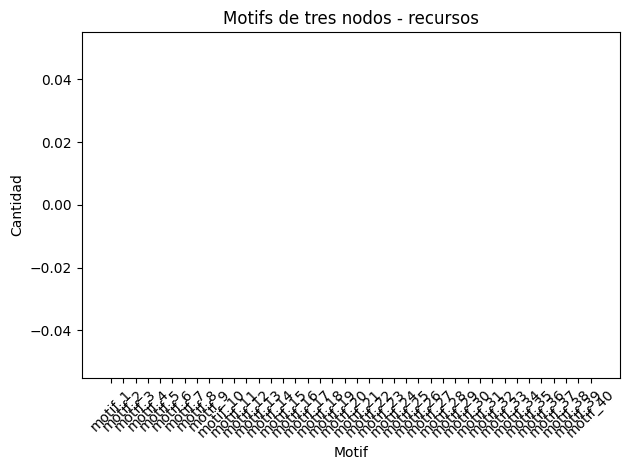

In [22]:
from raphtory import Graph
from raphtory import algorithms as algo
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURACIÓN GENERAL ---
WINDOW_MS = 5 * 60 * 1000  # Ventana de 5 minutos
STEP_MS = 1 * 60 * 1000    # Paso de 1 minuto

# === FUNCIONES GENERALES ===
def calcular_pagerank(g, nombre_salida):
    records = []
    for view in g.rolling(window=WINDOW_MS, step=STEP_MS):
        pr = algo.pagerank(view)
        timestamp = view.earliest_time
        for node_obj, value in pr.items():
            node_name = getattr(node_obj, "name", str(node_obj))
            records.append({
                "timestamp": timestamp,
                "name": node_name,
                "value": value
            })

    df_pr = pd.DataFrame(records).sort_values(by="timestamp")
    df_pr.to_csv(f"results/{nombre_salida}_pagerank.csv", index=False)
    print(f"✅ PageRank guardado en: results/{nombre_salida}_pagerank.csv")

    # Graficar 3 nodos ejemplo
    for node in df_pr["name"].unique()[:3]:
        sub = df_pr[df_pr["name"] == node]
        plt.plot(pd.to_datetime(sub["timestamp"], unit='ms'), sub["value"], label=node)

    plt.title(f"Evolución del PageRank - {nombre_salida}")
    plt.xlabel("Tiempo")
    plt.ylabel("PageRank")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calcular_motifs(g, nombre_salida):
    delta_ms = WINDOW_MS  # usamos misma ventana
    motif_counts = algo.global_temporal_three_node_motif(g, delta_ms)
    labels = [f"motif_{i+1}" for i in range(len(motif_counts))]
    df_motifs = pd.DataFrame([motif_counts], columns=labels)
    df_motifs.to_csv(f"results/{nombre_salida}_motifs.csv", index=False)
    print(f"✅ Motifs guardado en: results/{nombre_salida}_motifs.csv")

    plt.bar(labels, motif_counts)
    plt.title(f"Motifs de tres nodos - {nombre_salida}")
    plt.xlabel("Motif")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === CARGAR GRAFOS Y EJECUTAR ===

# 1️⃣ Grafo de comunicación
g1 = Graph.load_from_file("graphs/kiali_fullnode_graph-3")
calcular_pagerank(g1, "comunicacion")
calcular_motifs(g1, "comunicacion")

# 2️⃣ Grafo de creación (resources)
g2 = Graph.load_from_file("graphs/microservices_creation_graph")
calcular_pagerank(g2, "recursos")
calcular_motifs(g2, "recursos")


📈 Métricas obtenidas
1. PageRank temporal
Has calculado la evolución del PageRank a lo largo del tiempo para:

Grafo de comunicación (kiali_kpi_metrics_processed.csv)

Grafo de recursos (final2_modified_sorted.csv)

Esto permite detectar microservicios o pods que actúan como hubs o puntos centrales en distintos momentos del tiempo.

2. Motifs de tres nodos
Los resultados muestran:

Una variedad rica de motifs en el grafo de comunicación → buena señal de actividad topológica compleja.

Casi ningún motif en el grafo de recursos → esto es esperable, ya que este grafo es más jerárquico y simple (instance → pod), sin muchas conexiones internas entre pods.

In [26]:
import pandas as pd
from raphtory import Graph
import os

# Cargar datasets
df_comm = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])
df_res = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Inicializar grafo
g = Graph()

# -------------------------------
# Añadir microservicios y comunica_con
# -------------------------------
for _, row in df_comm.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    src = str(row["source_workload"]).strip()
    dst = str(row["destination_workload"]).strip()

    g.add_node(ts, src, node_type="Microservice")
    g.add_node(ts, dst, node_type="Microservice")

    g.add_edge(ts, src, dst, properties={
        "edge_type": "comunica_con",
        "latency": row.get("average_latency"),
        "request_rate": row.get("request_rate"),
        "success_rate": row.get("success_rate"),
        "error_rate": row.get("error_rate"),
        "throughput": row.get("throughput"),
        "abnormality": row.get("Abnormality class")
    })

# -------------------------------
# Añadir pods y creado_por
# -------------------------------
for _, row in df_res.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)
    pod = str(row["instance"]).strip()
    service = str(row["pod"]).strip()

    g.add_node(ts, pod, node_type="Pod")
    g.add_node(ts, service, node_type="Microservice")

    g.add_edge(ts, pod, service, properties={
        "edge_type": "creado_por"
    })

# -------------------------------
# Guardar el grafo
# -------------------------------
output_path = "graphs/graph_with_metrics"
os.makedirs("graphs/", exist_ok=True)
g.save_to_file(output_path)
print("✅ Grafo temporal creado")

# -------------------------------
# Calcular PageRank
# -------------------------------
from raphtory.algorithms import pagerank

pr_result = pagerank(g)
df_pagerank = pd.DataFrame(pr_result)
df_pagerank.to_csv("results/pagerank_result.csv", index=False)
print("✅ PageRank guardado en results/pagerank_result.csv")

# -------------------------------
# Detección de motifs temporales
# -------------------------------
from raphtory import algorithms as algo

motif_counts = algo.global_temporal_three_node_motif(g, WINDOW_MS)
labels = [f"tri_{i+1}" for i in range(len(motif_counts))]
df_motifs = pd.DataFrame([motif_counts], columns=labels)
df_motifs.to_csv("results/motifs_result.csv", index=False)
print("✅ Motifs temporales guardados en results/motifs_result.csv")


✅ Grafo temporal creado
✅ PageRank guardado en results/pagerank_result.csv
✅ Motifs temporales guardados en results/motifs_result.csv
